- Cognitive, Behavioral, and Social data
- Pavel Ianko
- Andrii Kliachkin
- Manoj Kumar Nagabandi

Below, **please select local, if you work from the local PC. USE_MATPLOTLIB_NOTEBOOK will allow to watch interactive 3D plots**

In [2]:
MODE = 'LOCAL'  # ['LOCAL', 'COLAB']
USE_MATPLOTLIB_NOTEBOOK = False  # If True, 3D plots will be interactive in Jupyter notebook environment. In VS code, however,
# if set to True, 2D plots will not appear

if USE_MATPLOTLIB_NOTEBOOK:
    %matplotlib notebook

# Imports

In [3]:
%%capture
if MODE == 'COLAB':
    !pip install factor-analyzer
    !pip install model

In [4]:
# Colab
if MODE == 'COLAB':
    from google.colab import drive

# paths
import os

# data
import pandas as pd

# sklearn
import sklearn
from sklearn.model_selection import train_test_split

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting
from itertools import combinations
import seaborn as sns
# from ipywidgets import IntProgress
from IPython.display import display

# sklearn pipeline & preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import kendalltau
from sklearn.feature_selection import f_classif

from sklearn.metrics import accuracy_score
from sklearn.metrics import explained_variance_score

from sklearn.base import clone as clone_model
from collections import Counter
import matplotlib.pyplot as plt

import copy
from factor_analyzer.factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [6]:
# %%capture

if MODE == 'COLAB':
    def download_files(url_dict):
        for file, url in url_dict.items():
            print(f'Downloading {file}')
            !wget -O {file} {url} {file}

    git_download_path = \
        'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'

    files = [
        'sklearn_utils.py',
        'model.py'
    ]

    url_dict = {file: git_download_path + file for file in files}
    download_files(url_dict)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn_utils import plot_cv_results

In [9]:
%%capture
if MODE == 'COLAB':
    try:
        from nbpep8.nbpep8 import pep8
    except ModuleNotFoundError:
        !pip install pycodestyle 
        !pip install --index-url https://test.pypi.org/simple/ nbpep8 
        from nbpep8.nbpep8 import pep8

In [10]:
if MODE == 'COLAB':
    import importlib
    import sklearn_utils
    import model

    def reload_all(modules_list_):
        for module in modules_list_:
            importlib.reload(module)

    reload_all(
        [
            sklearn_utils,
            model
            # other modules
        ]
    )

from model import Model
from sklearn_utils import (
    plot_cv_results,
    dict_subset,
    _collect_train_test_scores
)

Section below contains all functions, that we used in the project. Moreover, it has necessary constants:
- TRAINVAL_SIZE - size of the train + validation dataset
- TRAIN_SIZE - proportion of the train data in the train + validation dataset
- RANDOM_STATE - for fixing the random seed
- PSYCHOLOGIC_SAMPLE_SIZE - for subsampling the original dataset for data analysis
- GRID_SEARCH_MODELS - list of sklearn models, that were used for fine-tuning hyperparameters, to achieve best performance on full dataset (before dimensionality reduction). According to the experiment scheme, **a model with the same hyperparameters** was tested on the data with reduced dimensionality
- PROBLEM_STATEMENT_MODELS - list of models with default hyperparameters, to plot feature importances and show the problem statement (hyperparameters were not fine-tuned during the problem statement)

# Helper functions & constants

In [11]:
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8  # size(trainval) * train_size
RANDOM_STATE = 42
PSYCHOLOGIC_SAMPLE_SIZE = 0.7

In [12]:
from dataclasses import dataclass, field

@dataclass
class Model:
    model: None
    name: str
    grid_search_param_grid: list 
    random_search_param_grid: list

In [13]:
# 3. Define models
random_forest_model = Model(
    RandomForestClassifier(),
    'Random forest',
    [
        {
            'n_estimators': [5, 10, 20],
            'random_state': [42]
        }
    ],
    []
)
svm_model = Model(
    SVC(),
    'SVM',
    [
        {
            'kernel': ['linear'],
            'random_state': [42]
        }
    ],
    []
)
logreg_model = Model(
    LogisticRegression(max_iter=1000),
    'LogReg',
    [
        {
            'random_state': [RANDOM_STATE],
            'penalty': ['elasticnet'],
            'C': [1.0, 0.1, 0.01],
            'max_iter': [500],
            'solver': ['saga'],
            'l1_ratio': [0.1, 0.5, 1.0]
        }
    ],
    []
)
decision_tree_model = Model(
    DecisionTreeClassifier(),
    'DecisionTree',
    [
        {
            'random_state': [RANDOM_STATE],
            'max_depth': [3, 5, 10],
            'max_features': ['sqrt', 'log2']
        }
    ],
    []
)
gradient_boosting_model = Model(
    GradientBoostingClassifier(),
    'GradientBoosting',
    [
        {
            'random_state': [RANDOM_STATE],
            'n_estimators': [5, 10, 50],
            'subsample': [1.0, 0.7],
            'max_depth': [3, 5, 10]
        }
    ],
    []
)
adaptive_boosting_model = Model(
    AdaBoostClassifier(),
    'AdaptiveBoosting',
    [
        {
            'random_state': [RANDOM_STATE],
            'n_estimators': [5, 10, 50],
            'learning_rate': [1.0, 0.1]
         
        }
    ],
    []
)

perceptron_model = Model(
    Perceptron(),
    'Perceptron',
    [
        {
            'random_state': [RANDOM_STATE],
            'alpha': [0.001, 0.0001],
            'early_stopping': [False]
        }
    ],
    []
)


GRID_SEARCH_MODELS = {
    model.name: model
    for model in [
        random_forest_model,
        svm_model,
        logreg_model,
        perceptron_model,
        decision_tree_model,
        gradient_boosting_model,
        adaptive_boosting_model
    ]
}

In [14]:
svm_problem_statement = Model(
    SVC(),
    'SVM',
    [
        {
            'random_state': [RANDOM_STATE],
            # IMPORTANT! can calc importance only with linear kernel
            'kernel': ['linear']
        }
    ],
    [
        # No specified randomized search parameters
    ]
)
random_forest_problem_statement = Model(
    RandomForestClassifier(),
    'Random forest',
    [
        {
            'random_state': [RANDOM_STATE]
        }
    ],
    [
        # Not specified
    ]
)
logreg_problem_statement = Model(
    LogisticRegression(),
    'LogReg',
    [
        {
            'random_state': [RANDOM_STATE]
        }
    ],
    []
)
decision_tree_problem_statement = Model(
    DecisionTreeClassifier(),
    'DecisionTree',
    [
        {
            'random_state': [RANDOM_STATE]
        }
    ],
    []
)
gradient_boosting_problem_statement = Model(
    GradientBoostingClassifier(),
    'GradientBoosting',
    [
        {
            'random_state': [RANDOM_STATE]
        }
    ],
    []
)
adaptive_boosting_problem_statement = Model(
    AdaBoostClassifier(),
    'AdaptiveBoosting',
    [
        {
            'random_state': [RANDOM_STATE]
        }
    ],
    []
)

perceptron_problem_statement = Model(
    Perceptron(),
    'Perceptron',
    [
        {
            'random_state': [RANDOM_STATE]
        }
    ],
    []
)

PROBLEM_STATEMENT_MODELS = {
    model.name: model
    for model in [
        svm_problem_statement,
        logreg_problem_statement,
        perceptron_problem_statement,
        
        random_forest_problem_statement,
        decision_tree_problem_statement,
        gradient_boosting_problem_statement,
        adaptive_boosting_problem_statement,
        
    ]
}

In [15]:
def get_X_Y(df_):
    return df_[:, 1:], df_[:, 0]

def _pep8(arg):
    if MODE == 'COLAB':
        pep8(arg)


_pep8(_ih)

In [16]:
def spearmanrho(a, b):
    """Spearman Rho coefficient, rank order correlation"""
    if a.shape != b.shape:
        raise Exception('Shapes of a and b not equal')
    n = np.shape(a)[0]
    d = (a - b)**2
    return 1-6*np.sum(d)/(n*(n**2-1))

In [17]:
def plot_insights(df_train_, df_sample_):
    _ = plot_averaged_question_responses(df_train_)

    plot_person_response(
        df_sample_,
        df_indices_=np.unique(df_sample_.index[:5])
    )

    plot_dishonest_responses(df_sample_)


_pep8(_ih)

In [18]:
def read_data(root_path, folder_name):
    if folder_name == '5. PHQ9_GAD7':

        phq9_gad_7_csv_path = os.path.join(
            root_path, '5. PHQ9_GAD7', 'PHQ9_GAD7_df.csv')
        assert os.path.isfile(phq9_gad_7_csv_path)
        return pd.read_csv(phq9_gad_7_csv_path, sep=';')

    if folder_name == '2. PRMQ':
        path = os.path.join(
            root_path, '2. PRMQ', 'PRMQ_df.csv')
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '4. NAQ_R':
        path = os.path.join(
            root_path, '4. NAQ_R', 'NAQ_R_df.csv'
        )
        assert os.path.isfile(path)
        df = pd.read_csv(path, sep=';')
        df = df.loc[
            (df['CONDITION'] == 'H')
            | (df['CONDITION'] == 'D'),
            :
        ]
        return df

    if folder_name == '6. PID5':
        path = os.path.join(
            root_path, '6. PID5', 'PID5_df_csv.csv')
        
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=';')

    if folder_name == '7. shortPID5':
        path = os.path.join(
            root_path, folder_name, 'sPID-5_df.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '8. PRFQ':
        path = os.path.join(
            root_path, folder_name, 'PRFQ_df.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '9. IESR':
        path = os.path.join(
            root_path, folder_name, 'IESR_df.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=',')

    if folder_name == '1. shortDT (2) (ji)':
        ji_path = os.path.join(
            root_path, '1. shortDT (2)', 'DT_df_JI.csv')
        print(ji_path)
        assert os.path.isfile(ji_path)
        return pd.read_csv(ji_path, sep=';')

    if folder_name == '1. shortDT (2) (cc)':
        cc_path = os.path.join(
            root_path, '1. shortDT (2)', 'DT_df_CC.csv')
        assert os.path.isfile(cc_path)
        return pd.read_csv(cc_path, sep=',')

    if folder_name == '13. BF (3) (ctu)':
        path_ctu = os.path.join(
            root_path, '13. BF (3)', 'BF_df_CTU.csv')
        assert os.path.isfile(path_ctu)
        return pd.read_csv(path_ctu, sep=',')
    
    if folder_name == '13. BF (3) (ou)':
        path_ou = os.path.join(
            root_path, '13. BF (3)', 'BF_df_OU.csv')
        assert os.path.isfile(path_ou)
        return pd.read_csv(path_ou, sep=',')

    if folder_name == '13. BF (3) (v)':
        path_v = os.path.join(
            root_path, '13. BF (3)', 'BF_df_V.csv')
        assert os.path.isfile(path_v)
        return pd.read_csv(path_v, sep=',')

    if folder_name == '12. IADQ':
        path = os.path.join(
            root_path, folder_name, 'IADQ_df.csv'
        )
        return pd.read_csv(path, sep=',')

    if folder_name == '11. DDDT':
        path = os.path.join(
            root_path, folder_name, 'RAW_DDDT.CSV'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path)
    
    if folder_name == '3. PCL':
        path = os.path.join(
            root_path, folder_name, 'PCL5_df_csv.csv'
        )
        assert os.path.isfile(path)
        return pd.read_csv(path, sep=';')


_pep8(_ih)

In [19]:
def check_data(dataset_):
    # Check is any NAN values
    assert dataset_.isna().sum().sum() == 0

    # Check that all values are in appropriate range
    assert (dataset_.values[:, :-1] <= 5).all() \
        & (dataset_.values[:, :-1] >= 0).all()

In [20]:
def check_split_correctness(df_, target_column_, eps_=0.01):
    '''
    Checks that class balance is still 50%/50%
    '''
    assert abs(df_[target_column_].value_counts(normalize=True)['D'] - 0.5) \
        <= eps_
    assert abs(df_[target_column_].value_counts(normalize=True)['H'] - 0.5) \
        <= eps_


_pep8(_ih)

In [21]:
def prepare_sample(
    dataset_,
    sample_size_,
    random_state_=RANDOM_STATE
):
    # Assume the proper structure of the dataset
    # (even number of rows - first honest, then dishonest
    # responses)

    '''
    We split the dataset into 2 halves (of honest and dishonest responses)
    Then generate a sample of random indices, subsample same sample from honest
    half, and dishonest half. And concatenate the samples
    '''

    honest_subset = pd.DataFrame(
        dataset_.loc[: (dataset_.shape[0] / 2) - 1]
    )
    dishonest_subset = pd.DataFrame(
        dataset_.loc[dataset_.shape[0] / 2:]
    )

    dishonest_subset.reset_index(inplace=True)
    dishonest_subset.drop(['index'], axis='columns', inplace=True)

    assert honest_subset.shape[0] == dishonest_subset.shape[0]
    assert honest_subset.shape[0] + dishonest_subset.shape[0] \
        == dataset_.shape[0]
    assert honest_subset.CONDITION.nunique() \
        == dishonest_subset.CONDITION.nunique() \
        == 1
    assert (honest_subset.index == dishonest_subset.index).all()

    np.random.seed(random_state_)

    sample = np.random.choice(
        range(honest_subset.shape[0]),
        replace=False,
        size=int(honest_subset.shape[0] * sample_size_)
    )

    res = pd.concat(
        [
            honest_subset.loc[sample],
            dishonest_subset.loc[sample]
        ]
    )
    assert res.shape[1] \
        == honest_subset.shape[1] \
        == dishonest_subset.shape[1]

    return res


_pep8(_ih)

In [22]:
def verify_sample_correctness(df_original_, df_sampled_):
    for i in df_sampled_.index:
        # assert that both Honest and Dishonest conditions are present
        assert len(df_sampled_.index[df_sampled_.index == i]) == 2
        assert 'H' in df_sampled_.loc[i].CONDITION.values \
            and 'D' in df_sampled_.loc[i].CONDITION.values

        # Sample of honest and dishonest response of the same
        # person in original dataset
        original_sample = df_original_.loc[
            [i, int(df_original_.shape[0] / 2) + i]
        ]
        assert (original_sample.values == df_sampled_.loc[i].values).all()


_pep8(_ih)

In [23]:
def plot_averaged_question_responses(df_):
    '''
    Assumed structure: target is CONDITION, with H and D values
    1. Splits the dataset into Honest and Dishonest
    2. For each question, computes average score in Honest
    dataset, and Dishonest dataset
    3. Plots the results
    '''

    df_honest = df_[df_['CONDITION'] == 'H']
    df_dishonest = df_[df_['CONDITION'] == 'D']

    result = {}
    for question in df_.columns[df_.columns != 'CONDITION']:
        mean_response_honest = df_honest[question].mean()
        mean_response_dishonest = df_dishonest[question].mean()

        result[question] = {
            'honest': mean_response_honest,
            'dishonest': mean_response_dishonest
        }

    mean_responses_df = pd.DataFrame(result).transpose()

    mean_responses_df['relative_delta'] = \
        (mean_responses_df['dishonest'] - mean_responses_df['honest']) \
        / (mean_responses_df['honest'])

    ax = mean_responses_df.plot(kind='bar')
    ax.set_title(
        'Mean responses in honest and dishonest conditions \n(shuffled people)'
    )
    ax.grid()

    return mean_responses_df


_pep8(_ih)

In [24]:
def plot_person_response(df_, df_indices_):
    for df_index in df_indices_:
        ax = df_.loc[
            df_index,
            [c for c in df_.columns if c != 'CONDITION']
        ].transpose().plot(kind='bar')
        ax.legend(df_.loc[df_index, 'CONDITION'])
        ax.set_title(f'Person with index {df_index}')
        ax.grid()


_pep8(_ih)

In [25]:
def _visualize_averages(
    df_sample_,
    average_honest_responses,
    average_dishonest_responses,
    average_difference_in_response
):
    ax = pd.DataFrame(
        [
            average_honest_responses,
            average_dishonest_responses,
            average_difference_in_response
        ],
        columns=df_sample_.columns[df_sample_.columns != 'CONDITION'],
        index=['Honest', 'Dishonest', 'Difference']
    ).transpose().plot(kind='bar')

    ax.grid()
    ax.set_title('Average between dishonest and honest responses')
    ax.set_xlabel('Question')
    ax.set_ylabel('Difference in scale')
    ax.legend(loc='lower right')


def plot_dishonest_responses(df_sample_):
    '''
    - Requires input dataframe with the structure,
    like in #5 or #2 dataframes (half of honest, half of
    dishonest rows)
    1. For every person:
        - Collects honest response of this particular person
        - Collects dishonest response of this particular person
        - Collects difference (Dishonest - Honest) for every question
    2. Builds a bar chart, where for each question there are three bars:
        - Average honest response, averaged across all persons
        - Average dishonest response, averaged across all persons
        - Average difference between dishonest and honest response
        (we calculate the difference person-wise --> then take average)
    3. Returns 3 arrays:
        - List of lists of differences in responses
        - List of lists of honest responses
        - List of lists of dishonest responses
    '''

    fig, ax = plt.subplots()
    questions = df_sample_.columns[df_sample_.columns != 'CONDITION']
    unique_person_indices = np.unique(df_sample_.index)
    differences_in_response = []
    honest_responses_array = []
    dishonest_responses_array = []
    plotting_params = dict(marker='o', alpha=0.1)

    for unique_person_index in unique_person_indices:
        # view with Honest and Dishonest responses of the same person
        person_responses = pd.DataFrame(
            df_sample_.loc[unique_person_index])
        honest_responses = person_responses.loc[
            person_responses['CONDITION'] == 'H',
            questions]
        dishonest_responses = person_responses.loc[
            person_responses['CONDITION'] == 'D',
            questions]

        ax.scatter(
            x=range(honest_responses.shape[1]),
            y=honest_responses.values[0],
            color='red',
            **plotting_params
        )

        ax.scatter(
            x=range(honest_responses.shape[1]),
            y=dishonest_responses.values[0],
            color='blue',
            **plotting_params
        )
        differences_in_response.append(
            dishonest_responses.values[0] - honest_responses.values[0])

        honest_responses_array.append(honest_responses.values[0])
        dishonest_responses_array.append(dishonest_responses.values[0])
        del person_responses

    ax.set_xlabel('Questions')
    ax.set_ylabel('Response')
    ax.legend(['Honest', 'Dishonest'], loc='lower right')
    ax.grid()

    # BUILDING ANOTHER PLOT OF DIFFERENCE BETWEEN
    # AVERAGE HONEST AND DISHONEST RESPONSE
    average_difference_in_response = np.mean(
        differences_in_response,
        axis=0)

    average_honest_responses = np.mean(
        honest_responses_array,
        axis=0)

    average_dishonest_responses = np.mean(
        dishonest_responses_array,
        axis=0)

    _visualize_averages(
        df_sample_,
        average_honest_responses,
        average_dishonest_responses,
        average_difference_in_response
    )


_pep8(_ih)

In [26]:
def make_title(dname, fnames):
    if type(fnames) == list:
        algs = ' and '.join((', '.join(fnames[:-1]), fnames[-1]))
        return f'Validation performance comparison on {dname} with {algs}'
    elif type(fnames) == str:
        algs = fnames
        return f'Validation performance on {dname} with {algs}'

def draw_scores_plot(scores: pd.DataFrame, legend=None, metric=None):
    f, (ax1, ax2) = plt.subplots(figsize=(15,5), nrows=1, ncols=2, constrained_layout=True)

    ax1.set_title('Performance on the validation set')
    ax2.set_title('Difference between validation performance on reduced and original data')
    ax1.set_ylabel(metric)
    if legend == None:
        mnames = list(scores.index)
    else:
        mnames = legend

    feature_range = range(1,scores.shape[1]+1)

    for model_name in legend:
        ax1.set_xticks(feature_range)
        ax2.set_xticks(feature_range)
        ax1.plot(feature_range, scores.loc[model_name])
        ax1.scatter(feature_range, scores.loc[model_name], marker='o',label='_nolegend_')
        last_col = scores.columns[-1]
        ax2.plot(feature_range, scores.loc[model_name] - scores.loc[model_name][last_col])
        ax2.scatter(feature_range, scores.loc[model_name] - scores.loc[model_name][last_col], marker='o',label='_nolegend_')
    
    ax1.grid()
    ax2.grid()
    ax1.set_xlabel('Number of retained features')
    ax2.set_xlabel(ax1.get_xlabel())
    ax1.axvline(x=np.floor(scores.shape[-1]*0.2), ls='--', c='red')
    ax2.axvline(x=np.floor(scores.shape[-1]*0.2), ls='--', c='red')
    ax2.axhline(0,ls='--',c='red')

    ax1.legend(mnames)
    ax2.legend(mnames)
    return f, (ax1, ax2)


def draw_scores(scores, model_names,  metric_name, fig_title=None, alg_names=None, draw_difference=False, draw_hline=True):
    """
    Parameters:\n

    scores - either a dataframe of scores for each model, or a list of such dataframes (for comparison between feature selection algs)
    """
    nmodels = len(model_names)
    f = plt.figure(figsize=(10,5*nmodels), constrained_layout=True)
    #f.tight_layout(h_pad=5, w_pad=5)
    subfigs = f.subfigures(nrows=nmodels, ncols=1)
    for i, subfig in enumerate(subfigs):
        subfig.suptitle(f"Model: {model_names[i]}")
        if draw_difference:
            ax = subfig.add_subplot(1,2,1)
        else:
            ax = subfig.add_subplot(1,1,1)
        
        # if type(scores) == list and np.shape(scores[0]) != len(model_names) and np.shape(scores[1]) == len(model_names):
        if type(scores) != list:
            scores_ = [scores]
        else:
            scores_ = scores
        # scores of the i-th model with different feature selection procedures
        for model_scores in scores_:
            ax.plot(model_scores.columns.to_numpy(), model_scores.iloc[i])
            ax.scatter(model_scores.columns.to_numpy(), model_scores.iloc[i], marker='o')
            if draw_hline:
                ax.axhline(y=model_scores.iloc[i][model_scores.columns[-1]], linestyle='dashed',linewidth=1, label='_nolegend_',c='orange')
        ax.set_ylabel(metric_name)
        ax.grid()
        ax1 = ax.twiny()
        ax1.set_xlim(ax1.get_xlim())
        if len(scores_) > 1:
            ax.legend(alg_names)
        
        if draw_difference:
            ax_d = subfig.add_subplot(1, 2, 2)
            ax_d.plot(scores.iloc[i] - scores.iloc[i][scores.columns[-1]])
            ax_d.axhline(y=0, linestyle='dashed',linewidth=1, label='_nolegend_',c='orange')
            ax_d.grid()
            ax_d.set_ylabel('F1 score with full feature set - F1 score')
            ax1_d = ax_d.twiny()
            ax1_d.set_xlim(ax1_d.get_xlim())
            if len(scores_) > 1:
                ax_d.legend(alg_names)

        if i == 0:
            ax1.set_xlabel("Proportion of components retained")
            if draw_difference:
                ax.set_title('Validation performance')
                ax_d.set_title('Difference between validation performance on' \
                        + '\n reduced and original data')
                ax1_d.set_xlabel("Proportion of components retained")
        elif i == nmodels-1:
            ax.set_xlabel("N of components retained")
            if draw_difference:
                ax_d.set_xlabel("N of components retained")

    # for p in percentile_locations:
    #     ax.axvline(x=p, linestyle='dashed', c='black', alpha=0.1, label='_nolegend_')
    # f.subplots_adjust(top=0.8)
    if not fig_title is None:
        f.suptitle(fig_title, fontsize=15)
    return f

def draw_pca_results(pca):
    f, (ax,ax2) = plt.subplots(1,2, figsize=(15,5))
    ax.grid(axis='y', alpha=0.3)
    ax.bar(range(1, pca.explained_variance_ratio_.shape[-1] + 1), pca.explained_variance_ratio_, align='center',
        label='Individual explained variance')
    ax.set_ylim(bottom=0, top=1.05)
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    #ax1.set_ylim(bottom = pca.explained_variance_ratio_[0]/2.5, top = 1.0)
    ax1.step(range(1, pca.explained_variance_ratio_.shape[-1] + 1), np.cumsum(pca.explained_variance_ratio_), where='mid',
            label='Cumulative explained variance', color='red')
    ax.title.set_text('Explained variance ratio by component')
    ax.set_ylabel('Individual explained variance ratio')
    ax1.set_ylabel('Cumulative explained variance ratio')
    ax.set_xlabel('Principal component index')
    ax.set_xticks(ticks=range(1,pca.n_components_+1))

    ax2.plot(pca.explained_variance_)
    ax2.grid(axis='y', alpha=0.3)
    ax2.title.set_text('Scree Plot')
    ax2.set_xlabel('Eigenvalue index')
    ax2.set_ylabel('Eigenvalue')

    # f.legend(loc='center right')
    f.tight_layout()
    return f

def plot_feature_importances(X, y, feature_names_in, score_func=chi2):
    selector = SelectPercentile(score_func=score_func, percentile=PERCFEATURES)
    selector.fit(X, y)
    ax = plt.figure().add_subplot()
    ax.bar(feature_names_in, selector.scores_)
    ax.set_title(f'Feature importance with {score_func.__name__}')
    ax.set_ylabel('scores')
    ax.set_xlabel('features')
    ax.set_xticklabels(feature_names_in,rotation=45,ha='right')
    
    return ax

def plot_top_features(X, y, k, feature_names_in, score_func):

    assert np.shape(X)[0] == np.shape(y)[0]

    selector = SelectKBest(score_func=score_func, k=k)
    X_t = selector.fit_transform(X,y)
    fnames = selector.get_feature_names_out(input_features=feature_names_in)
    f = plt.figure(figsize=(10, 10))
    if k == 1:
        ax = f.add_subplot(projection='1d')
        ax.scatter(xs=X_t, c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
    if k == 2:
        ax = f.add_subplot()
        ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])
    if k == 3:
        f.tight_layout()
        ax3d = f.add_subplot(2,2,1, projection='3d')
        ax3d.scatter(xs=X_t[:,0],ys=X_t[:,1],zs=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.1)
        ax3d.set_xlabel(fnames[0])
        ax3d.set_ylabel(fnames[1])
        ax3d.set_zlabel(fnames[2])
        ax3d.view_init(elev=28, azim=-47)
        
        ax = f.add_subplot(222)
        # ax.hist2d(x=X_t[:,0],y=X_t[:,1],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,1], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[1])

        ax = f.add_subplot(223)
        # ax.hist2d(x=X_t[:,0],y=X_t[:,2],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,0],y=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[0])
        ax.set_ylabel(fnames[2])

        ax = f.add_subplot(224)
        # ax.hist2d(x=X_t[:,1],y=X_t[:,2],bins=np.arange(1,6))
        ax.scatter(x=X_t[:,1],y=X_t[:,2], c=['tab:orange' if cl == 1 else 'tab:blue' for cl in y],alpha=0.05)
        ax.set_xlabel(fnames[1])
        ax.set_ylabel(fnames[2])

        f.subplots_adjust(left=0, right=1, top=1, bottom=0,hspace=0.5)


    # legend_props = [mpl.lines.Line2D([0],[0], marker='o',color='tab:orange'),
    #                 mpl.lines.Line2D([0],[0], marker='o',color='tab:blue')]
    # f.legend(legend_props, ['Honest','Dishonest'],bbox_to_anchor=(1,0.95))
    if score_func == chi2:
        title = 'Top 3 features by Chi2'
    elif score_func == mutual_info_classif:
        title = 'Top 3 features by Mutual Information Criterion'
    elif score_func == lasso_importance:
        title = 'Top 3 features by Logistic Lasso Coefficients'
    elif score_func == rf_importance:
        title = 'Top 3 features by Random Forest Importance'
    f.suptitle(title)

    return f

In [27]:
def plot_feature_importances(
    grid_search_results_,
    figsize_=(10, 10),
    take_abs_=True,
    rank_order_correlation_percentage_=0.2
):
    dataframe_dict = {}
    dataframe_feature_importances_idxs = {}
    for model_name, gs_result in grid_search_results_.items():
        feature_importances = np.array(get_feature_importances(
            model_name,
            grid_search_results_[model_name]
        ))

        feature_importances_normalized = \
            feature_importances / np.max(abs(feature_importances))

        dataframe_dict[model_name] = feature_importances_normalized
        dataframe_feature_importances_idxs[model_name] = \
            np.argsort(np.abs(feature_importances))[::-1]

    ax = pd.DataFrame(dataframe_dict).plot(kind='bar', figsize=figsize_)
    ax.set_title('Feature importances, normalized by max. abs. value')
    ax.grid()

    # Plotting correlation matrix between feature importances
    _, ax_heatmap = plt.subplots()
    print(take_abs_)
    if take_abs_:
        dataframe_dict = {name: np.abs(data) for name, data in dataframe_dict.items()}
    sns.heatmap(
        pd.DataFrame(dataframe_dict).corr(),
        ax=ax_heatmap,
        annot=True,
        vmin=-1,
        vmax=1
    )
    ax_heatmap.set_title(f'Correlation of feature\nimportances')
    
    dataframe_feature_importances_idxs = pd.DataFrame(
        dataframe_feature_importances_idxs)
    # Limit size to rank_order_correlation_percentage_
    limit_size = int(
        rank_order_correlation_percentage_ \
        * dataframe_feature_importances_idxs.shape[0])
    dataframe_feature_importances_idxs = dataframe_feature_importances_idxs.iloc[:limit_size, :]

    print(dataframe_feature_importances_idxs)
    _, ax_rank_order_corr = plt.subplots()
    sns.heatmap(
        dataframe_feature_importances_idxs.corr(method='spearman'),
        ax=ax_rank_order_corr,
        annot=True,
        vmin=-1,
        vmax=1
    )
    ax_rank_order_corr.set_title(
        'Rank order correlation of important\nfeatures indices'
    )


def get_feature_importances(
    model_name_,
    grid_search_results_
):
    best_estimator = grid_search_results_.best_estimator_
    if model_name_ == 'SVM':
        return best_estimator.coef_[0]
    elif model_name_ == 'Random forest':
        return best_estimator.feature_importances_
    elif model_name_ == 'LogReg':
        return best_estimator.coef_[0]
    elif model_name_ == 'DecisionTree':
        return best_estimator.feature_importances_
    elif model_name_ == 'GradientBoosting':
        return best_estimator.feature_importances_
    elif model_name_ == 'AdaptiveBoosting':
        return best_estimator.feature_importances_
    elif model_name_ == 'Perceptron':
        return best_estimator.coef_[0]

    else:
        print(f'Did not find {model_name_} in get_feature_importances()')
        raise ValueError()


_pep8(_ih)

In [28]:
def do_rfe(
    X_train,
    y_train,
    X_val,
    y_val,
    models,
    model_names,
    col_names
):
    models_rfe = dict()
    feature_range = range(1, X_train.shape[-1] + 1)

    dataset_rankings = pd.DataFrame(index=model_names, columns = col_names)
    dataset_scores = pd.DataFrame(index=model_names, columns = feature_range)
    dataset_training_scores = pd.DataFrame(index=model_names, columns = feature_range)
    
    for model, mname in zip(models, model_names):
        # Obtain feature rankings according to their importance
        # On each new subset the model is retrained and retuned with the best hyperparams
        if isinstance(model, GridSearchCV):
            if isinstance(model.estimator, (RandomForestClassifier, AdaBoostClassifier, DecisionTreeClassifier, GradientBoostingClassifier)):
                imp_getter = 'best_estimator_.feature_importances_'
            else:
                imp_getter = 'best_estimator_.coef_'
        # if str.lower(mname) in ['Random Forest', 'AdaBoost', 'Decision Tree', 'Gradient Boosting'] :
        #     imp_getter = 'best_estimator_.feature_importances_'
        # else:
        #     imp_getter = 'best_estimator_.coef_'
        rfe = sklearn.feature_selection.RFE(model, n_features_to_select=1, importance_getter=imp_getter)
        rfe.fit(X_train,y_train)
        dataset_rankings.loc[mname] = rfe.ranking_
        # Get the metrics for each of the subsets
        models_rfe[mname] = []
        for k in feature_range:
            # get the subset of features
            cols_to_select = np.argwhere(rfe.ranking_ <= k).flatten()
            # train and evaluate the model
            model.fit(X_train.iloc[:,cols_to_select],y_train)
            dataset_scores.loc[mname][k] = sklearn.metrics.accuracy_score(
                y_val, model.predict(X_val.iloc[:,cols_to_select]))
            dataset_training_scores.loc[mname][k] = sklearn.metrics.accuracy_score(
                y_train, model.predict(X_train.iloc[:,cols_to_select]))
              
            if type(model) == GridSearchCV:
                models_rfe[mname].append(model.best_estimator_)
            else:
                models_rfe[mname].append(model)
        print(f'{mname} done')
    return dataset_rankings, dataset_training_scores, dataset_scores

In [29]:
from sklearn.model_selection import GridSearchCV

def fit_grid_search(
    models_dict_,
    X_,
    Y_,
    cv_,
    scoring_,
    **kwargs
):  
    scr = {}
    res = {
        name: None for name in list(models_dict_.keys())
    }
    for name, model in models_dict_.items():
        print(f'Fitting {name}')

        grid_search_estimator = GridSearchCV(
            model.model,
            param_grid=model.grid_search_param_grid,
            cv=cv_,
            scoring=scoring_,
            return_train_score=True,
            refit=True,
            verbose=kwargs.get('verbose') or 0
        )

        grid_search_result = grid_search_estimator.fit(X_, Y_)
        res[name] = grid_search_result

        train_scores, test_scores = _collect_train_test_scores(
            grid_search_result.cv_results_,
            grid_search_result.best_index_)
        assert len(train_scores) == len(test_scores)
        scr[name] = [train_scores, test_scores]


        # Plotting
        x = np.arange(1, len(train_scores) + 1)
        WIDTH = 0.5
        _, ax = plt.subplots()
        ax.bar(x - WIDTH / 2, test_scores, WIDTH, label='validation')
        ax.bar(x + WIDTH / 2, train_scores, WIDTH, label='train')
        ax.set_title(f'{name} (best_estimator) cross validation')
        ax.legend(loc='lower right')
        ax.set_xlabel('Number of fold')
        ax.set_ylabel('Metrics')
        ax.grid()

    return res,scr


In [30]:
def calculate_validation_performance(
    sklearn_model_,  # grid_search_results_,
    X_train_,
    Y_train_,
    X_validation_,
    Y_validation_,
    metrics_function_,
    feature_selection_function_,
    percentiles_
):
    '''
    percentiles_ - list of percentile values - how much of the features
    we retain.

    '''
    model_before_feature_selection = clone_model(sklearn_model_)
    model_after_feature_selection = clone_model(sklearn_model_)

    # Important - must refit on X_train and Y_train from scratch,
    # because grid search models were refit on X_train + X_validation
    # data, therefore comparison will not be fair
    model_before_feature_selection.fit(X_train_, Y_train_)

    metrics_before_feature_selection = metrics_function_(
        model_before_feature_selection.predict(X_validation_),
        Y_validation_)

    res_metrics = []
    n_features = []
    for percentile in percentiles_:
        X_train_reduced, X_validation_reduced = perform_feature_selection(
            feature_selection_function_,
            percentile,
            X_train_=X_train_,
            Y_train_=Y_train_,
            X_validation_=X_validation_,
            Y_validation_=Y_validation_
        )
        n_features.append(X_train_reduced.shape[1])

        model_after_feature_selection.fit(
            X_train_reduced, Y_train_)
        metrics_after_feature_selection = metrics_function_(
            model_after_feature_selection.predict(X_validation_reduced),
            Y_validation_)
        res_metrics.append(metrics_after_feature_selection)

    return {
        'percentiles': percentiles_,
        'n_features': n_features,
        'metrics': res_metrics
    }


_pep8(_ih)

In [31]:
def perform_feature_selection(
    feature_selection_function_,
    percentile_,
    X_train_,
    Y_train_,
    X_validation_,
    Y_validation_
):
    
    if percentile_ == 100:
        X_train_reduced = X_train_
        X_validation_reduced = X_validation_
    else:
        feature_selector = SelectPercentile(
            score_func=feature_selection_function_,
            percentile=percentile_
        )
        X_train_reduced = feature_selector.fit_transform(X_train_, Y_train_)
        X_validation_reduced = feature_selector.transform(X_validation_)
    
    return X_train_reduced, X_validation_reduced


_pep8(_ih)

In [32]:
def plot_validation_performance(
    models_validation_results_, **kwargs
):
    
    fig, ax = plt.subplots(1, 2, figsize=kwargs.get('figsize') or (15, 5))
    # fig.suptitle(
    #     kwargs.get('suptitle_') or '',
    #     fontsize=kwargs.get('fontsize_') or 10
    # )

    ax2 = ax[0].twiny()
    ax3 = ax[1].twiny()

    for model_name, results_dict in models_validation_results_.items():

        assert 20 in results_dict['percentiles']  # CBSD assignment
        index_20_percent = results_dict['percentiles'].index(20)
        n_features_20_percent = results_dict['n_features'][index_20_percent]

        ax[0].plot(
            results_dict['n_features'],
            results_dict['metrics'],
            marker='o',
            # linestyle='--',
            label=model_name
        )
        ax[0].axvline(n_features_20_percent, color='red', linestyle='--')

        ax[1].plot(
            results_dict['n_features'],
            [val - results_dict['metrics'][-1]
            for val in results_dict['metrics']],
            marker='o',
            # linestyle='--',
            label=model_name
        )
        ax[1].axvline(n_features_20_percent, color='red', linestyle='--')

    
    ax[0].set_title('Performance on the validation set')
    ax[0].set_xlabel('Number of retained features')
    ax[0].legend()
    ax[0].grid()

    # ax[0].axhline(
    #     results_dict_['metrics'][-1],
    #     linestyle='--',
    #     color='red'
    # )
    ax[1].set_title('Difference between validation performance on' \
                    + '\n reduced and original data')
    ax[1].axhline(0, linestyle='--', color='red')
    ax[1].legend()
    ax[1].grid()


_pep8(_ih)

In [33]:
def preprocess_data(
    df_trainval_,
    df_train_,
    df_validation_,
    df_test_,
    preprocessor_
):
    df_trainval_processed = preprocessor_.fit_transform(
        df_trainval_)
    df_train_processed = preprocessor_.fit_transform(
        df_train_)
    df_validation_processed = preprocessor_.transform(
        df_validation_)
    df_test_processed = preprocessor_.transform(
        df_test_)

    res = {
        'trainval': get_X_Y(df_trainval_processed),
        'train': get_X_Y(df_train_processed),
        'validation': get_X_Y(df_validation_processed),
        'test': get_X_Y(df_test_processed)
    }
    return res

_pep8(_ih)

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

def run_feature_selection_experiments(
    df_trainval_,
    df_train_,
    df_validation_,
    df_test_,
    feature_selectors_dict_,
    metrics_function_=accuracy_score,  # accuracy_score, explained_variance_score
    percentiles_=[5] + [i*10 for i in range(1, 11)],
    models_dict_=GRID_SEARCH_MODELS
):
    result = {}
    for feature_selector_name, feature_selector in \
            feature_selectors_dict_.items():
        
        print(f'====== VVV RUNNING {feature_selector_name} VVV ======')
        experiment_result = _run_feature_selection_experiment(
            df_trainval_,
            df_train_,
            df_validation_,
            df_test_,
            feature_selector,
            metrics_function_,
            percentiles_=percentiles_,
            models_dict_=models_dict_
        )
        result[feature_selector_name] = experiment_result
    return result


_pep8(_ih)

In [35]:
def visualize_clusters(df_, features, **kwargs):
    '''
    Features MUST BE SORTED - features[0] - most important feature,
    features[1], ... - less important features
    '''
    dict_honest_dishonest = {}
    for feature in features:
        dict_honest_dishonest[feature] = \
            {
                'honest': df_.loc[df_['CONDITION'] == 'H', [feature]],
                'dishonest': df_.loc[df_['CONDITION'] == 'D', [feature]]
            }

    # 1. 1D visualization - boxplots
    _, ax_1D = plt.subplots(figsize=kwargs.get('figsize') or (5, 5))
    sns.boxplot(
        x='CONDITION',
        y=features[0],
        data=df_,
        ax=ax_1D
    )
    ax_1D.grid()

    # 2. 2D visualization - scatter plot
    _, ax_2D = plt.subplots(figsize=kwargs.get('figsize') or (5, 5))
    ax_2D.grid()
    ax_2D.scatter(
        x=dict_honest_dishonest[features[0]]['honest'].values,
        y=dict_honest_dishonest[features[1]]['honest'].values,
        color='blue',
        label='honest',
        alpha=0.1)
    ax_2D.scatter(
        x=dict_honest_dishonest[features[0]]['dishonest'].values,
        y=dict_honest_dishonest[features[1]]['dishonest'].values,
        label='dishonest',
        color='red',
        alpha=0.1)
    ax_2D.set_xlabel(features[0])
    ax_2D.set_ylabel(features[1])
    ax_2D.legend()
    plt.show()

    # 3. 3D visualization - scatter plot
    fig, ax_3D = plt.subplots(figsize=kwargs.get('figsize') or (10, 10))
    ax_3D = plt.axes(projection='3d')
    ax_3D.grid()
    ax_3D.scatter(
        xs=dict_honest_dishonest[features[0]]['honest'].values,
        ys=dict_honest_dishonest[features[1]]['honest'].values,
        zs=dict_honest_dishonest[features[2]]['honest'].values,
        color='gray',
        label='honest')
    ax_3D.scatter(
        xs=dict_honest_dishonest[features[0]]['dishonest'].values,
        ys=dict_honest_dishonest[features[1]]['dishonest'].values,
        zs=dict_honest_dishonest[features[2]]['dishonest'].values,
        color='red',
        label='dishonest')
    ax_3D.set_xlabel(features[0])
    ax_3D.set_ylabel(features[1])
    ax_3D.set_zlabel(features[2])

    if kwargs.get('elev') and kwargs.get('azim'):
        ax_3D.view_init(elev=kwargs.get('elev'), azim=kwargs.get('azim'))
    ax_3D.legend()


_pep8(_ih)

In [36]:
def get_feature_names(
    X_trainval_processed_,
    df_trainval_,
    feature_indices_,
):
    '''
    After you apply column transformer,
    position of the features in the processed dataset
    can change with respect to the original data.
    Therefore, we need to control it
    '''
    # Check if columns shifted
    assert df_trainval_.shape[1] == X_trainval_processed_.shape[1] + 1, print(df_trainval_.shape, X_trainval_processed_.shape)

    for i in range(X_trainval_processed_.shape[1]):
        assert (X_trainval_processed_[:, i] == df_trainval_.values[:, i]).all()

    return df_trainval_.columns[feature_indices_]


_pep8(_ih)

In [37]:
def _report_outliers_percentage(df_, feature_name_):
    q3 = df_.quantile(0.75)
    q1 = df_.quantile(0.25)
    iqr = q3 - q1

    lower_lim = q1 - 1.5 * iqr
    upper_lim = q3 + 1.5 * iqr

    outlier_percentage = df_ \
        .loc[
            (df_[feature_name_] > upper_lim[feature_name_])
            | (df_[feature_name_] < lower_lim[feature_name_]),
            :
        ].shape[0] / len(df_)
    return round(outlier_percentage, 2)


def report_outliers(
    df_,
    feature_name_
):
    honest_subset = df_.loc[
        df_['CONDITION'] == 'H', [feature_name_]]
    dishonest_subset = df_.loc[
        df_['CONDITION'] == 'D', [feature_name_]]

    print(f'Median of {feature_name_} dishonest: {dishonest_subset.median()}')
    print(f'Median of {feature_name_} honest: {honest_subset.median()}')

    outlier_percentage_honest = \
        _report_outliers_percentage(honest_subset, feature_name_)
    outlier_percentage_dishonest = \
        _report_outliers_percentage(dishonest_subset, feature_name_)

    print(f'Outliers % honest subset: {outlier_percentage_honest}')
    print(f'Outliers % dishonest subset: {outlier_percentage_dishonest}')


_pep8(_ih)

In [38]:
from sklearn.model_selection import cross_val_score


def plot_selector_feature_scores(
    selectors_dict_,
    name_='',
    n_features_=None
):
    df = pd.DataFrame(selectors_dict_)
    df = (df - df.min()) / (df.max() - df.min())

    ax = df.plot(kind='bar')
    ax.set_title('Min-max-normalized feature importances')
    ax.legend(loc='lower center')
    ax.grid()

    
    _, ax_heatmap = plt.subplots()
    print(pd.DataFrame(selectors_dict_).corr())

    selectors_dict_indices = {
        name: np.argsort(data)[::-1]
        for name, data in selectors_dict_.items()
    }

    if n_features_ is not None:
        selectors_dict_indices = {
            name: np.argsort(data)[::-1][:n_features_]
            for name, data in selectors_dict_.items()
        }
    
    sns.heatmap(
        pd.DataFrame(selectors_dict_indices).corr(method='spearman'),
        ax=ax_heatmap,
        vmin=-1,
        vmax=1,
        annot=True
    )


def find_main_features(
    percentage_,
    feature_selectors_dict_,
    X_,
    Y_,
    sklearn_model_,
    scoring_='accuracy',
    **kwargs
):
    '''
    1. Constructs feature selector
    2. Applies fit_transform to the whole array
    3. Calculates mean cross-validation score on full data
    and reduced data (after feature selection)
    4. Reports cross validation scores and plots feature scores,
    including the features with the highest scores, that were used
    in reduced dataset
    '''
    n_features_=int(np.floor(X_.shape[1] * percentage_))
    trained_feature_selectors_dict = {}
    main_feature_names_dict = {}
    for selector_name, feature_selector in \
            feature_selectors_dict_.items():
        feature_selector = SelectKBest(
            k=n_features_,
            score_func=feature_selector
        )

        X_reduced = feature_selector.fit_transform(X_, Y_)
        trained_feature_selectors_dict[selector_name] = \
            feature_selector.scores_

        print(f'{selector_name}: Data shape before reduction: {X_.shape}')
        print(
            f'{selector_name}: Data shape after reduction: {X_reduced.shape}')

        common_params = dict(
            estimator=sklearn_model_,
            scoring=scoring_,
            cv=kwargs.get('cv_') or 5)

        cross_val_scores_before = cross_val_score(
            **common_params, X=X_, y=Y_)
        cross_val_scores_after = cross_val_score(
            **common_params, X=X_reduced, y=Y_)

        main_feature_indices = np.argsort(feature_selector.scores_)[
            -1::-1][:n_features_]

        main_feature_names = get_feature_names(
            X_, kwargs.get('df_'), main_feature_indices)

        main_feature_names_dict[selector_name] = list(main_feature_names)

        print(
            f'''
            === VVV {selector_name} VVV ===
            Mean cross-validation {scoring_}:
            On full data:
            {np.mean(cross_val_scores_before)},
            On reduced data:
            {np.mean(cross_val_scores_after)}
            Principal features indices:
            {main_feature_indices}
            Principal features names:
            {main_feature_names.values}
            ''')

    plot_selector_feature_scores(
       trained_feature_selectors_dict,
       n_features_=n_features_)

    report_jaccard_similarity(main_feature_names_dict)
    return main_feature_names_dict


_pep8(_ih)

In [39]:
def to_numeric(val):
    if val == 'H':
        return 1
    elif val == 'D':
        return 0
    else:
        raise


_pep8(_ih)

In [40]:
def plot_problem_statement(
    df_trainval_,
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    **kwargs
):
    # 1. Create data preprocessing pipeline
    target_columns = ['CONDITION']
    target_pipeline = Pipeline(
        [('encode', OrdinalEncoder())])
    preprocessor = ColumnTransformer(
        [
            ('target', target_pipeline, target_columns)
        ],
        remainder='passthrough'
    )

    # 2. Correctly process the data
    df_trainval_processed = preprocessor.fit_transform(df_trainval_)
    X_trainval_processed, Y_trainval_processed = \
        get_X_Y(df_trainval_processed)

    # 3. Plot cross validation performance on
    # preprocessed trainval dataset for models
    # with default sklearn parameters
    scrs={}
    grid_search_results,scrs = fit_grid_search(
        models_dict_,
        X_=X_trainval_processed,
        Y_=Y_trainval_processed,
        cv_=5,
        scoring_='accuracy'
    )

    # cv_res = plot_cv_results(
    #     {
    #         model_name: res.best_estimator_
    #         for model_name, res in grid_search_results.items()
    #     },
    #     X_=X_trainval_processed,
    #     Y_=Y_trainval_processed,
    #     cv_=5,
    #     scoring_='accuracy'
    # )

    # 5. Plot feature importances
    plot_feature_importances(
        grid_search_results,
        figsize_=kwargs.get('figsize_') or (10, 10),
        take_abs_=kwargs.get('take_abs_'),  # If taking abs() of feature importances, before calculation of correlation
        rank_order_correlation_percentage_=rank_order_correlation_percentage_
    )

    return scrs
_pep8(_ih)

In [41]:
def _run_feature_selection_experiment(
    df_trainval_,
    df_train_,
    df_validation_,
    df_test_,
    feature_selection_function_,  # chi2
    metrics_function_,  # accuracy_score, explained_variance_score
    percentiles_=[5, 10, 30, 50, 80, 100],
    models_dict_=GRID_SEARCH_MODELS
):

    # For an CBSD assignment purposes, we need to additionally check results
    # on 20% of target features    
    if 20 not in percentiles_:
        temp = percentiles_
        temp.append(20)
        temp = list(np.sort(temp))
        percentiles_ = temp
        print(f'percentiles_ now: {percentiles_}')

    # 1. Define preprocessing pipeline
    target_columns = ['CONDITION']
    target_pipeline = Pipeline([('encode', OrdinalEncoder())])
    preprocessor = ColumnTransformer(
        [('target', target_pipeline, target_columns)],
        remainder='passthrough'
    )

    # 2. Preprocess the data
    preprocessing_results = preprocess_data(
        df_trainval_, df_train_, df_validation_, df_test_,
        preprocessor)
    X_trainval_processed, Y_trainval_processed = \
        preprocessing_results['trainval']
    X_train_processed, Y_train_processed = \
        preprocessing_results['train']
    X_validation_processed, Y_validation_processed = \
        preprocessing_results['validation']
    X_test_processed, Y_test_processed = \
        preprocessing_results['test']

    # 3. Run grid search on defined models
    with warnings.catch_warnings():
        
        warnings.filterwarnings('once')
        try:
            grid_search_results,scr = fit_grid_search(
                models_dict_,
                X_train_processed,  # X_trainval_processed,
                Y_train_processed,  # Y_trainval_processed,
                cv_=5,
                scoring_='accuracy'
            )
        except Warning:
            print(f'LogReg did not converge --> STANDARDIZE the dataset')
            pass
    

    # 5. Perform feature selection experiment
    results_across_models = {}
    for model_name, grid_search_result in grid_search_results.items():
        feature_selection_results = calculate_validation_performance(
            grid_search_result.best_estimator_,
            X_train_processed,
            Y_train_processed,
            X_validation_processed,
            Y_validation_processed,
            metrics_function_=metrics_function_,
            feature_selection_function_=feature_selection_function_,
            percentiles_=percentiles_
        )
        results_across_models[model_name] = feature_selection_results

    plot_validation_performance(
        results_across_models,  # feature_selection_results,
        suptitle_=model_name,
        fontsize_=15
    )
    return {
        'trainval_processed': (X_trainval_processed, Y_trainval_processed),
        'train': (X_train_processed, Y_train_processed),
        'validation': (X_validation_processed, Y_validation_processed),
        'test': (X_test_processed, Y_test_processed),
        'grid_search_results': grid_search_results,
        'results_across_models': results_across_models
    }

In [42]:
def compute_jaccard(list_1, list_2):
    set_1 = set(list_1)
    set_2 = set(list_2)
    return round(len(set_1 & set_2) / len(set_1 | set_2), 2)

def report_jaccard_similarity(main_features_dict_):
    feature_selectors = list(main_features_dict_.keys())
    pairwise_combinations = list(
        combinations(feature_selectors, 2))
    for selector1, selector2 in combinations(feature_selectors, 2):
        print(selector1, selector2)
        features_1 = main_features_dict_[selector1]
        features_2 = main_features_dict_[selector2]
        jaccard = compute_jaccard(features_1, features_2)
        print(f'For {selector1} - {selector2} pair, jaccard similarity: {jaccard}')

In [43]:
def concordance_report(
    percentiles_,
    feature_selectors_dict_,
    train_data_tuple_,
    sklearn_models_dict_,
    df_train_,  # for column names only
    plot_jaccard_  # False or True
):
    '''
    For each feature selector:
        For each sklearn model:
            For each percentile:
    1. Construct feature selector
    2. Fit on X_train, Y_train --> get main feature names
    3. Construct SelectFromModel --> fit on X_train, Y_train -->
    get main feature names
    4. Compute jaccard similarity --> add to curve data
    '''

    if not (0.2 in percentiles_):
        percentiles_ = list(percentiles_)
        percentiles_.append(0.2)
        percentiles_ = list(np.sort(percentiles_))
    # assert 0.2 in percentiles_, \
        # print(f'0.2 must be in percentiles_ list - CBSD assignment')

    X_train = train_data_tuple_[0]
    Y_train = train_data_tuple_[1]
    n_features_list = [
        int(np.floor(percentile * X_train.shape[1])) for percentile in percentiles_]

    n_features_list = np.sort(np.unique(n_features_list))
    n_features_list = n_features_list[n_features_list > 0]

    for selector_name, selector_function in feature_selectors_dict_.items():
        _, ax = plt.subplots()
        for model_name, model in sklearn_models_dict_.items():
            curve_data = []
            for n_features in n_features_list:

                feature_selector = SelectKBest(
                    k=n_features,
                    score_func=selector_function,
                )

                feature_selector.fit(X_train, Y_train)

                model_selector = SelectFromModel(
                    estimator=model,
                    max_features=n_features,
                    threshold=-np.inf,
                )
                model_selector.fit(X_train, Y_train)
                fs_support = feature_selector.get_support()
                fs_main_feature_indices = [
                    i for i in range(len(fs_support)) if fs_support[i]]
                model_support = model_selector.get_support()
                model_main_feature_indices = [
                    i for i in range(len(model_support)) if model_support[i]]

                assert (len(fs_main_feature_indices)
                        == len(model_main_feature_indices))

                # Main feature names for feature selector
                fs_main_feature_names = get_feature_names(
                    X_train,
                    df_train_,
                    fs_main_feature_indices)
                model_main_feature_names = get_feature_names(
                    X_train,
                    df_train_,
                    model_main_feature_indices)
                if plot_jaccard_:
                    jaccard_similarity = compute_jaccard(
                        model_main_feature_names,
                        fs_main_feature_names)
                    curve_data.append(jaccard_similarity)
                else:
                    # fs_main_feature_indices
                    # model_main_feature_indices
                    n_common_features = len(
                        set(model_main_feature_names)
                        & set(fs_main_feature_names))
                    curve_data.append(n_common_features)

            ax.plot(
                n_features_list,
                curve_data,
                label=model_name,
                # linestyle='--',
                marker='o')
        ax.set_title(
            f'№ common features between model feature selection'
            + f'\n and {selector_name} feature selector')
        
        ax.set_xlabel('Number of selected features')
        if plot_jaccard_:
            ax.set_ylabel(f'Jaccard similarity with' +
                          f'\n {selector_name} feature selector')
        else:
            ax.set_ylabel(f'Number of common features with' +
                        f'\n {selector_name} feature selector')
        
        ax.legend()
        ax.axvline(
            n_features_list[list(percentiles_).index(0.2)],
            color='red',
            linestyle='--'
        )
        if plot_jaccard_ is False:
            ax.plot(
                n_features_list,
                n_features_list,
                color='black',
                label='perfect match'
            )
        ax.grid()
        if plot_jaccard_:
            plt.ylim(-0.2, 1.2)


_pep8(_ih)

In [44]:
from sklearn.decomposition import PCA
from statistics import mean

def perform_pca_feature_selection(dataset):
    X = dataset.iloc[:int(dataset.shape[0]/2),:(dataset.shape[1] - 1)]
    
    # Perform PCA
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Get the indices of the original columns corresponding to the top k principal components
    indices = pca.components_.argmax(axis=1)

    # Get the explained variances of the top k principal components
    explained_variances = pca.explained_variance_ratio_
    
    # Get the column names of the original dataset corresponding to the selected columns
    selected_column_names = X.columns[indices]

    # Zip the indices and explained variances together
    selected_features = list(zip(selected_column_names, explained_variances))

    # Sort the selected features by explained variance in descending order
    selected_features.sort(key=lambda x: x[1], reverse=True)

    # Select the top 20% of important features
    num_features = int(len(selected_features) * 0.2)
    selected_features_20 = selected_features[:num_features]
    
    df = pd.DataFrame(pca.components_)

    # Change the column names
    df.columns =[f'{i}' for i in selected_column_names]
    
    # Change the row indexes
    df.index = [f'PCA {i}' for i in range(X.shape[1])]

    return selected_features,selected_features_20,df


def results(res):
    mod = ['SVM','LogReg','Perceptron','Random forest','DecisionTree','GradientBoosting','AdaptiveBoosting']
    final_full = {}
    for i in mod:
        final_full[i] = [round(mean(res[i][0]),2),round(mean(res[i][1]),2)]
    return final_full

_pep8(_ih)

In [45]:
import math
def df_factor(no_factors,df_c):
  df = df_c.iloc[:int(df_c.shape[0]/2),:(df_c.shape[1] - 1)]
  fa = FactorAnalyzer(n_factors=no_factors,rotation='varimax')
  fa.fit(df)
  fa_loadings= pd.DataFrame(fa.loadings_,columns=[f'F'+str(i+1) for i in range(no_factors)],index=df.columns)
  print(fa_loadings)
  print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))
  return fa_loadings


def fa_feature_selection(dataset,no_factors, fa_loadings):
    
    s = dataset.shape[1]- 1
    s_20 = (int(math.ceil((dataset.shape[1]- 1)*0.20)))
    
    fa_selected_features = []
    fa_selected_features_20 = []
            
    for i in range(s):
        fa_selected_features.append(pd.DataFrame(fa_loadings).sort_values(by = f'F{i+1}',ascending = True).index[-1])
    
    for i in range(s_20):
        fa_selected_features_20.append(pd.DataFrame(fa_loadings).sort_values(by = f'F{i+1}',ascending = True).index[-1])
    
    return fa_selected_features, fa_selected_features_20


In [46]:
def concordance_pca_and_fa(
    percentile,
    feature_selectors_dict,
    sklearn_models_dict_,
    df_trainval_,
):
    res = {}
    res1 = {}
    
    
    # 1. Create data preprocessing pipeline
    target_columns = ['CONDITION']
    target_pipeline = Pipeline(
        [('encode', OrdinalEncoder())])
    preprocessor = ColumnTransformer(
        [
            ('target', target_pipeline, target_columns)
        ],
        remainder='passthrough'
    )

    # 2. Correctly process the data
    df_trainval_processed = preprocessor.fit_transform(df_trainval_)
    X_train, Y_train = \
        get_X_Y(df_trainval_processed)

    
    n_features = int(X_train.shape[1] * 0.2)
    
    for selector_name, selector_function in feature_selectors_dict.items():
        res1 = {}
        for model_name, model in sklearn_models_dict_.items():
            model_selector = SelectFromModel(
                    estimator=model,
                    max_features=n_features,
                    threshold=-np.inf,
                )
            model_selector.fit(X_train,Y_train)
            model_support = model_selector.get_support()
            model_main_feature_indices = [
                    i for i in range(len(model_support)) if model_support[i]]
            model_main_feature_names = get_feature_names(
                    X_train,
                    df_trainval_,
                    model_main_feature_indices)
            
            #print(f'{model_name}: {model_main_feature_names}')
            #print(f'{selector_name}: {selector_function}')
            jaccard_similarity = compute_jaccard(
                        selector_function,
                        model_main_feature_names)
        
            #print(f'{jaccard_similarity}')
            res1[model_name] = jaccard_similarity
            #print(res1)
        
        res[selector_name] = res1
    return res

In [90]:
names_pca_fea_20 = {'Dataset_1.1': {}, 'Dataset_1.2': {}, 'Dataset_2': {}, 'Dataset_3': {}, 'Dataset_4': {}, 'Dataset_5': {}, 'Dataset_6': {}, 'Dataset_7': {}, 'Dataset_8': {}, 'Dataset_9': {}, 'Dataset_11': {}, 'Dataset_12': {}, 'Dataset_13.1': {}, 'Dataset_13.2': {}, 'Dataset_13.3': {}}
names_pca_fea_full = {'Dataset_1.1': {}, 'Dataset_1.2': {}, 'Dataset_2': {}, 'Dataset_3': {}, 'Dataset_4': {}, 'Dataset_5': {}, 'Dataset_6': {}, 'Dataset_7': {}, 'Dataset_8': {}, 'Dataset_9': {}, 'Dataset_11': {}, 'Dataset_12': {}, 'Dataset_13.1': {}, 'Dataset_13.2': {}, 'Dataset_13.3': {}}
names_fa_fea_20 = {'Dataset_1.1': {}, 'Dataset_1.2': {}, 'Dataset_2': {}, 'Dataset_3': {}, 'Dataset_4': {}, 'Dataset_5': {}, 'Dataset_6': {}, 'Dataset_7': {}, 'Dataset_8': {}, 'Dataset_9': {}, 'Dataset_11': {}, 'Dataset_12': {}, 'Dataset_13.1': {}, 'Dataset_13.2': {}, 'Dataset_13.3': {}}
names_fa_fea_full = {'Dataset_1.1': {}, 'Dataset_1.2': {}, 'Dataset_2': {}, 'Dataset_3': {}, 'Dataset_4': {}, 'Dataset_5': {}, 'Dataset_6': {}, 'Dataset_7': {}, 'Dataset_8': {}, 'Dataset_9': {}, 'Dataset_11': {}, 'Dataset_12': {}, 'Dataset_13.1': {}, 'Dataset_13.2': {}, 'Dataset_13.3': {}}

# Mount drive & set up paths

- If you work in google colab, you can set up a directory to the datasets on your google drive, and the notebook will run online
- For the LOCAL mode, we attach the folder /Data, that contains all the datasets

In [48]:
if MODE == 'COLAB':
    drive.mount('/content/gdrive')
    datasets_folder_path = \
        '/content/gdrive/MyDrive/ML/DataScience_Dataset 2022-2023'

if MODE == 'LOCAL':
    datasets_folder_path = './Data'

assert os.path.isdir(datasets_folder_path)

# Explanations section (readme)

- In order to avoid text duplication, let us explain each subsection of the work

## Read the data
- In this section, we just read the input dataset

## Quick look and check the data

Here, we check, that:
- The dataset does not contain NAN values
- All the values correspond to Likert scale, not exceeding the [0, 5] range
- The distribution of honest and dishonest responses is 50% / 50%

## Create trainval + test + psychological sets

- Here, we split the datasets with the stratified sampling, according to the scheme on the image:

  ![](./Images/train_val_test_split.jpg)

- The data proportions are defined by the constants:
  - TRAINVAL_SIZE - proportion of train + validation data
  - TRAIN_SIZE - proportion of train data, with respect to train + validation dataset
  - RANDOM_STATE - for fixing the sklearn random seed

- Also, we sample a "psychological" subsample of the original data, the size of which is determined by PSYCHOLOGIC_SAMPLE_SIZE parameter. This set preserves the structure of the original dataset, and used for the data analysis purposes (comparing honest and dishonest responses, etc.)

- After performing the **stratified** data split for models training, it is tested, whether we maintain the balance of classes. Keeping the dataset balanced means maintaining original structure, which helps models generalization ability

### Data sampling for the model

- This section contains splitting the input dataset into train, validation, and test sets, in accordance with the image above. Same proportion of honest and dishonest responses is maintained in all datasets

### Data sampling for psychological insights

- In this section, we just subsample the original dataset, **maintaining the same structure** (e.g. containing first half of honest responses, followed by dishonest responses of people in the same order)

## Data exploration

- This is the data exploration section. It consists of several plots:
  
  1. For each item in the dataset, an average honest response, and average dishonest response are 
  calculated. Two responses, and their relative delta are plotted against items. It visualizes malingering. An example from the dataset 2 is shown below:
    - <img src="Images/exploration_1.jpg" width="400"/>

  2. Then we plot responses of particular persons, to detect malingering patterns. We see, how some persons tend to max-out all the responses, when faking, for example, below:
    - <img src="Images/max_out_faking.jpg" width="400"/>

  3. Then we visualize, with semi-transparent dots, all responses of honest and dishonest people. By overlapping, the dense regions have more intense blue / red color, which helps to visualize tendencies in malingering. For example, here is a plot from the second dataset:
    - <img src="Images/exploration_2.jpg" width="400"/>

  4. Last plot is calculated in accordance with the following procedure:
      - For every person in the dataset (with original structure):
        - Collects honest response of this particular person
        - Collects dishonest response of this particular person
        - Collects difference (Dishonest - Honest) for every question
      - Build a bar chart, where for each question there are three bars:
        - Average honest response, averaged across all persons
        - Average dishonest response, averaged across all persons
        - Average difference between dishonest and honest response
        (we calculate the difference person-wise --> then take average)
    You can see an example below, taken from dataset 2. It helps to highlight the malingering patterns.
      - <img src="Images/exploration_3.jpg" width="400"/>

## Problem statement

- In order to plot problem statement, we:
  - Apply ordinal encoding to the target variable
  - Each model in the list of PROBLEM_STATEMENT_MODELS is trained on the train set. You can see their cross-validation performance on the plots, like the one below:
    - <img src="Images/cross_validation_performance.jpg" width="400"/>
  - Then, we visualize feature importances of all the models, with plot and correlation map. For the correlation map, you can change the parameter `take_abs_`, to take absolute value of feature importances, before calculation of the map, or not. The example below is without taking the absolute value:
    - <img src="Images/feature_importances_plot.jpg" width="600"/>
    - <img src="Images/feature_importances_corr_map.jpg" width="400"/>
  - Between the `x%` of the best features, we calculate rank order correlation, and put this data into the heatmap, like below:
    - <img src="Images/rank_order_correlation.jpg" width="400"/>
  - Among the output of the `plot_problem_statement` function, there is also a dataframe with ordered indices of features - ranked from the most important to the least important:
    - <img src="Images/important_feature_indices_dataframe.jpg" width="400"/>
  - You can control the percentage of the best features, taken into consideration, by changing `rank_order_correlation_percentage_` parameter


    


## Robust feature selection

- In this section, we test **model-independent** and **data-independent** feature selection techniques (taken from sklearn feature selectors):
  - Mutual Information
  - ANOVA testing
  - Chi squared testing
- We stick to the following pipeline:
  - Apply ordinal encoding to the target variable:
    - <img src="Images/pipeline_step_1.jpg" width="500"/>
  - For each model, find the best hyperparameters on the training set of full dimensionality
  - Report validation accuracy of the best model, on full dimensionality
    - <img src="Images/pipeline_step_2.jpg" width="500"/>
  - Apply feature selector, to reduce the dimensionality of training and validation data (with fit_transform and transform methods respectively)
  - Retrain from scratch model with the same hyperparameters, on the train set with reduced dimensionality
  - Report the accuracy on validation set with reduced dimensionality
    - <img src="Images/pipeline_step_3.jpg" width="500"/>
  - Apply the same cycle for different percentages of important features, to get how the validation performance changes, depending on the dataset dimensionality. The example below is taken from the second dataset. It allows us to see, how the accuracy drops (and sometimes increases), when we remove less meaningful features. The plot below corresponds to the chi squared feature selector.
    - <img src="Images/chi_squared_feature_selection.jpg" width="500"/>


## Concordance report

- The output of this section is the jaccard similarity between model-independent and model-dependent feature selection
- In addition, we add a plot of number of common feature
- The goal of this section is to answer the question, asked in the email - among 20% of features, how corresponding are model-dependent and model-independent methods?
- On the plots below, you see a concordance report between **chi squared** feature selector and model-dependent feature selectors. In addition, there is a plot of number of common features between **mutual_information** feature selector and the model-dependent feature selectors:
  - <img src="Images/concordance_report_jaccard_similarity.jpg" width="400"/>
  - <img src="Images/concordance_report_n_common_features.jpg" width="400"/>
- A repetitive result is that, on average the jaccard similarity is roughly of 60%, which tells us, that there is no much similarity in chosen features. However, when it comes to selecting 1-2 most important features, majority of model-dependent selectors agree with the model-independent estimators

## Finding secret features

- This section is devoted to several plots:
  - Plot of feature importances of the model-independent feature selectors:
    - <img src="Images/agnostic_feature_importances.jpg" width="400"/>
  - Heatmap with rank order correlation **among the 20% of the features**, for the model-independent feature selectors:
    - <img src="Images/rank_order_correlation_agnostic.jpg" width="400"/>
  - Visualization of honest and dishonest clusters, in the original space of the 1, 2, and 3 best selected features (corresponding to clustering in 1D, 2D, and 3D respectively). Notice, that, unfortunately, the clustering quality does not remain consistently high across the datasets. All three pictures below correspond to the result on the second dataset
    - <img src="Images/clustering_1D.jpg" width="400"/>
    - <img src="Images/clustering_2D.jpg" width="400"/>
    - <img src="Images/clustering_3D.jpg" width="400"/>

## PCA and FA feature selection

- This section PCA and FA feature selection methods are explained with graphs :
  - First Steps followed for selecting feature using Principal Component Analysis technique are:
     - From each dataset only Honest Reviews are considered for PCA feature selection.
     - No. of PCA compents considered is equal to total features present in the dataset.
     - Principal Component Analysis is now applied
     - From principal components achieved we consider topmost feature in each component based on highest explained variance in that component.
     - After applying feature selection technique using PCA take the top 20 % and 100 % features and compare difference of validation accuracy of all models considered on all Datasets.
  - Now steps followed for selecting features using Factor Analysis technique:
     - From each dataset only Honest Reviews are considered for FA feature selection.
     - No. of factors considered is equal to total features present in the dataset.
     - Factor Anlaysis is now applied.
     - From each factor we select one dominant feature based on highest loading.
     - After applying feature selection technique using FA take the top 20 % and 100 % features and compare difference of validation accuracy of all models considered on all Datasets.
  - Plot of Diff. of Validation Performance between 20% and 100% features selected using PCA and Fa techniques:
  
    - <img src="Images/pca_and_fa_performance.jpg" width="700"/>
  - Jaccard similarity between features 20% and full features selected using PCA and FA
  - We can see that in full feature selection there are more similar features than  20% feature selection in the plot below.
     - <img src="Images/jaccard_similarity_pca_and_fa.jpg" width="700"/>
- Concordance between 20% features selected using FA, PCA and Model Based selectors in the given plot
    - <img src="Images/concordance_pca_and_model_based_selec.jpg" width="500"/>
    - <img src="Images/concordance_fa_and_model_based_selec.jpg" width="500"/>

# 1 shortDT (ji)

## Read the data

In [49]:
dataset_ji = read_data(
    datasets_folder_path,
    '1. shortDT (2) (ji)'
)

./Data\1. shortDT (2)\DT_df_JI.csv


## Quick look and check the data

In [50]:
check_data(dataset_ji)
check_split_correctness(dataset_ji, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [51]:
df_trainval_ji, df_test_ji = train_test_split(
    dataset_ji,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=dataset_ji['CONDITION']
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_trainval_ji, df_test_ji]
]

df_trainval_ji.shape, df_test_ji.shape

((691, 28), (173, 28))

In [52]:
df_train_ji, df_validation_ji = train_test_split(
    df_trainval_ji,
    random_state=RANDOM_STATE,
    stratify=df_trainval_ji['CONDITION'],
    train_size=TRAIN_SIZE
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_train_ji, df_test_ji]
]

df_train_ji.shape, df_test_ji.shape

((552, 28), (173, 28))

### Data sampling for psychological insights

In [53]:
df_sample_ji = prepare_sample(
    dataset_ji,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset_ji, df_sample_ji)
df_sample_ji.head()

Mach1   Mach2   Mach3   Mach4   Mach5   Mach6   Mach7   Mach8   Mach9   \
424       4       3       3       3       1       4       4       2       4   
75        5       4       2       4       1       2       4       2       2   
180       3       2       2       2       3       3       3       3       2   
30        4       2       4       4       4       5       4       2       4   
392       4       2       3       4       2       4       4       2       2   

     Psycho1   ...  Narc1   Narc2   Narc3   Narc4   Narc5   Narc6   Narc7   \
424         1  ...       2       3       2       3       3       4       4   
75          2  ...       4       2       2       3       4       2       2   
180         2  ...       3       3       2       3       2       3       2   
30          1  ...       2       4       2       1       4       4       1   
392         3  ...       3       2       3       3       4       2       4   

     Narc8   Narc9   CONDITION  
424       4       4          H  
75        4       5          H  
180       3       4          H  
30        3       4          H  
392       4       4          H  

[5 rows x 28 columns]

## Data exploration

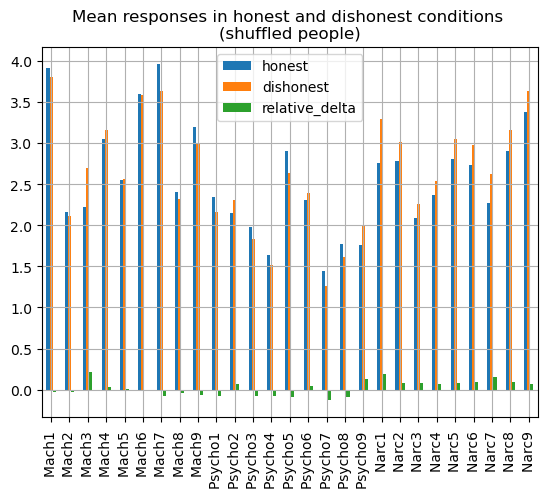

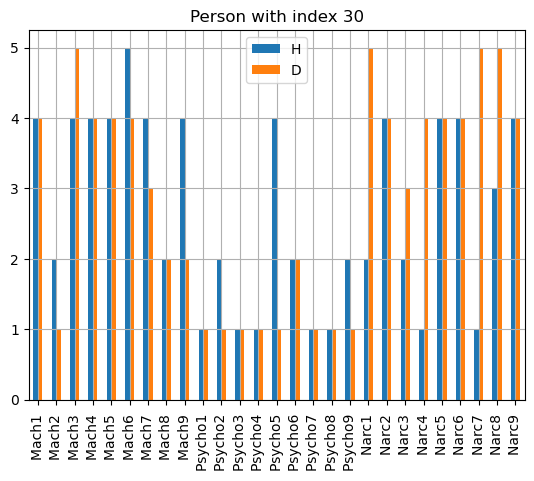

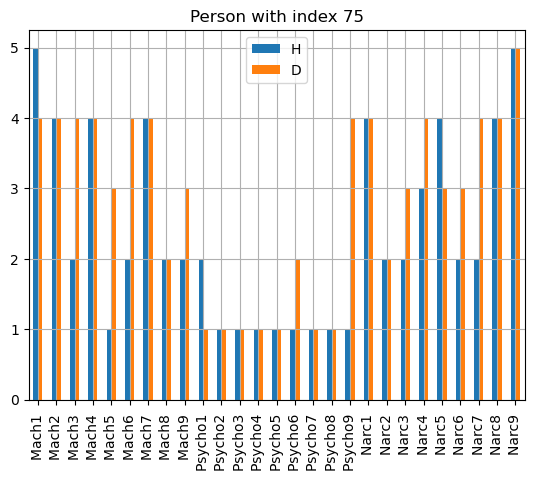

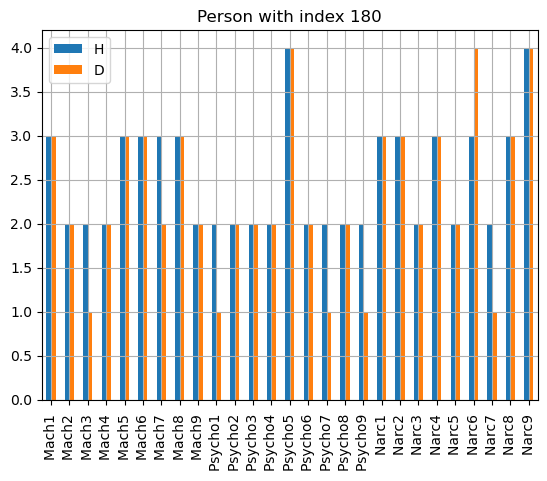

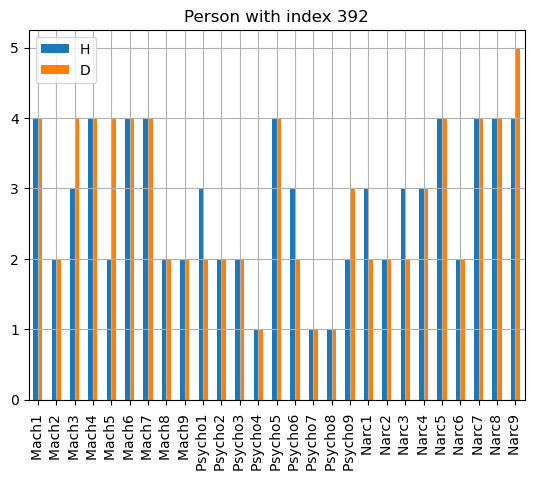

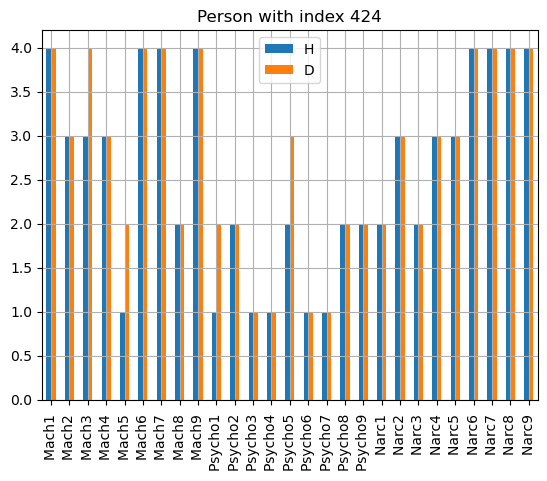

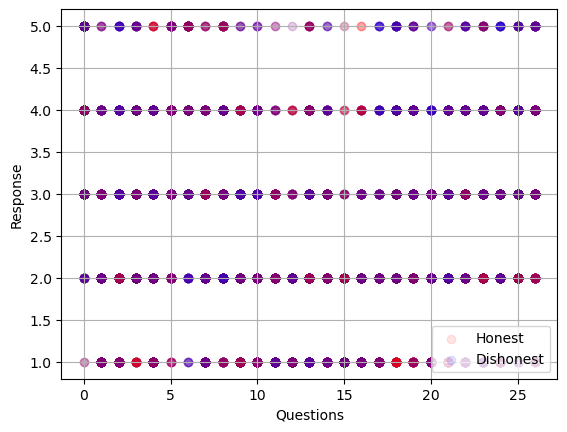

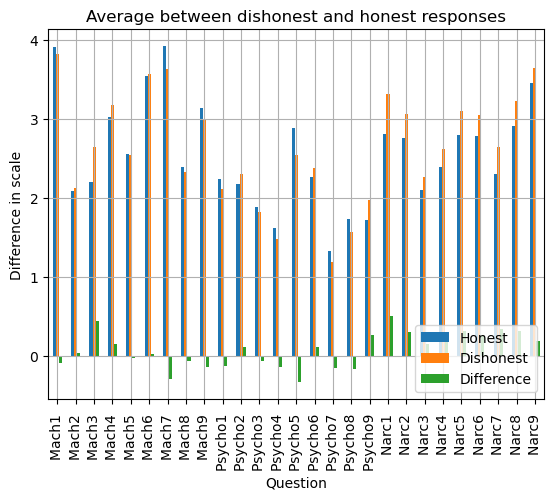

In [54]:
plot_insights(df_train_ji, df_sample_ji)

## Problem statement

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
Fitting Random forest
None
   SVM  LogReg  Perceptron  DecisionTree  GradientBoosting  AdaptiveBoosting  \
0    6       6           6             2                 2                24   
1    2       2          17            18                18                 2   
2   18      18           2             4                 6                 6   
3   17      17          18            13                 9                18   
4   12      15          10            24                24                13   
5   10      14          12            20                15                23   
6   15      10          15             6                17                21   
7   14      16           1             1                13                 9   
8   16      12          14             3                16                14   
9    1       1          16             9                

{'SVM': [[0.7101449275362319,
   0.7124773960216998,
   0.6943942133815552,
   0.6980108499095841,
   0.7070524412296564],
  [0.6330935251798561,
   0.6304347826086957,
   0.6884057971014492,
   0.6884057971014492,
   0.6231884057971014]],
 'LogReg': [[0.6920289855072463,
   0.6980108499095841,
   0.6962025316455697,
   0.6799276672694394,
   0.7070524412296564],
  [0.6402877697841727,
   0.6231884057971014,
   0.7246376811594203,
   0.6666666666666666,
   0.6521739130434783]],
 'Perceptron': [[0.6811594202898551,
   0.6943942133815552,
   0.5623869801084991,
   0.6582278481012658,
   0.6564195298372514],
  [0.6330935251798561,
   0.6159420289855072,
   0.572463768115942,
   0.6304347826086957,
   0.6014492753623188]],
 'DecisionTree': [[1.0, 1.0, 1.0, 1.0, 1.0],
  [0.539568345323741,
   0.47101449275362317,
   0.5507246376811594,
   0.5507246376811594,
   0.5434782608695652]],
 'GradientBoosting': [[0.8822463768115942,
   0.9041591320072333,
   0.8878842676311031,
   0.889692585895117

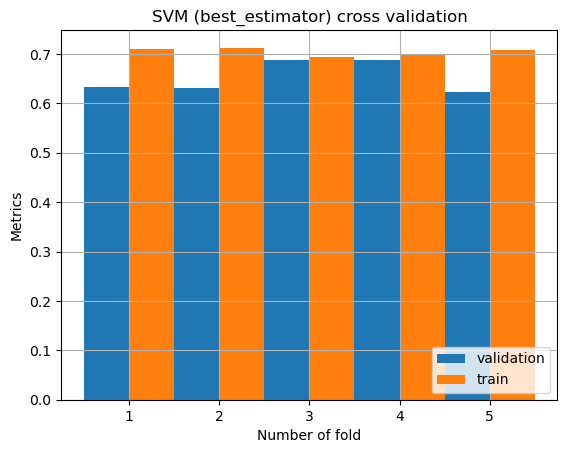

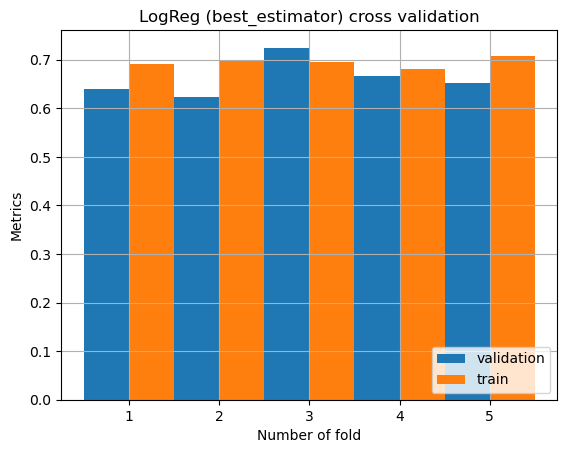

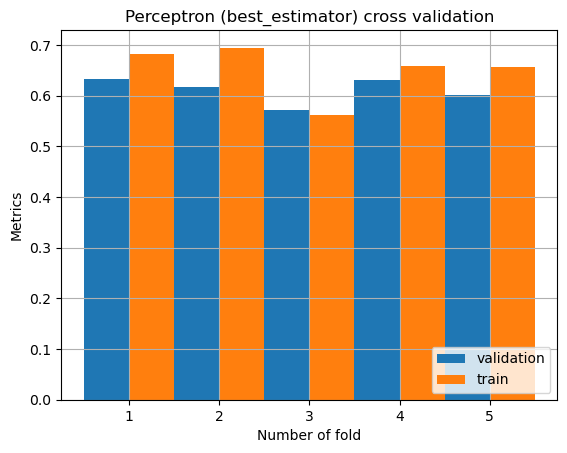

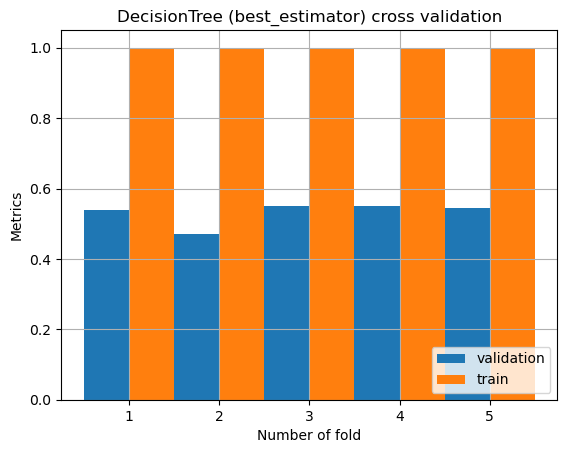

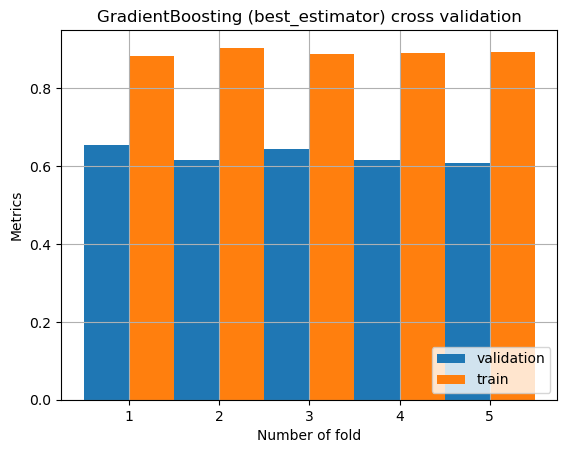

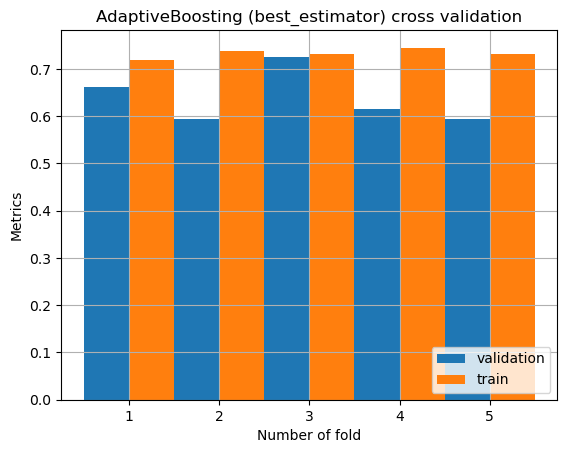

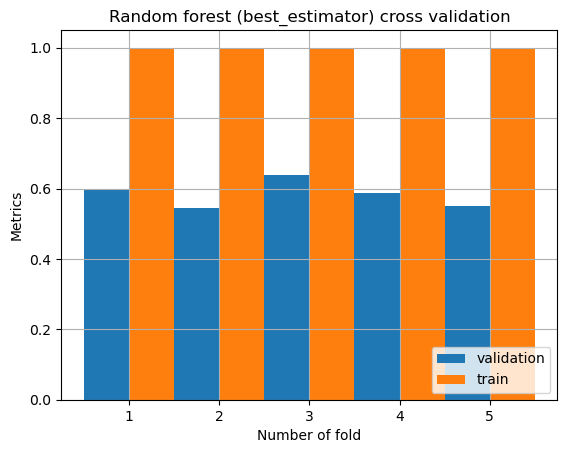

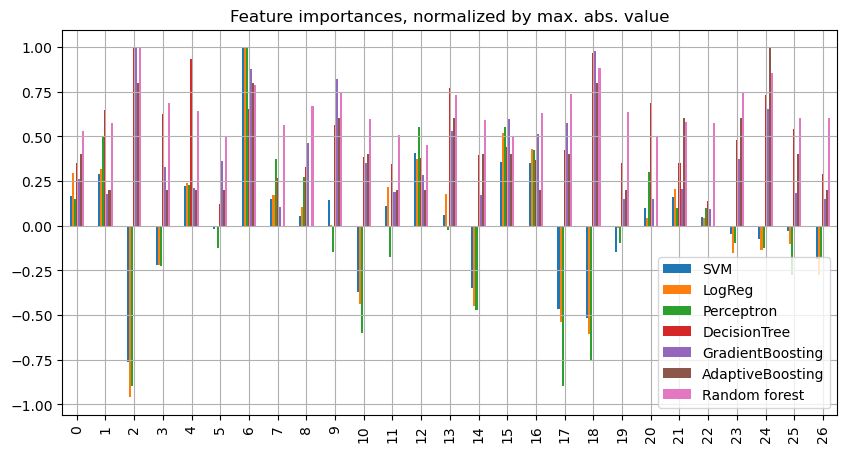

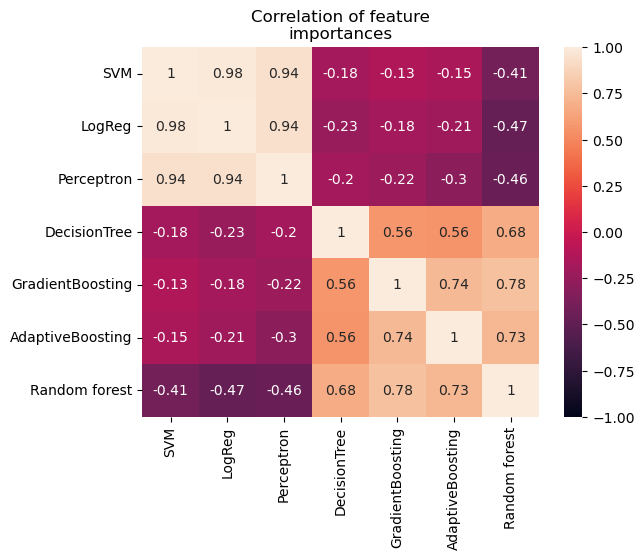

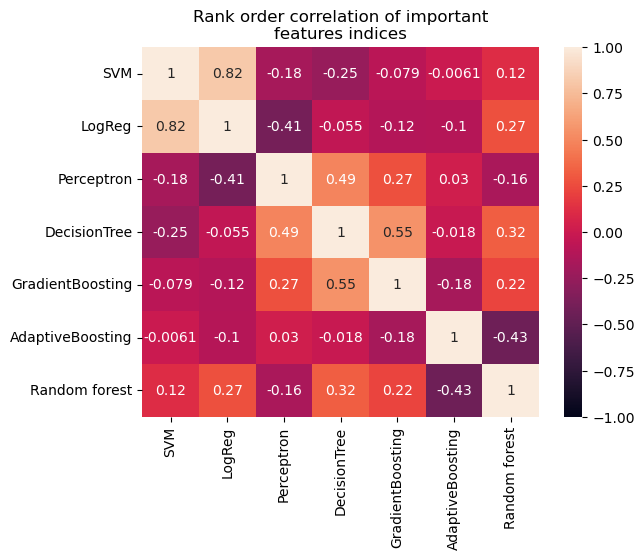

In [55]:
plot_problem_statement(
    df_trainval_ji,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron',
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    figsize_=(10, 5)
)

## Recursive feature elimination

RFE: train model on all features, obtain their importances (Gini index for tree-based models or coefficients for others), eliminate the least important one and repeat.

Each time we do a cross-validation grid search for best hyperparameters.

In [56]:
models_sorted = ['SVM','LogReg','Perceptron','DecisionTree', 'GradientBoosting','AdaptiveBoosting','Random forest']

In [57]:
rfe_models = [m.model for _,m in GRID_SEARCH_MODELS.items()]
rfe_grids = [m.grid_search_param_grid for _,m in GRID_SEARCH_MODELS.items()]
rfe_mnames = [m.name for _,m in GRID_SEARCH_MODELS.items()]
rfe_gridsearch = [GridSearchCV(m, g) for m, g in zip(rfe_models, rfe_grids)]

In [58]:
ji_rfe_ranking, ji_rfe_train_scores, ji_rfe_val_scores = do_rfe(
    X_train=df_train_ji.iloc[:,:-1], y_train=df_train_ji.iloc[:,-1], 
    X_val=df_validation_ji.iloc[:,:-1], y_val=df_validation_ji.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train_ji.columns[:-1]
)

Random forest done
SVM done
LogReg done
Perceptron done
DecisionTree done


KeyboardInterrupt: 

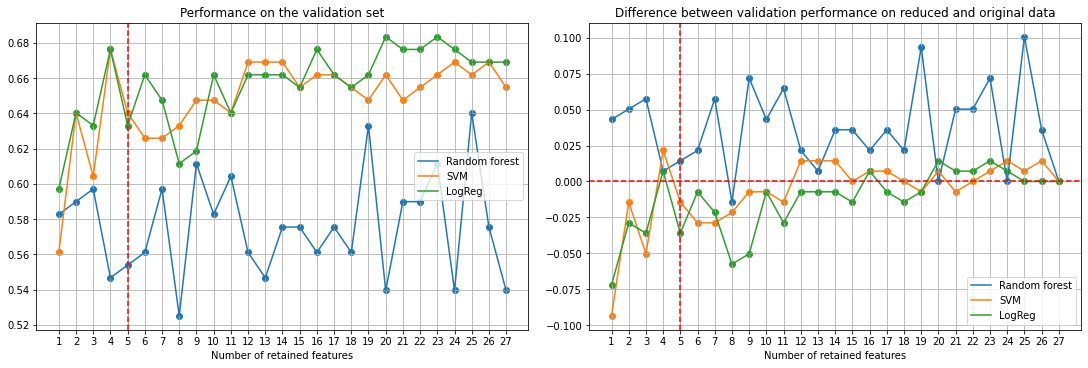

In [60]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(ji_rfe_val_scores.loc[models_to_plot],models_to_plot)

[Text(0.5, 0, 'SVM'),
 Text(1.5, 0, 'LogReg'),
 Text(2.5, 0, 'Perceptron'),
 Text(3.5, 0, 'DecisionTree'),
 Text(4.5, 0, 'GradientBoosting'),
 Text(5.5, 0, 'AdaptiveBoosting'),
 Text(6.5, 0, 'Random forest')]

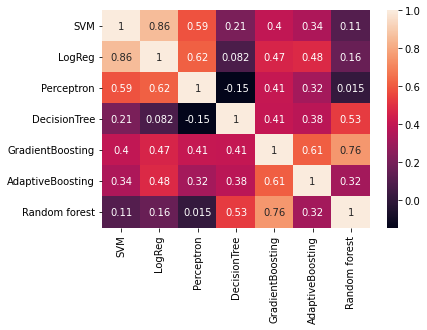

In [100]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(ji_rfe_ranking.loc[m1], ji_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

### Chi squared, mutual information, ANOVA testing

====== VVV RUNNING chi2 VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
====== VVV RUNNING mutual information VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
====== VVV RUNNING ANOVA VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting


C:\Users\79137\AppData\Local\Temp\ipykernel_28612\4231459635.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots()


Fitting AdaptiveBoosting


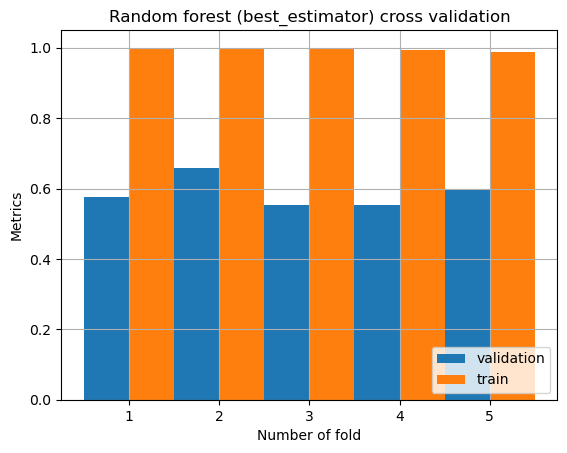

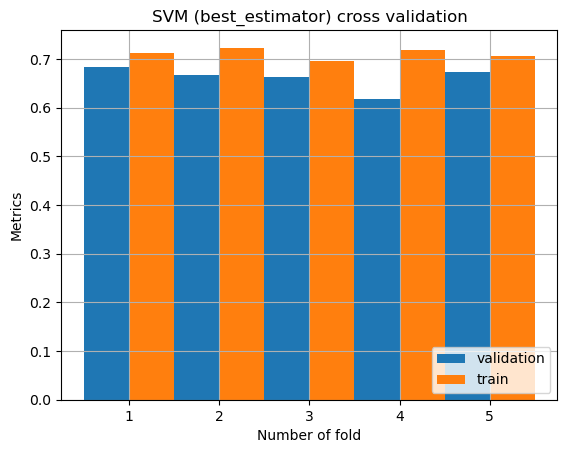

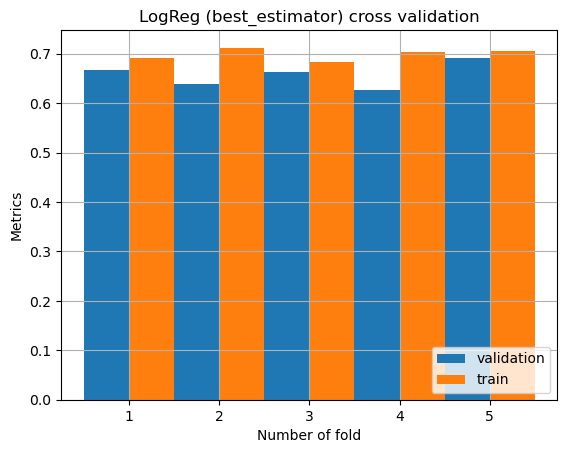

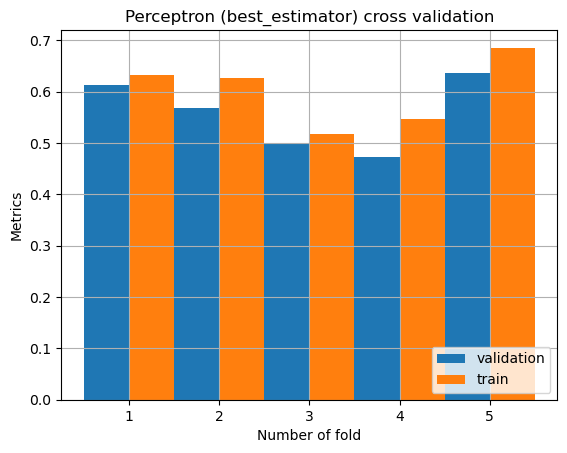

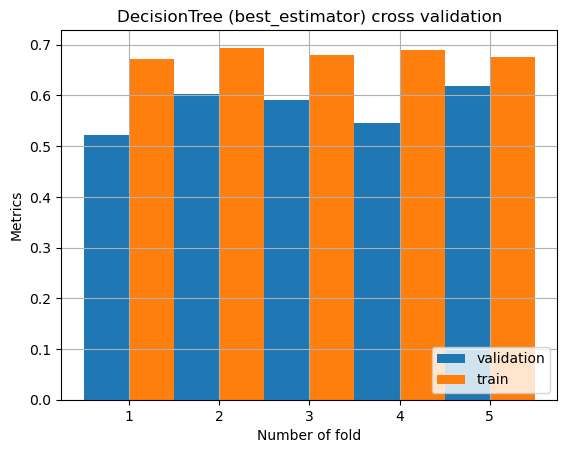

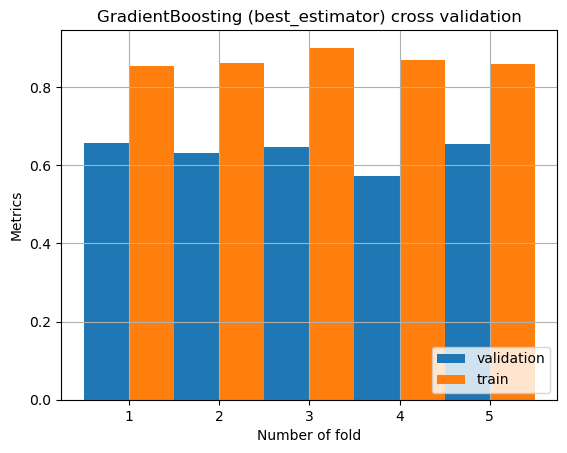

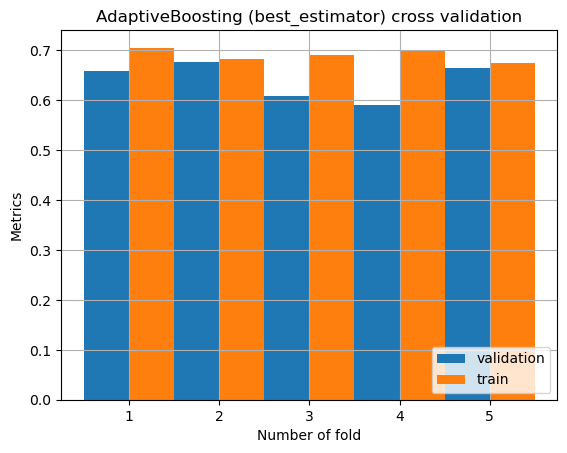

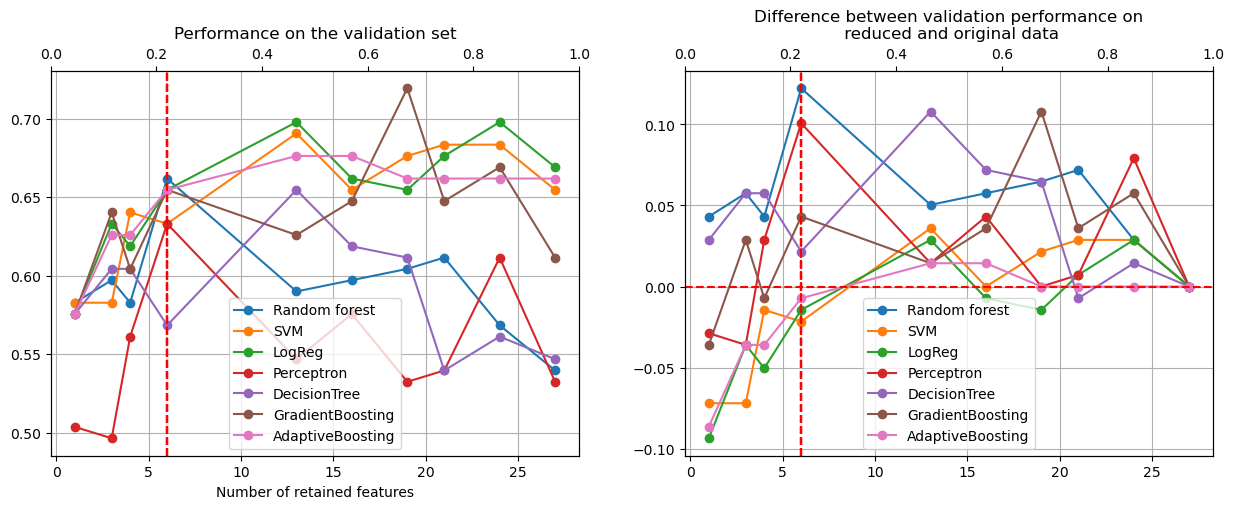

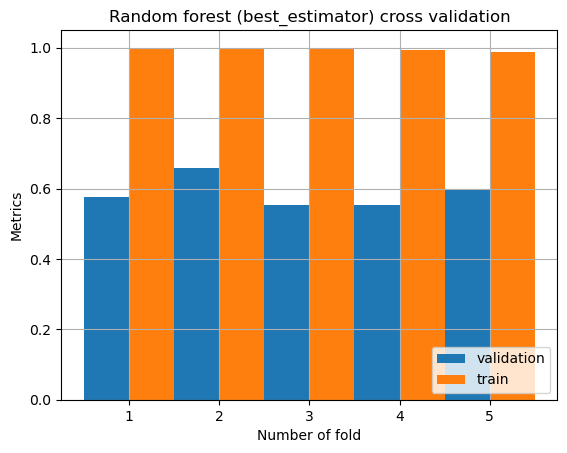

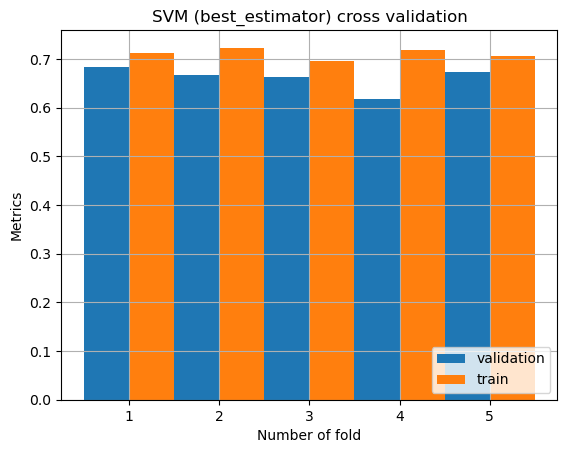

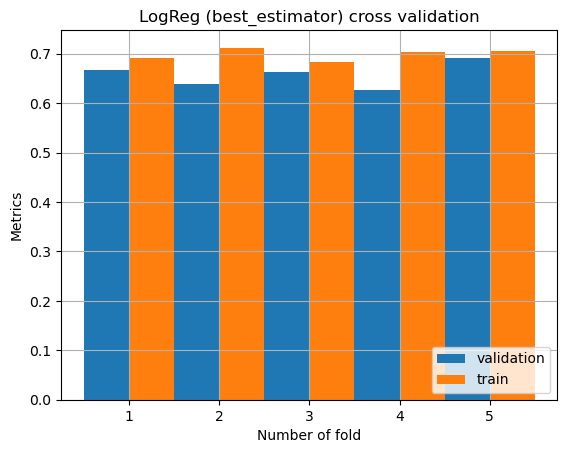

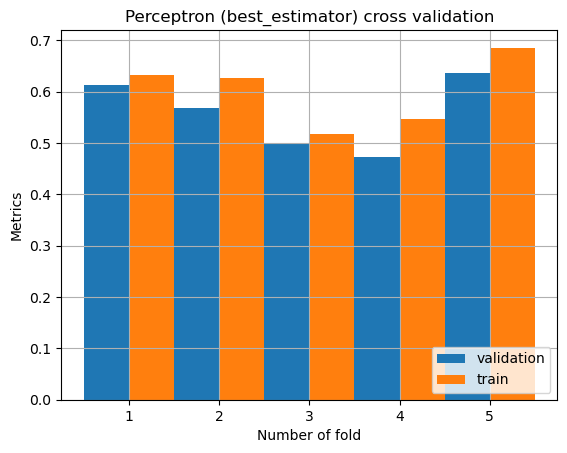

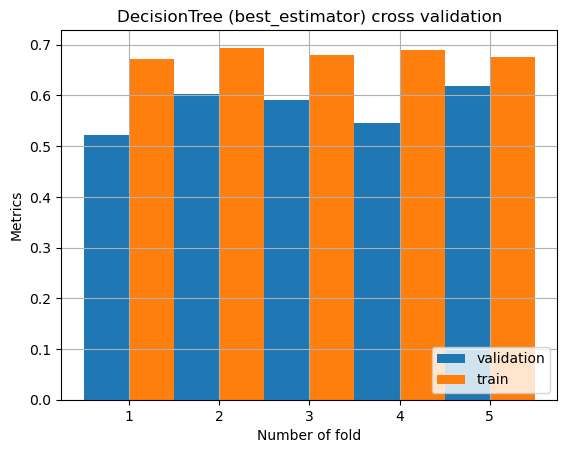

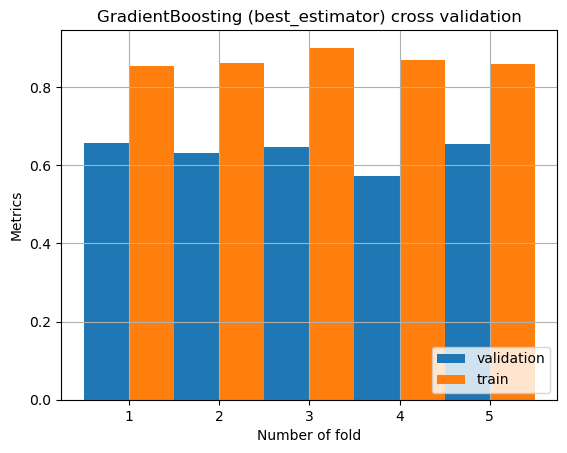

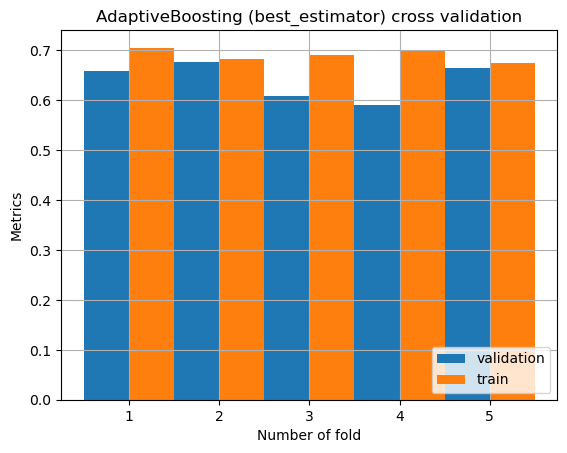

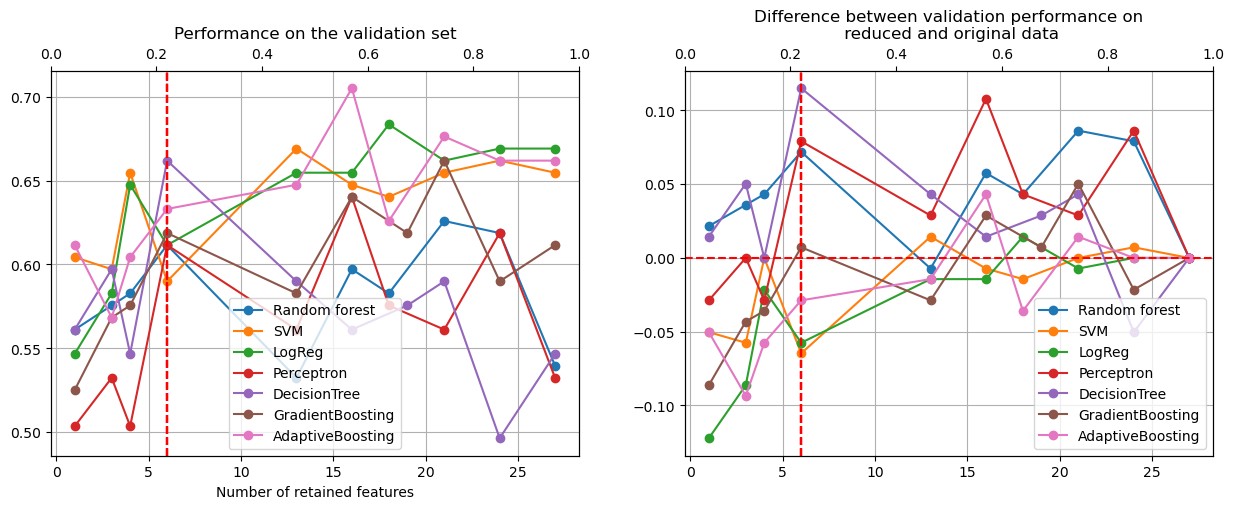

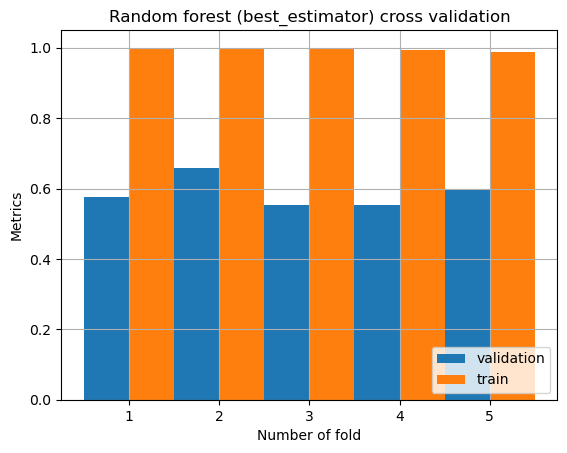

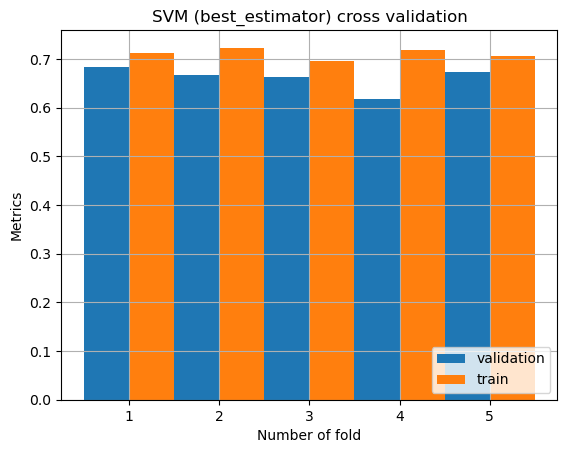

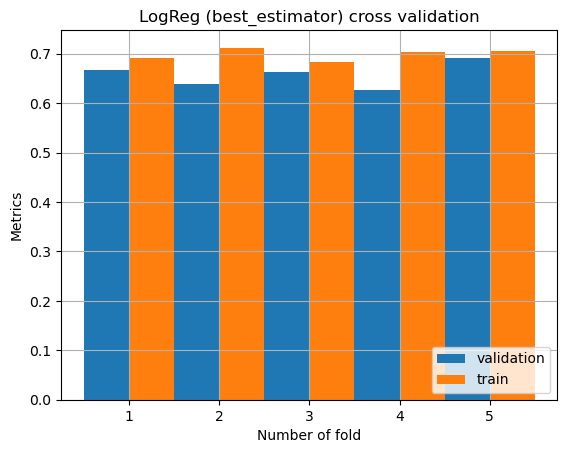

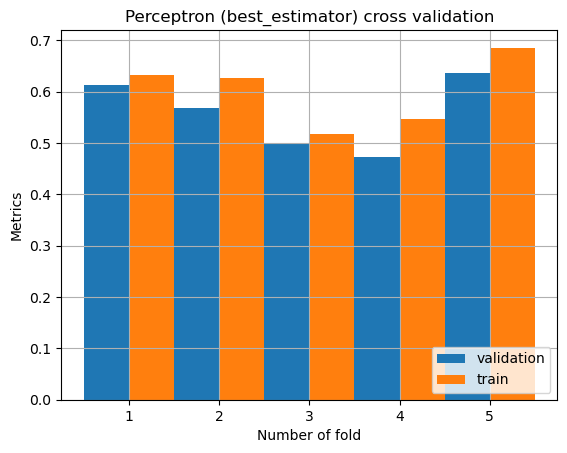

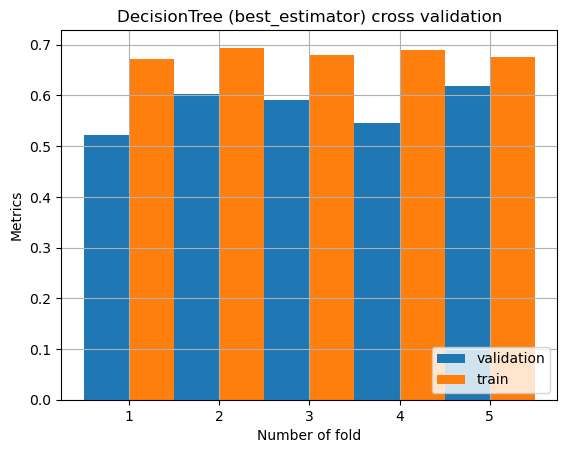

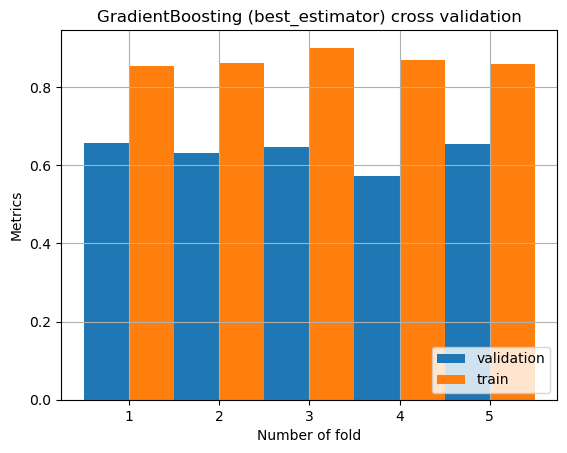

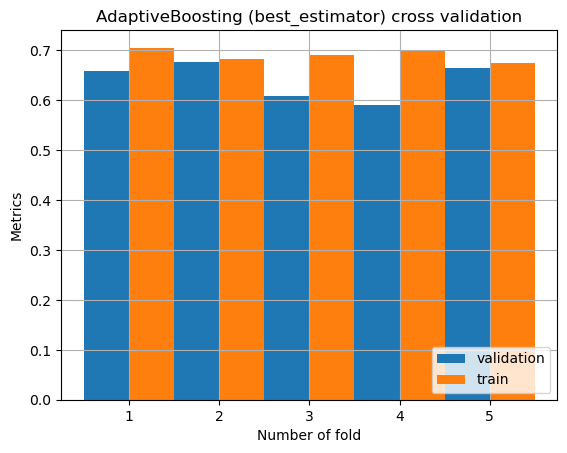

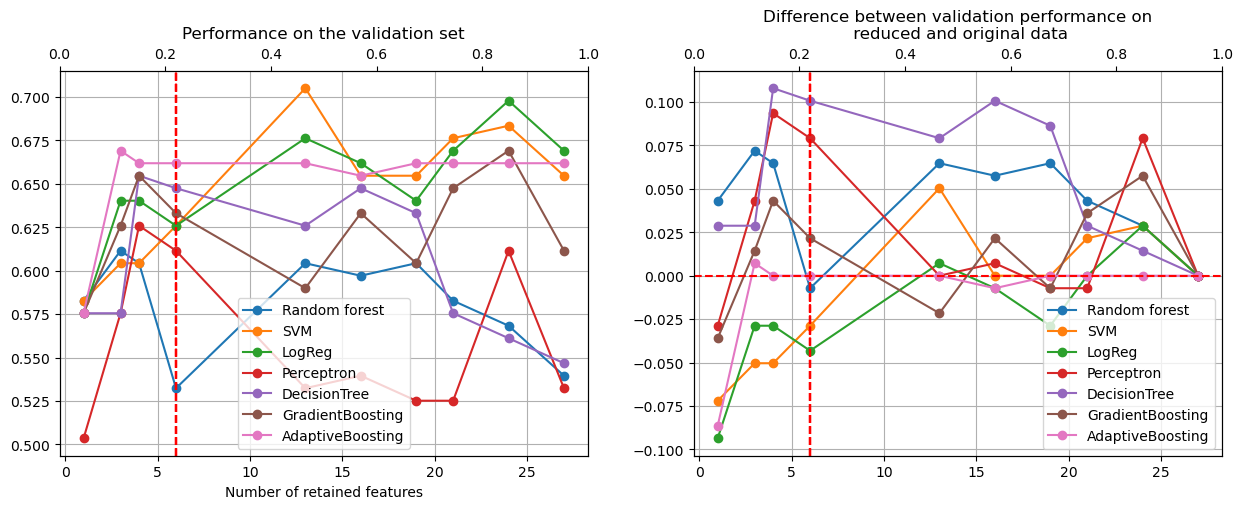

In [59]:
experiment_results_ji = run_feature_selection_experiments(
    df_trainval_ji,
    df_train_ji,
    df_validation_ji,
    df_test_ji,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    metrics_function_=accuracy_score,
    percentiles_=[3, 8, 15, 20, 50, 60, 70, 80, 90, 100],
    models_dict_=GRID_SEARCH_MODELS,
)

## Concordance report

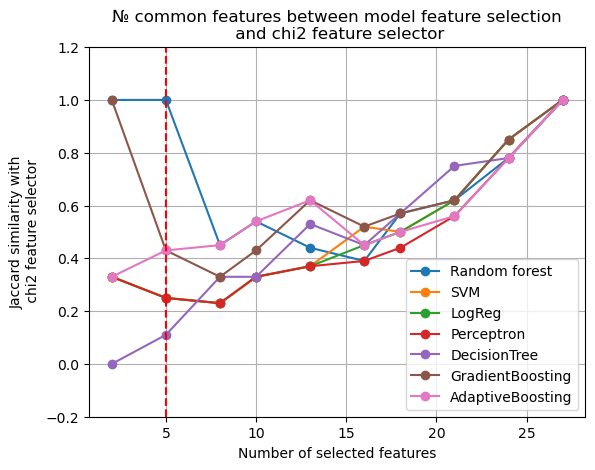

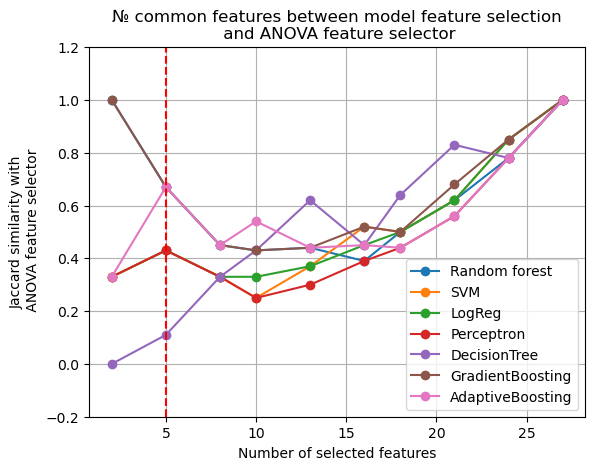

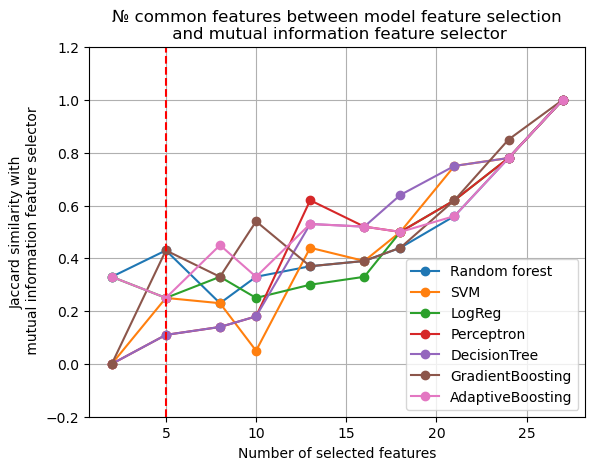

In [60]:
concordance_report(
    percentiles_=np.linspace(0.1, 1, int(1/0.1)),
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results_ji['chi2']['trainval_processed'][0],
        experiment_results_ji['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_ji['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval_ji,
    plot_jaccard_=True
)

## Finding secret features

chi2: Data shape before reduction: (691, 27)
chi2: Data shape after reduction: (691, 5)

            === VVV chi2 VVV ===
            Mean cross-validation accuracy:
            On full data:
            0.6613804608487124,
            On reduced data:
            0.6324053800437911
            Principal features indices:
            [ 2 18 24 23 13]
            Principal features names:
            ['Mach3 ' 'Narc1 ' 'Narc7 ' 'Narc6 ' 'Psycho5 ']
            
ANOVA: Data shape before reduction: (691, 27)
ANOVA: Data shape after reduction: (691, 5)

            === VVV ANOVA VVV ===
            Mean cross-validation accuracy:
            On full data:
            0.6613804608487124,
            On reduced data:
            0.6483057032634763
            Principal features indices:
            [18  2  6 24 23]
            Principal features names:
            ['Narc1 ' 'Mach3 ' 'Mach7 ' 'Narc7 ' 'Narc6 ']
            
mutual information: Data shape before reduction: (691, 27)
mutual inf

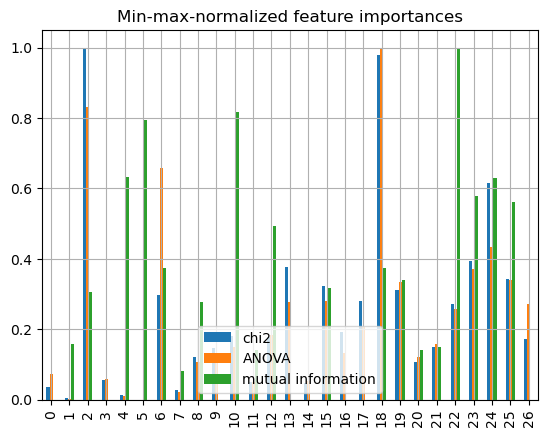

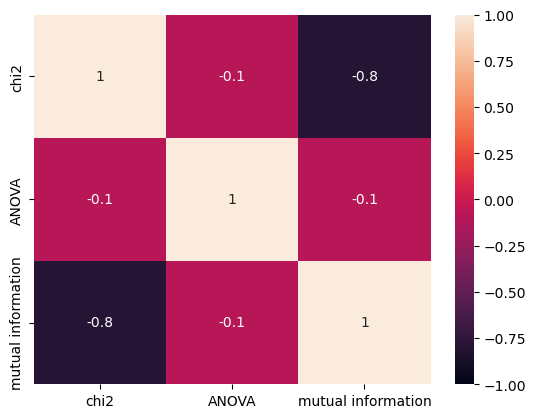

In [61]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results_ji['chi2']['trainval_processed'][0],
    Y_=experiment_results_ji['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results_ji['chi2'][
        'grid_search_results']['LogReg'].best_estimator_,
    df_=df_trainval_ji
)

Median of Mach3  dishonest: Mach3     2.0
dtype: float64
Median of Mach3  honest: Mach3     2.0
dtype: float64
Outliers % honest subset: 0.02
Outliers % dishonest subset: 0.07


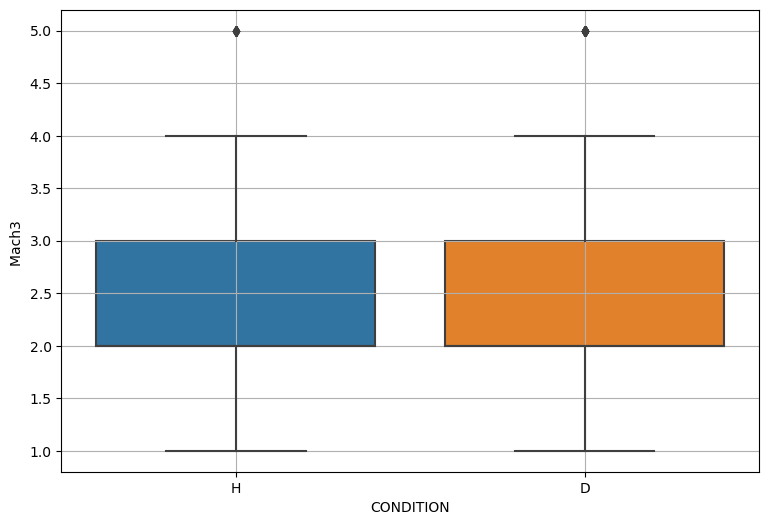

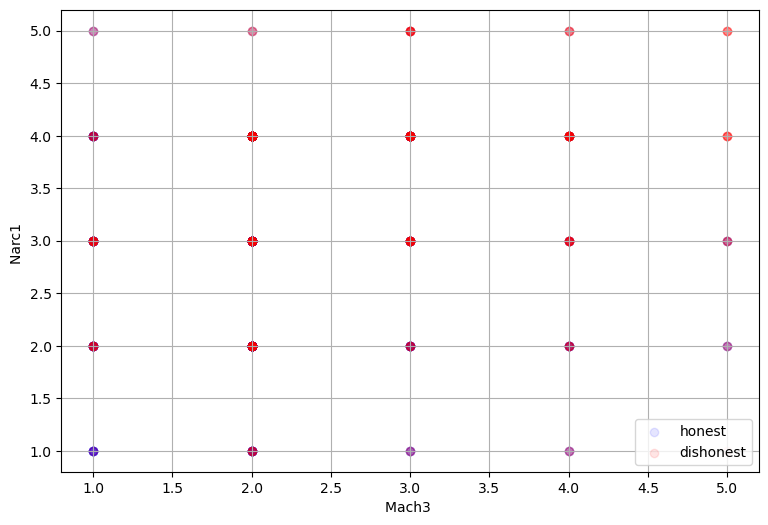

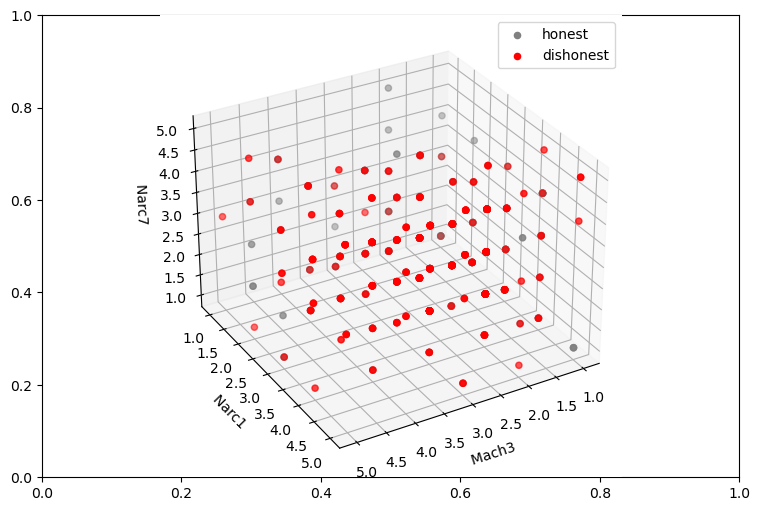

In [62]:
report_outliers(
    df_trainval_ji,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval_ji,
    main_features['chi2'][:3],
    figsize=(9, 6),
    elev=30,
    azim=60
)

## PCA feaure selection Done only using Honest Reviews

In [63]:
dataset_ji.iloc[:int(dataset_ji.shape[0]/2),:(dataset_ji.shape[1] - 1)]

Mach1   Mach2   Mach3   Mach4   Mach5   Mach6   Mach7   Mach8   Mach9   \
0         3       1       1       4       2       3       4       2       4   
1         5       4       2       5       2       5       5       3       2   
2         3       2       2       4       1       4       3       2       2   
3         2       4       4       3       2       4       3       3       2   
4         4       3       1       1       2       1       2       5       2   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
427       4       1       4       3       3       4       4       3       5   
428       5       2       2       2       2       4       4       2       4   
429       4       2       2       3       3       3       4       2       4   
430       4       2       4       4       4       4       4       4       3   
431       5       1       2       4       4       5       5       1       3   

     Psycho1   ...  Psycho9   Narc1   Narc2   Narc3   Narc4   Narc5   Narc6   \
0           2  ...         1       1       1       2       1       2       1   
1           2  ...         2       2       3       1       1       3       2   
2           2  ...         2       2       2       2       1       2       1   
3           2  ...         3       5       4       2       2       4       4   
4           3  ...         5       4       3       1       1       5       1   
..        ...  ...       ...     ...     ...     ...     ...     ...     ...   
427         3  ...         1       1       1       1       1       3       3   
428         2  ...         2       3       3       3       3       3       3   
429         4  ...         2       3       2       2       2       2       2   
430         3  ...         1       2       2       1       1       4       2   
431         2  ...         1       2       3       2       2       3       2   

     Narc7   Narc8   Narc9   
0         1       2       2  
1         1       2       3  
2         3       3       3  
3         4       4       4  
4         3       3       2  
..      ...     ...     ...  
427       1       3       4  
428       2       4       3  
429       2       4       4  
430       1       2       4  
431       1       2       4  

[432 rows x 27 columns]

In [65]:
selected_features, selected_features_20, df = perform_pca_feature_selection(dataset_ji)

### Training models based on 100% features selected using PCA

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting Random forest
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
False
   SVM  LogReg  Perceptron  Random forest  DecisionTree  GradientBoosting  \
0    5       5          12              5             4                 5   
1   15      15           8             13             5                13   
2    0       0           0              1             7                15   
3   12      12          13              3             3                 1   
4   10      10          15              8             2                12   
5   17      14           5             12            14                10   
6    9       9          17             16            13                 3   

   AdaptiveBoosting  
0                15  
1                 5  
2                 1  
3                17  
4                13  
5                 2  
6                 0  


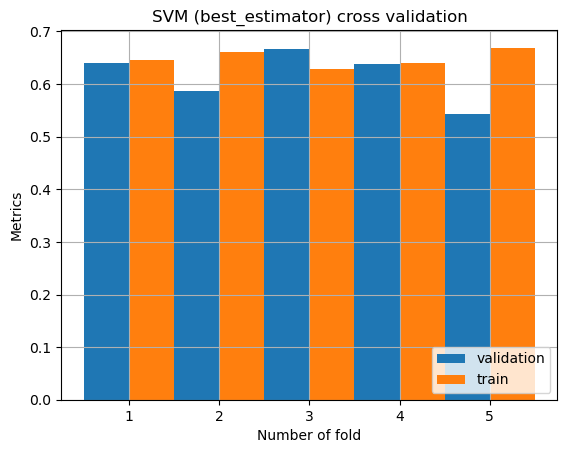

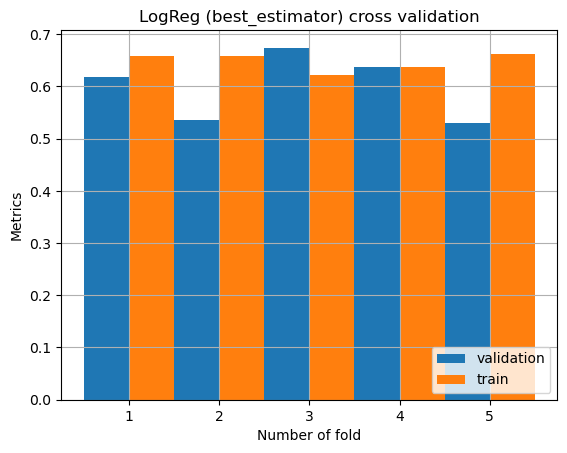

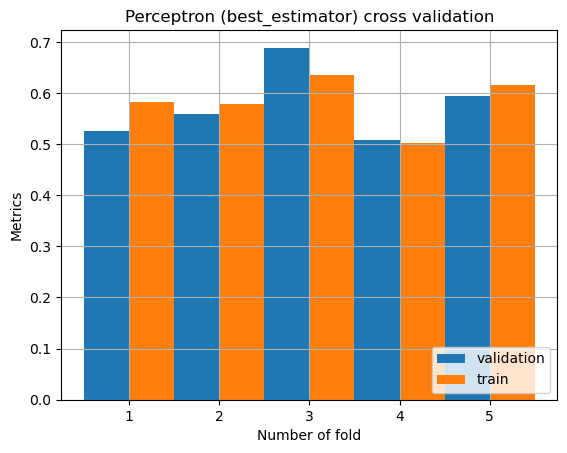

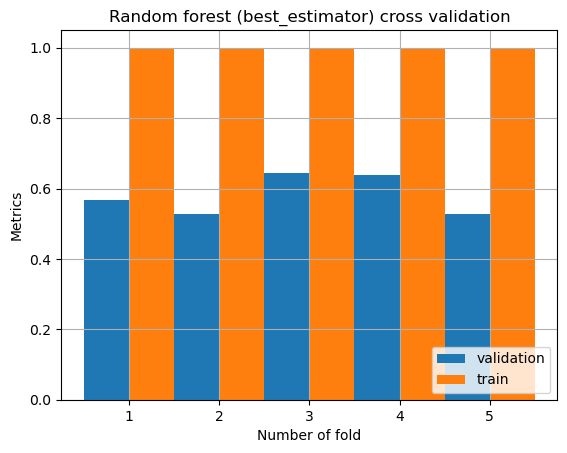

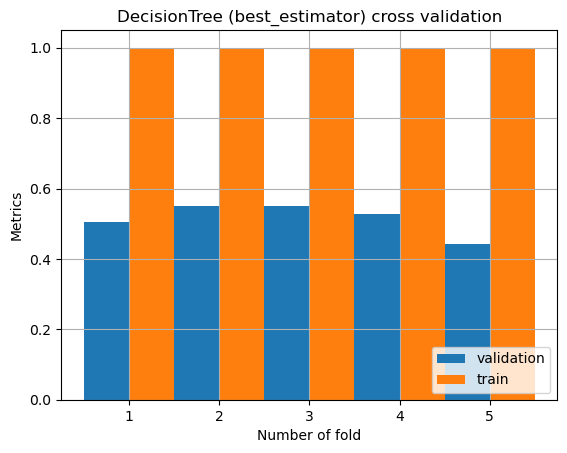

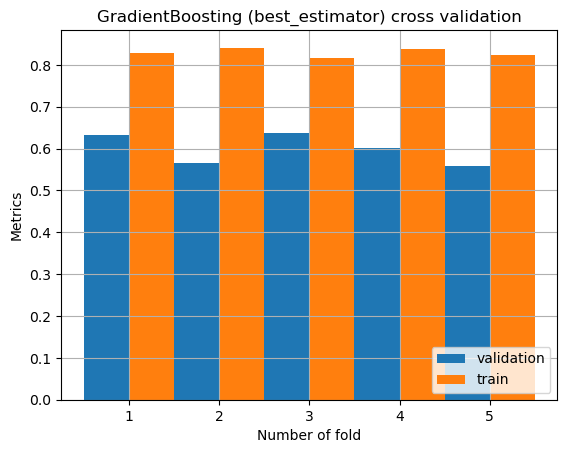

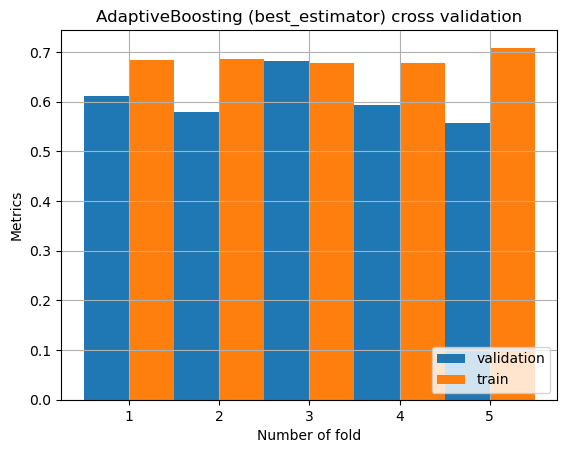

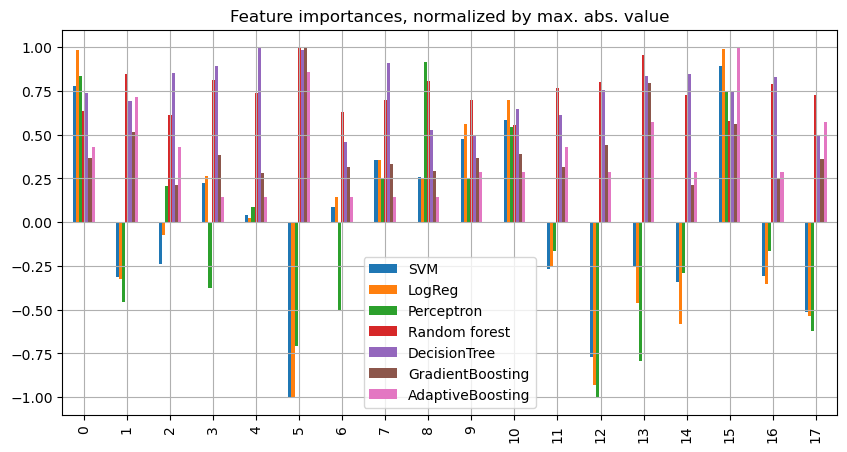

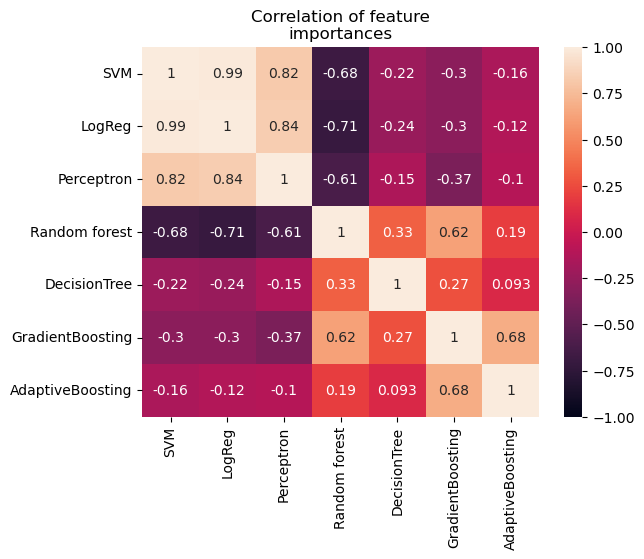

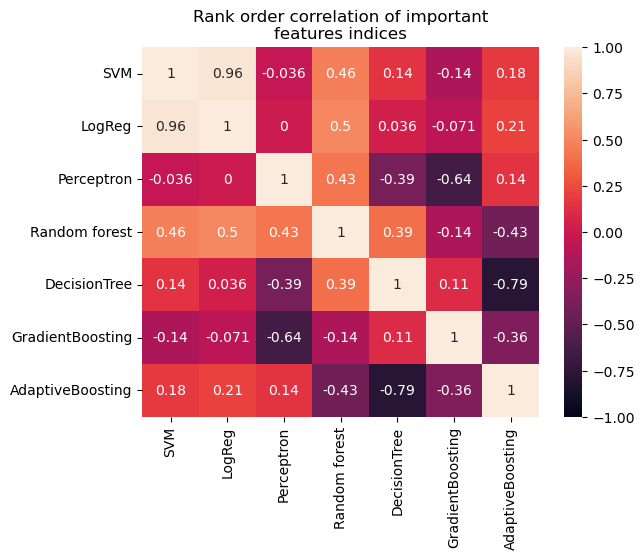

In [66]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_1.1'] = copy.copy(lst) 
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval_ji.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [68]:
final_full = results(pca_full)
print(final_full)

{'SVM': [0.65, 0.62], 'LogReg': [0.65, 0.6], 'Perceptron': [0.58, 0.57], 'Random forest': [1.0, 0.58], 'DecisionTree': [1.0, 0.52], 'GradientBoosting': [0.83, 0.6], 'AdaptiveBoosting': [0.69, 0.6]}


### Training models based on 20% features selected using PCA

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting Random forest
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
False
   SVM  LogReg  Perceptron  Random forest  DecisionTree  GradientBoosting  \
0    1       1           2              0             0                 4   
1    2       3           1              2             2                 1   

   AdaptiveBoosting  
0                 4  
1                 1  


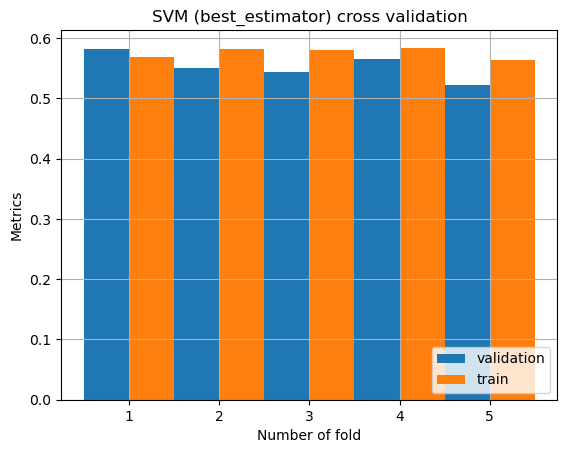

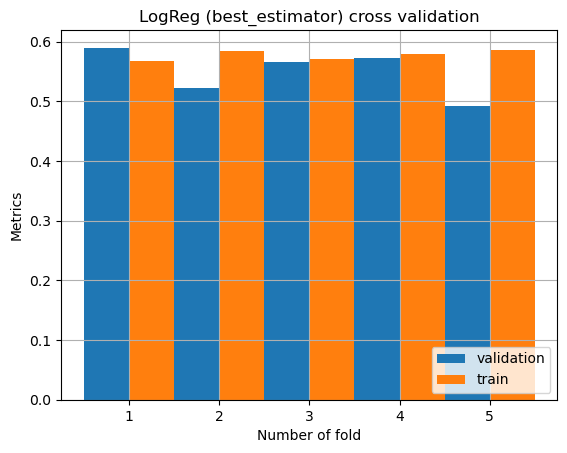

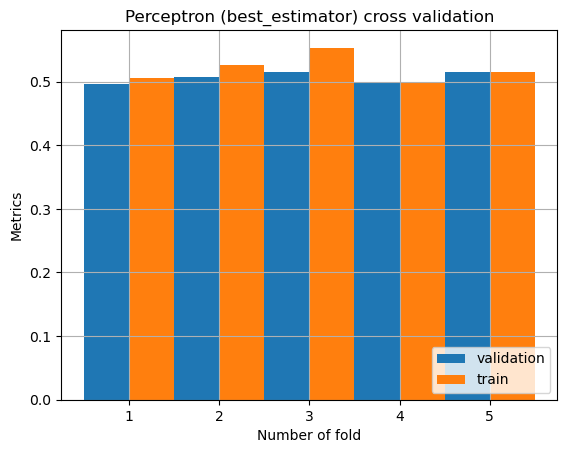

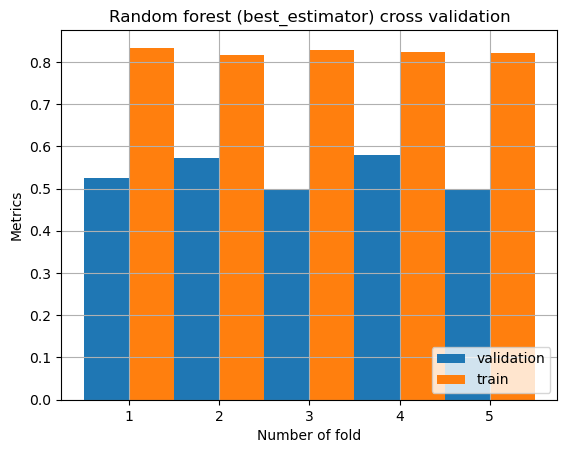

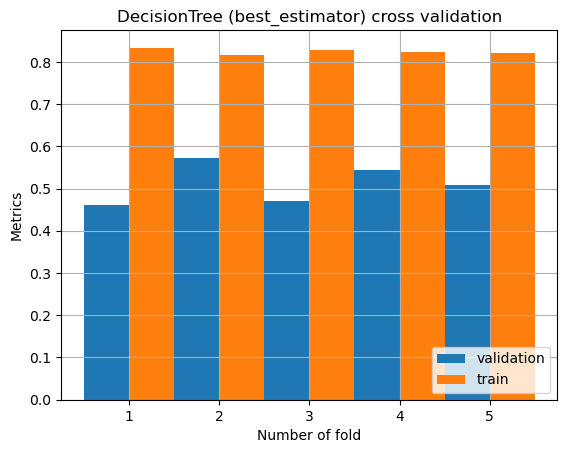

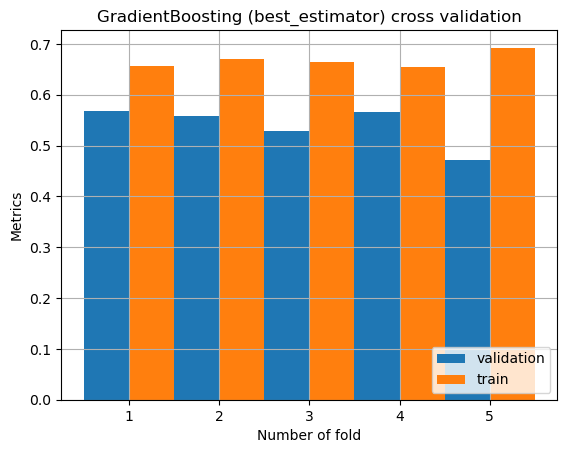

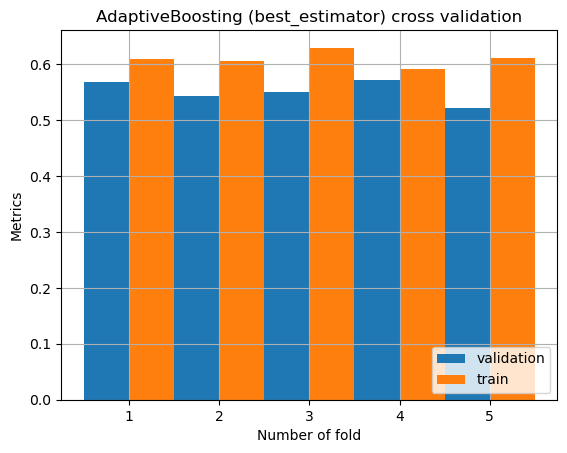

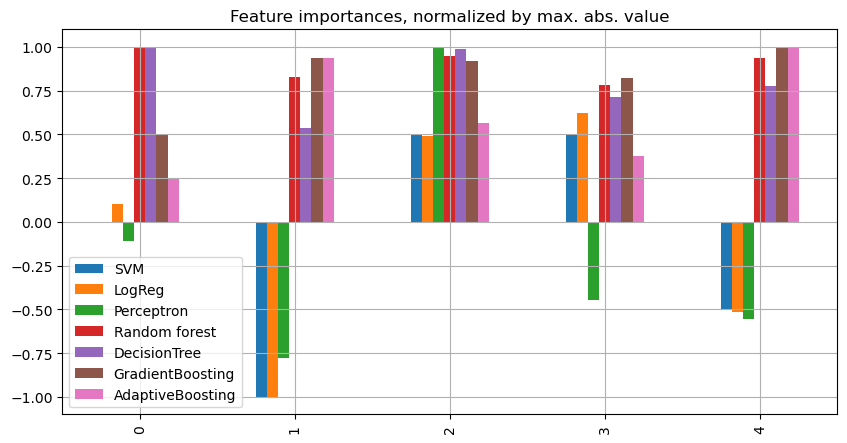

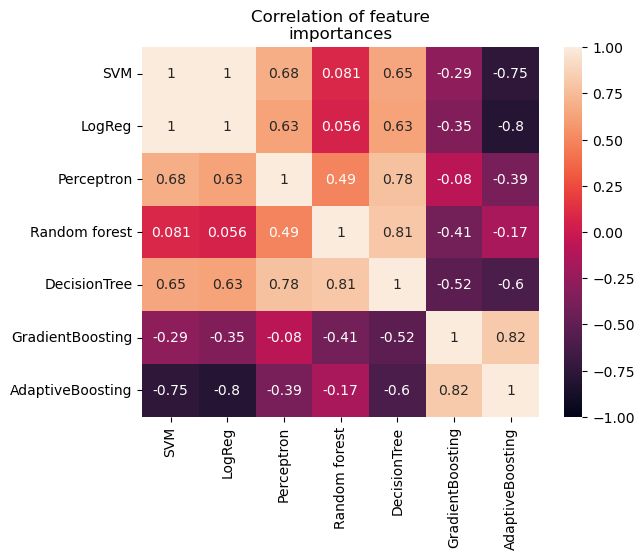

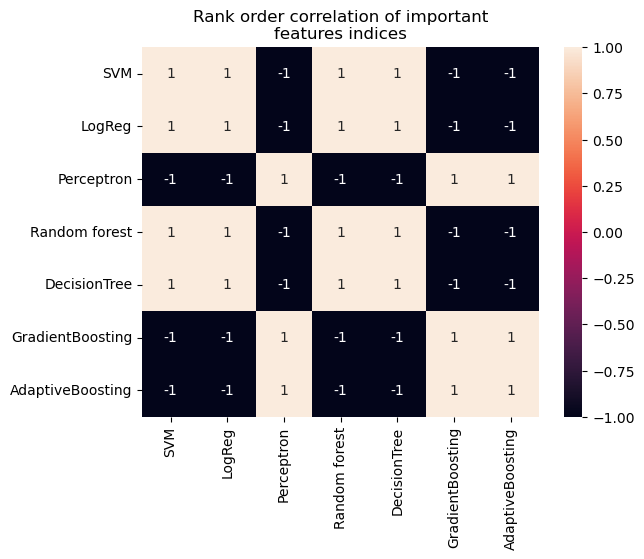

In [69]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_1.1'] = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval_ji.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [70]:
final_20 = results(pca_20)
print(final_20)

{'SVM': [0.58, 0.55], 'LogReg': [0.58, 0.55], 'Perceptron': [0.52, 0.51], 'Random forest': [0.82, 0.54], 'DecisionTree': [0.82, 0.51], 'GradientBoosting': [0.67, 0.54], 'AdaptiveBoosting': [0.61, 0.55]}


## Factor Analysis

In [71]:
no_factors = dataset_ji.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset_ji)

                F1        F2        F3        F4        F5        F6  \
Mach1    -0.050158  0.718634  0.103072 -0.036625 -0.036251  0.043159   
Mach2     0.107108  0.068139  0.127421  0.028743  0.169208  0.111076   
Mach3     0.032159 -0.015757  0.159996  0.098362  0.734900 -0.024182   
Mach4     0.052713  0.312705  0.000672  0.075634  0.220001  0.080834   
Mach5    -0.065355  0.216900  0.365521  0.148870  0.240327  0.216678   
Mach6    -0.030904  0.201164  0.021428  0.065014  0.050446  0.018964   
Mach7    -0.013964  0.747727  0.012263  0.041542  0.029595  0.097269   
Mach8    -0.061233  0.056914  0.080091  0.020941  0.127112  0.154537   
Mach9    -0.043382  0.207451  0.088879  0.018039  0.101109  0.142775   
Psycho1   0.057445  0.086544  0.281629  0.039910  0.036370  0.256988   
Psycho2   0.152607 -0.016551  0.079363  0.060811 -0.037447  0.026574   
Psycho3  -0.049653  0.071445  0.720627  0.083372  0.113979  0.136472   
Psycho4  -0.003117 -0.058238  0.181217  0.135030  0.045206  0.14

In [72]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset_ji,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting Random forest
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
False
   SVM  LogReg  Perceptron  Random forest  DecisionTree  GradientBoosting  \
0    2       2           3              3            14                14   
1    3       3           2             14            11                 3   
2   14      14          14              2             3                 2   
3    5       5           5              9             6                 9   
4   20       7           7             24            16                 6   
5   18      18          19              6             5                 7   
6   19      19          16              5            10                24   
7   16      16          20              8             2                 5   
8    7      20          18             15            24                15   
9    0       0          15             12             8                16   

   Adap

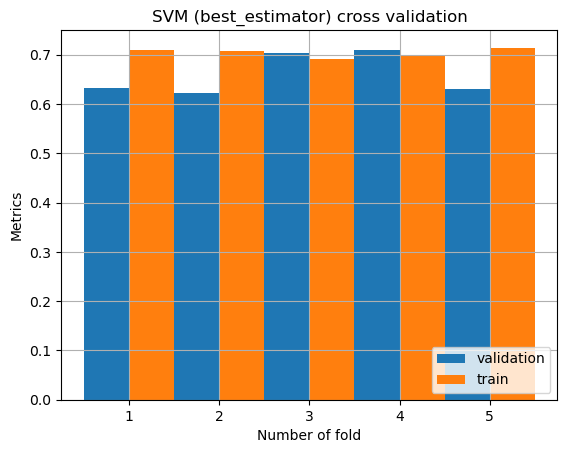

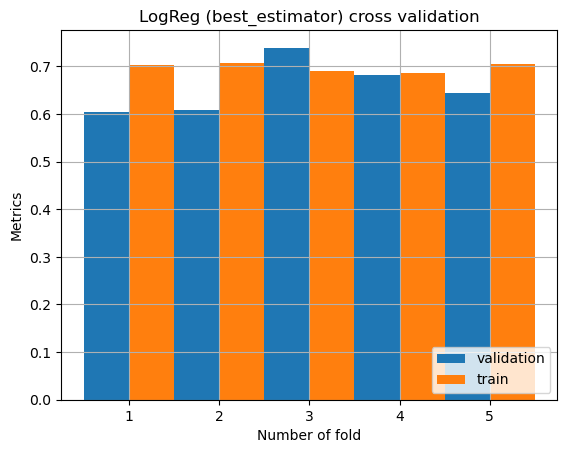

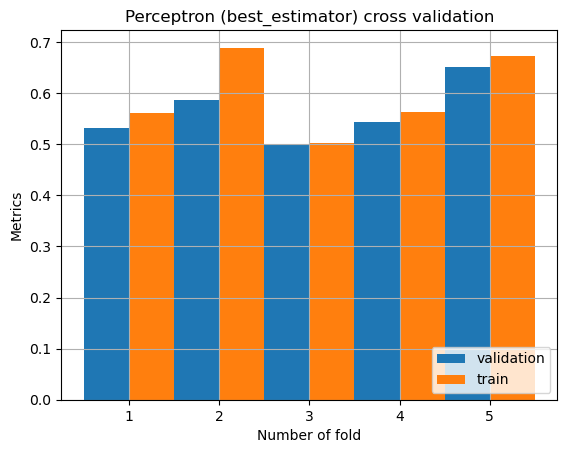

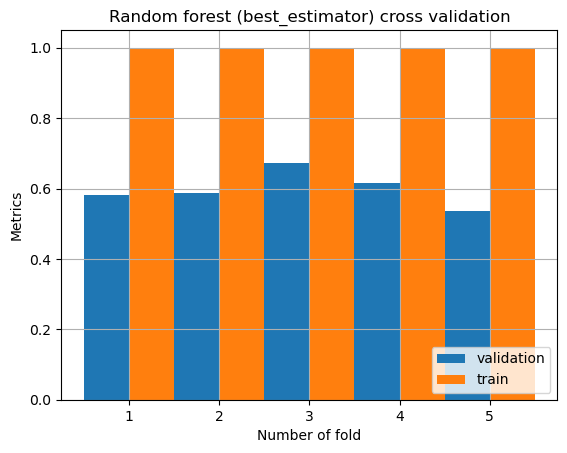

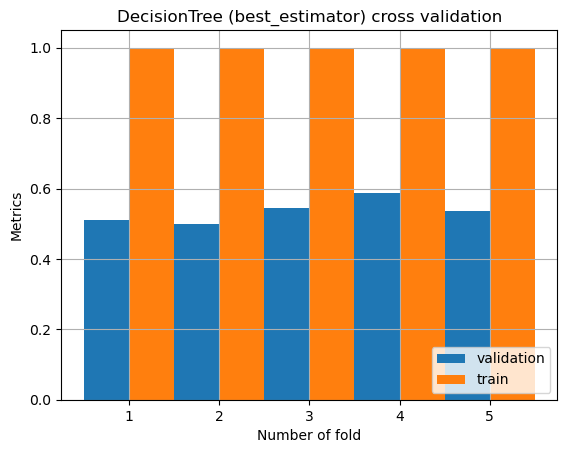

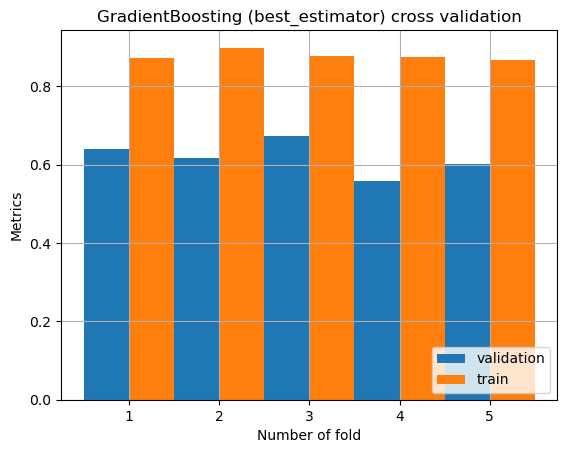

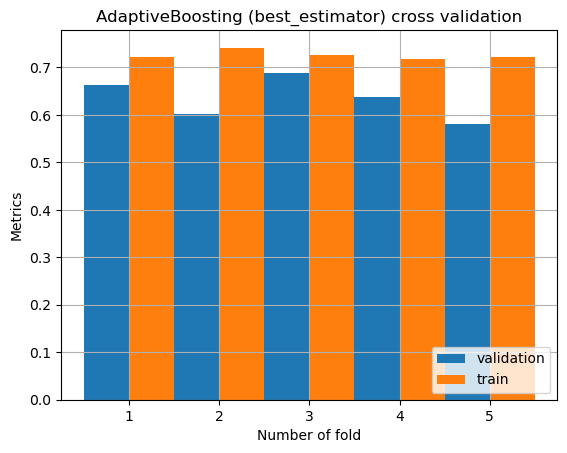

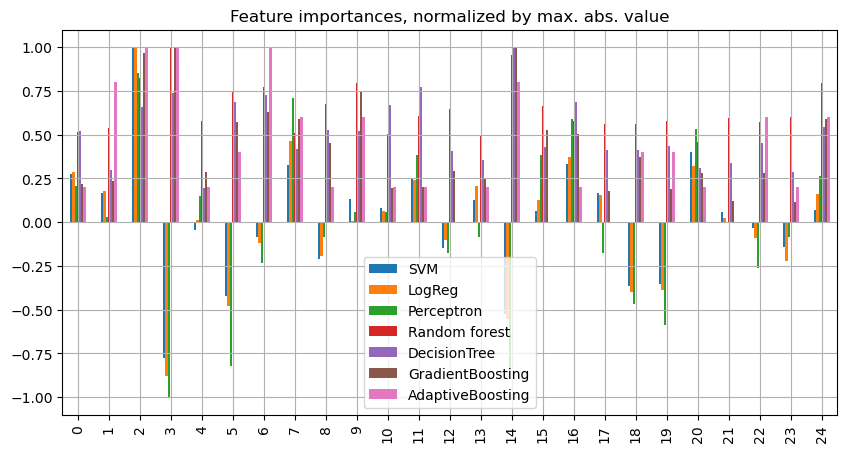

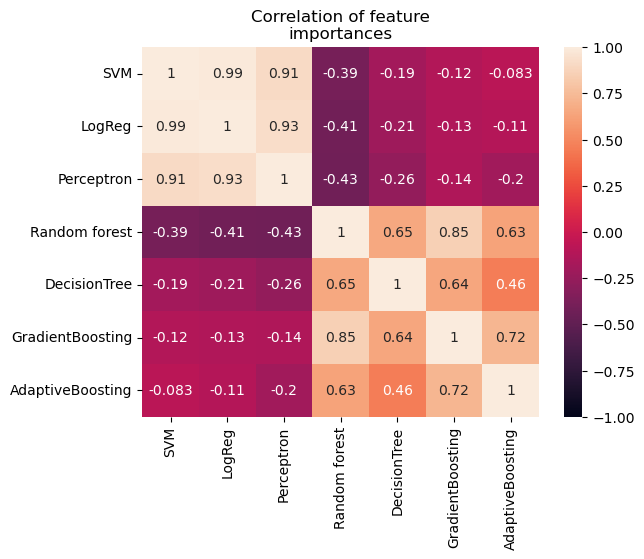

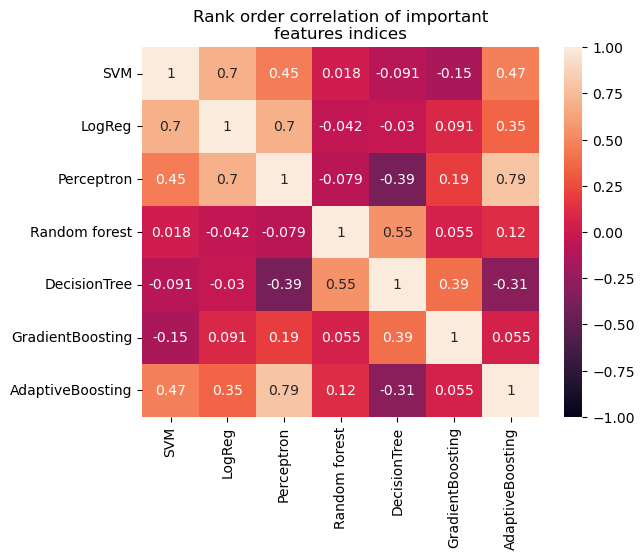

In [73]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_1.1'] = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval_ji.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [74]:
final_full = results(fa_full)
print(final_full)

{'SVM': [0.7, 0.66], 'LogReg': [0.7, 0.66], 'Perceptron': [0.6, 0.56], 'Random forest': [1.0, 0.6], 'DecisionTree': [1.0, 0.54], 'GradientBoosting': [0.88, 0.62], 'AdaptiveBoosting': [0.73, 0.63]}


### Training models based on 20% features selected using FA

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting Random forest
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
False
   SVM  LogReg  Perceptron  Random forest  DecisionTree  GradientBoosting  \
0    2       1           2              2             0                 2   
1    1       2           1              5             2                 1   

   AdaptiveBoosting  
0                 5  
1                 2  


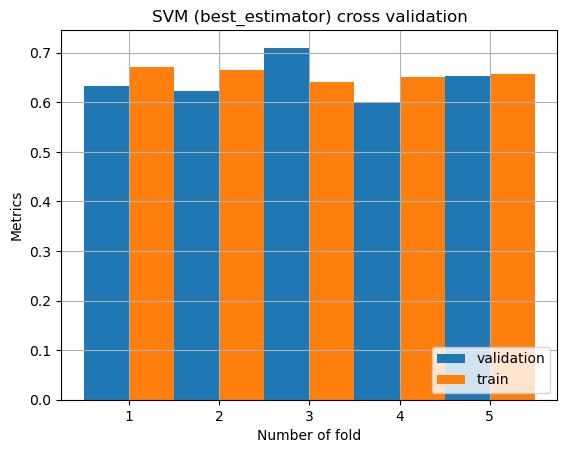

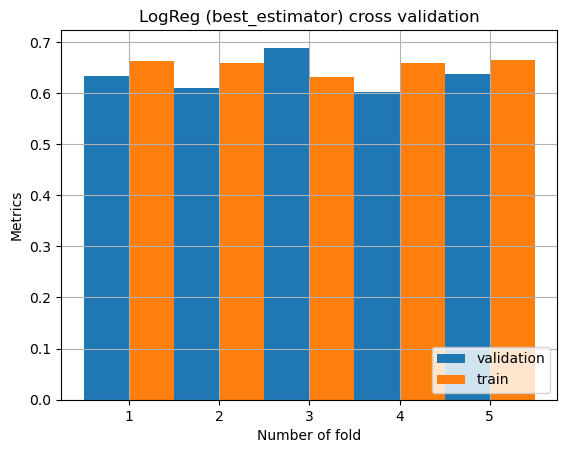

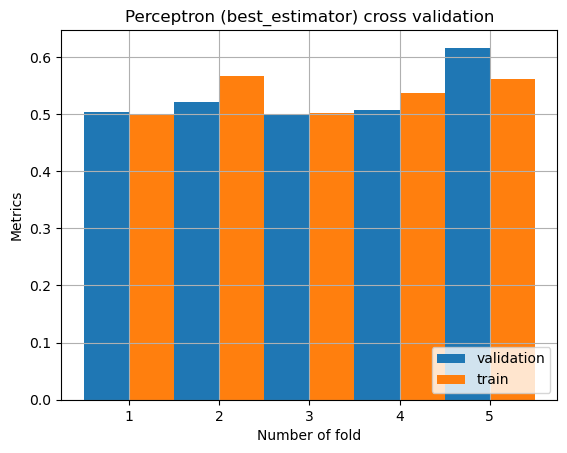

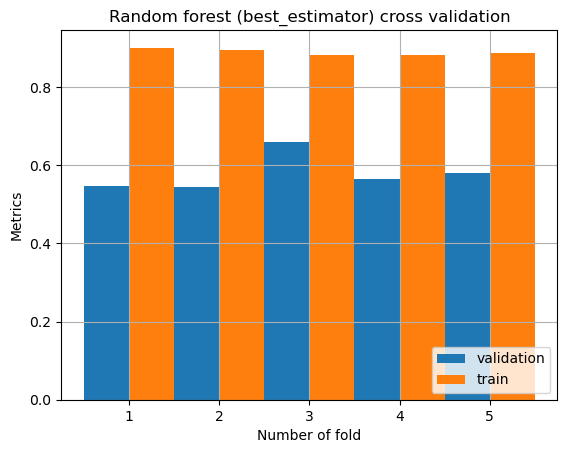

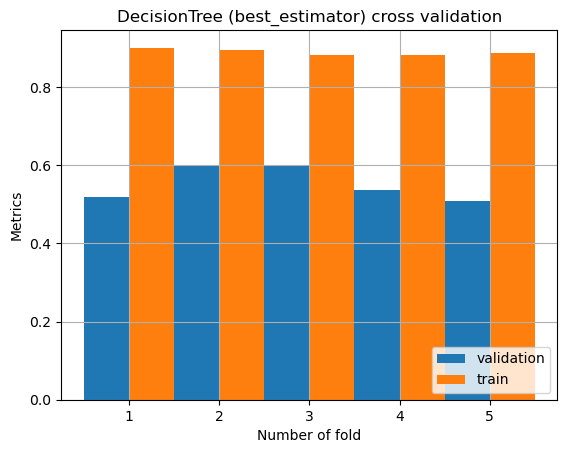

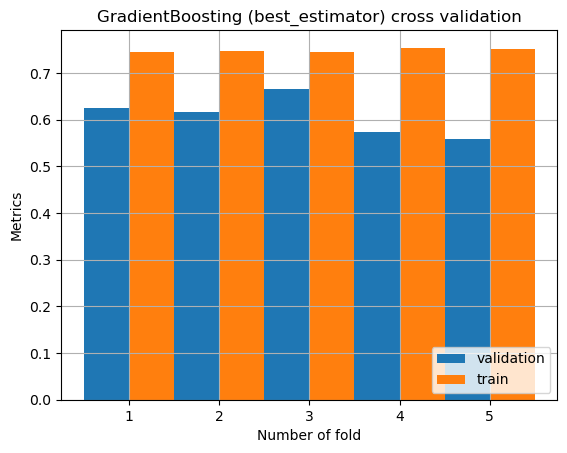

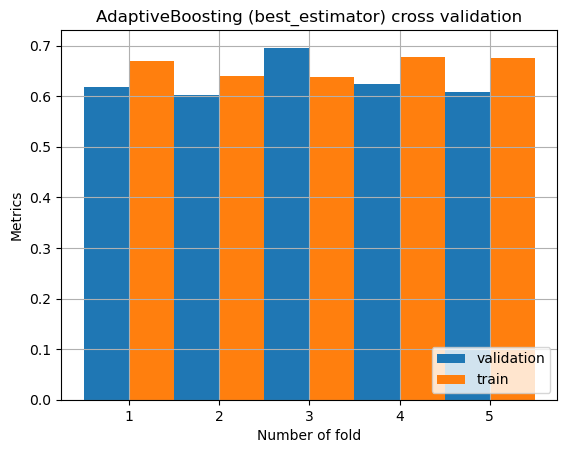

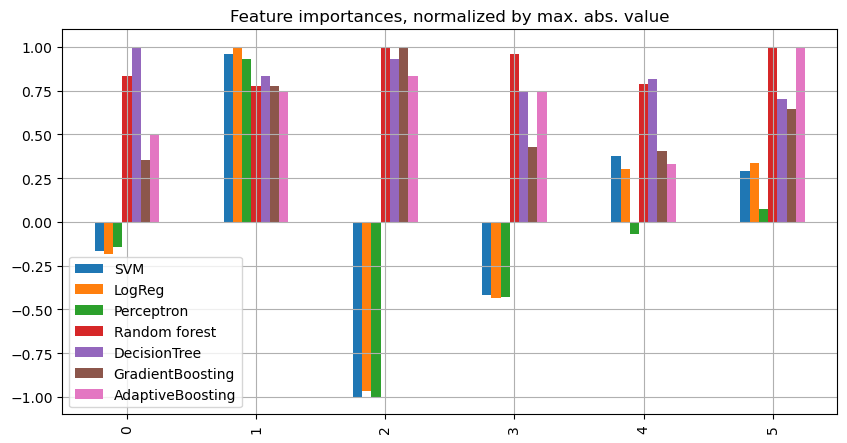

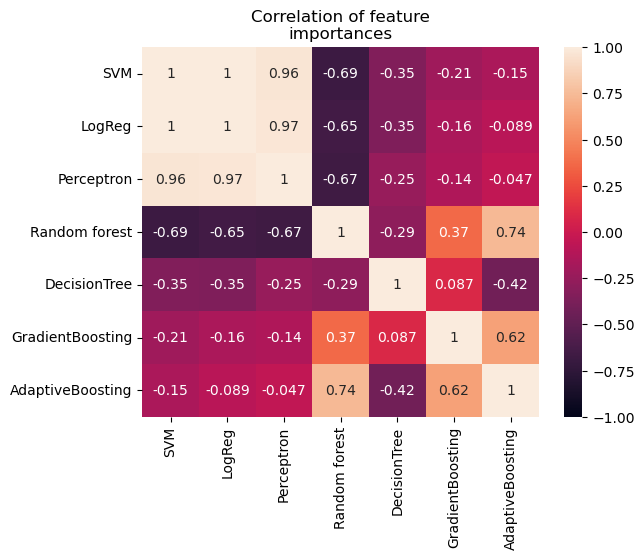

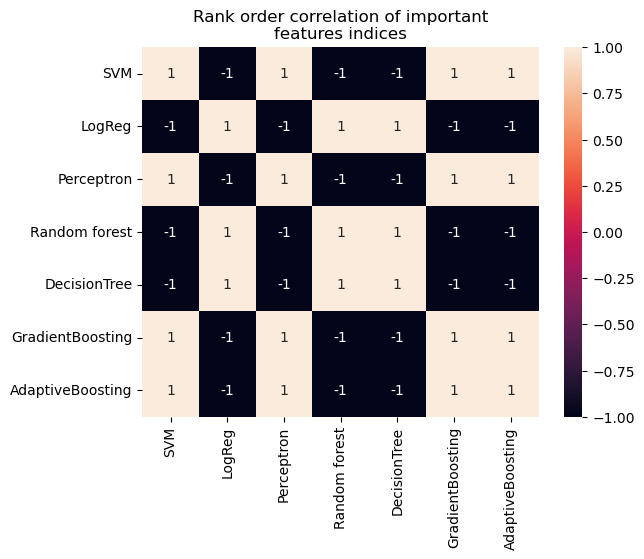

In [75]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_1.1'] = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval_ji.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [76]:
final_20 = results(fa_20)
print(final_20)

{'SVM': [0.66, 0.64], 'LogReg': [0.65, 0.63], 'Perceptron': [0.53, 0.53], 'Random forest': [0.89, 0.58], 'DecisionTree': [0.89, 0.55], 'GradientBoosting': [0.75, 0.61], 'AdaptiveBoosting': [0.66, 0.63]}


In [77]:
lst_conc_pca_and_fa =[]
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_1.1'],
                           'fa': names_fa_fea_20['Dataset_1.1']
    },
    df_trainval_ = df_trainval_ji,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_ji['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[0]

{'pca': {'Random forest': 0.0,
  'SVM': 0.0,
  'LogReg': 0.0,
  'Perceptron': 0.0,
  'DecisionTree': 0.0,
  'GradientBoosting': 0.0,
  'AdaptiveBoosting': 0.11},
 'fa': {'Random forest': 0.22,
  'SVM': 0.22,
  'LogReg': 0.22,
  'Perceptron': 0.22,
  'DecisionTree': 0.22,
  'GradientBoosting': 0.22,
  'AdaptiveBoosting': 0.22}}

# 1 shortDT (cc)

## Read the data

In [102]:
dataset_cc = read_data(
    datasets_folder_path,
    '1. shortDT (2) (cc)'
)

## Quick look and check the data

In [103]:
check_data(dataset_cc)
check_split_correctness(dataset_cc, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [104]:
df_trainval_cc, df_test_cc = train_test_split(
    dataset_cc,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset_cc['CONDITION']
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_trainval_cc, df_test_cc]
]

df_trainval_cc.shape, df_test_cc.shape

((385, 28), (97, 28))

In [105]:
df_train_cc, df_validation_cc = train_test_split(
    df_trainval_cc,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval_cc['CONDITION']
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_train_cc, df_validation_cc]
]

df_train_cc.shape, df_validation_cc.shape

((308, 28), (77, 28))

### Data sampling for psychological insights

In [ ]:
df_sample_cc = prepare_sample(
    dataset_cc,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset_cc, df_sample_cc)
df_sample_cc.head()

Mach1   Mach2   Mach3   Mach4   Mach5   Mach6   Mach7   Mach8   Mach9   \
24        4       2       3       3       4       3       3       1       3   
6         4       2       2       4       4       4       4       3       4   
222       4       2       2       3       2       3       3       3       4   
208       4       1       2       2       4       2       4       3       4   
236       4       1       3       4       1       2       3       2       1   

     Psycho1   ...  Narc1  Narc2   Narc3   Narc4   Narc5   Narc6  Narc7   \
24          4  ...      3       3       2       1       2      3       2   
6           4  ...      4       2       3       3       3      2       2   
222         1  ...      1       2       2       2       1      2       1   
208         1  ...      2       2       2       3       3      2       3   
236         2  ...      3       3       3       3       3      4       3   

     Narc8   Narc9   CONDITION  
24        2       4          H  
6         3       4          H  
222       2       4          H  
208       2       5          H  
236       2       2          H  

[5 rows x 28 columns]

## Data exploration (on train set only)

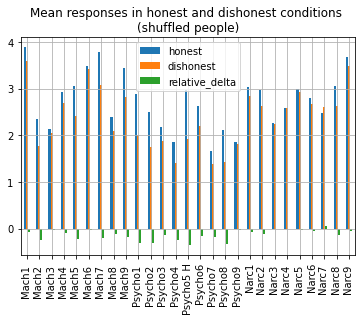

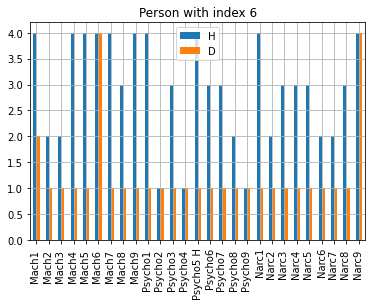

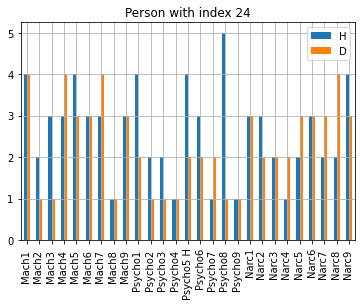

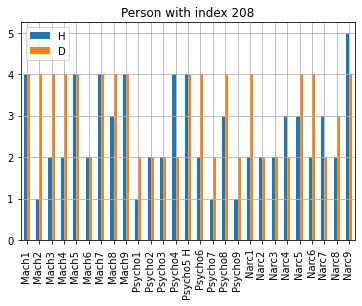

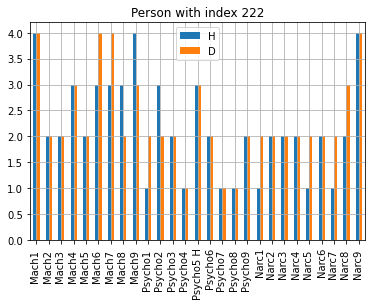

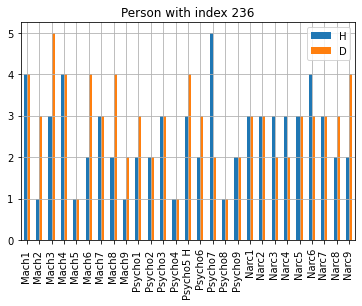

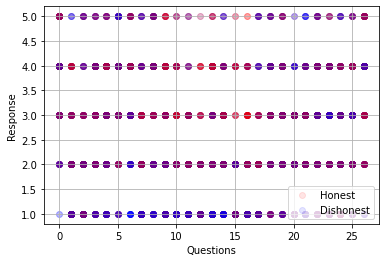

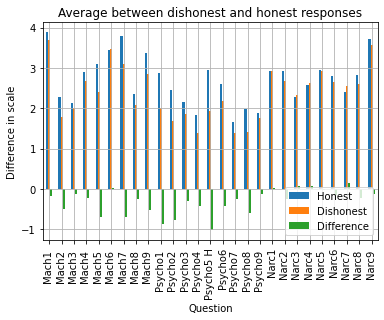

In [ ]:
plot_insights(df_train_cc, df_sample_cc)

## Problem statement

In [ ]:
PROBLEM_STATEMENT_MODELS.keys()

dict_keys(['SVM', 'LogReg', 'Perceptron', 'Random forest', 'DecisionTree', 'GradientBoosting', 'AdaptiveBoosting'])

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting Random forest
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
False
   SVM  LogReg  Perceptron  Random forest  DecisionTree  GradientBoosting  \
0   16      10          13             13            10                10   
1    6       6           9              9            13                13   
2   10      13           1             10             9                 9   
3   17      17          17              6             8                 6   
4    9      16          23             16            11                16   
5   13       9           6              1             6                15   
6    8      20          20              4            25                 8   
7    1       2          16              8            15                11   
8   20       1          22             14            19                25   
9   11      23          25             17            24                17   

   Adap

{'SVM': [[0.788961038961039,
   0.788961038961039,
   0.801948051948052,
   0.7727272727272727,
   0.7857142857142857],
  [0.7532467532467533,
   0.7532467532467533,
   0.7142857142857143,
   0.7792207792207793,
   0.7012987012987013]],
 'LogReg': [[0.775974025974026,
   0.7824675324675324,
   0.8116883116883117,
   0.762987012987013,
   0.7597402597402597],
  [0.7532467532467533,
   0.7402597402597403,
   0.6493506493506493,
   0.7532467532467533,
   0.7402597402597403]],
 'Perceptron': [[0.7532467532467533,
   0.6623376623376623,
   0.762987012987013,
   0.7435064935064936,
   0.672077922077922],
  [0.7402597402597403,
   0.7272727272727273,
   0.6493506493506493,
   0.7792207792207793,
   0.5974025974025974]],
 'Random forest': [[1.0, 1.0, 1.0, 1.0, 1.0],
  [0.7792207792207793,
   0.8051948051948052,
   0.7402597402597403,
   0.7272727272727273,
   0.7402597402597403]],
 'DecisionTree': [[1.0, 1.0, 1.0, 1.0, 1.0],
  [0.7012987012987013,
   0.7012987012987013,
   0.6623376623376623,


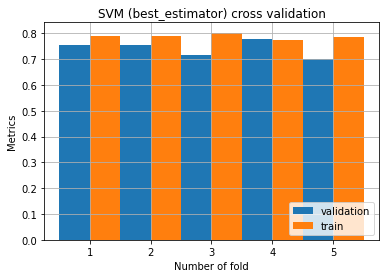

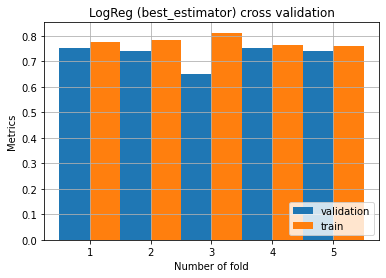

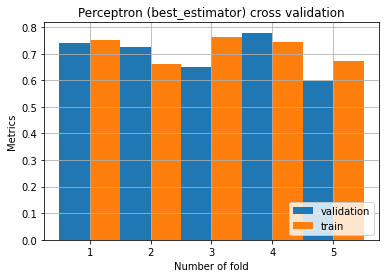

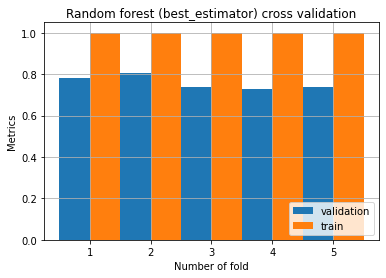

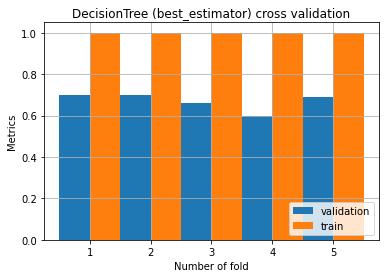

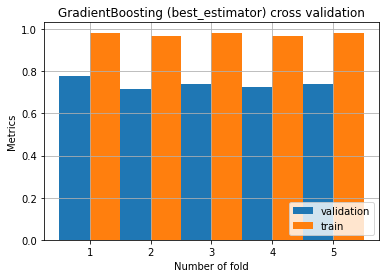

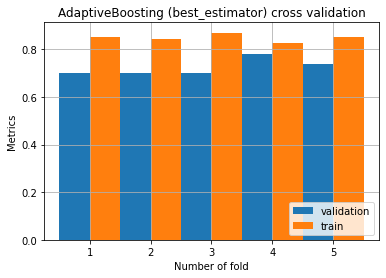

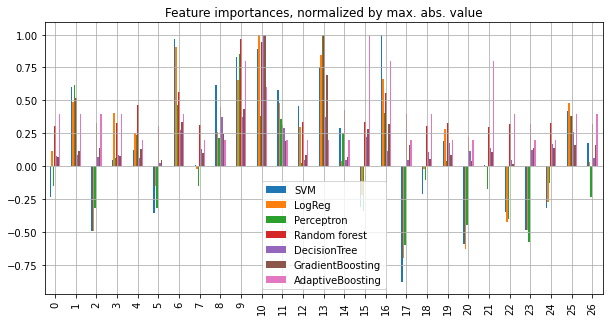

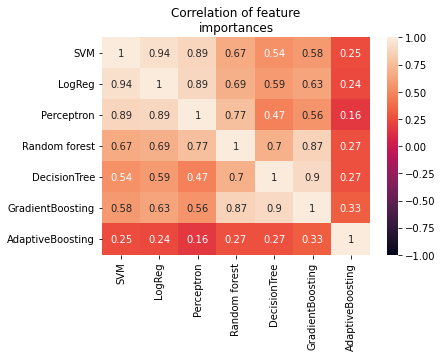

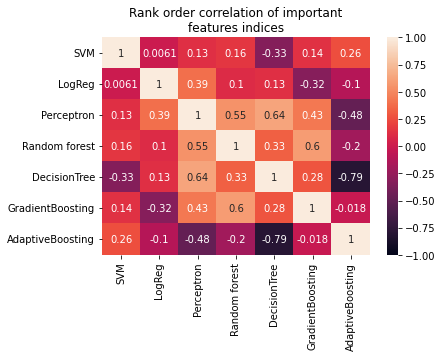

In [ ]:
plot_problem_statement(
    df_trainval_cc,
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

Fitting SVM
Fitting LogReg
Fitting Perceptron
None
   SVM  LogReg  Perceptron
0   16      10          13
1    6       6           9
2   10      13           1
3   17      17          17
4    9      16          23
5   13       9           6
6    8      20          20
7    1       2          16
8   20       1          22
9   11      23          25


{'SVM': [[0.788961038961039,
   0.788961038961039,
   0.801948051948052,
   0.7727272727272727,
   0.7857142857142857],
  [0.7532467532467533,
   0.7532467532467533,
   0.7142857142857143,
   0.7792207792207793,
   0.7012987012987013]],
 'LogReg': [[0.775974025974026,
   0.7824675324675324,
   0.8116883116883117,
   0.762987012987013,
   0.7597402597402597],
  [0.7532467532467533,
   0.7402597402597403,
   0.6493506493506493,
   0.7532467532467533,
   0.7402597402597403]],
 'Perceptron': [[0.7532467532467533,
   0.6623376623376623,
   0.762987012987013,
   0.7435064935064936,
   0.672077922077922],
  [0.7402597402597403,
   0.7272727272727273,
   0.6493506493506493,
   0.7792207792207793,
   0.5974025974025974]]}

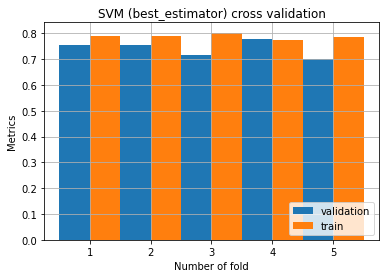

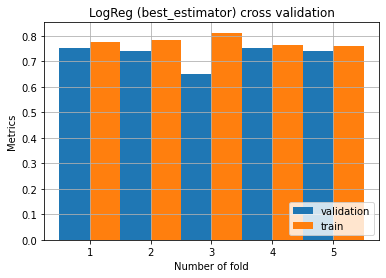

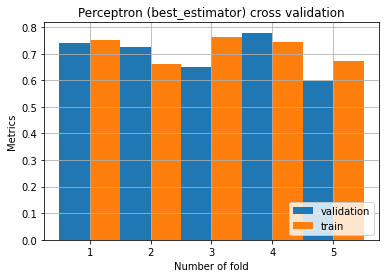

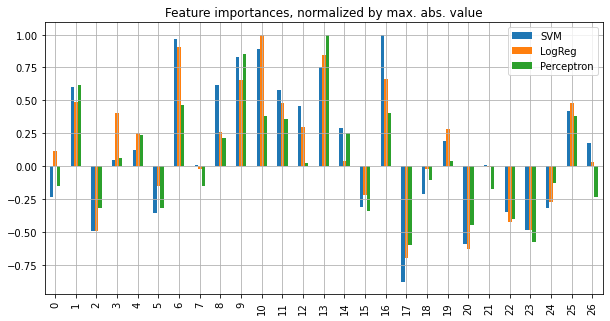

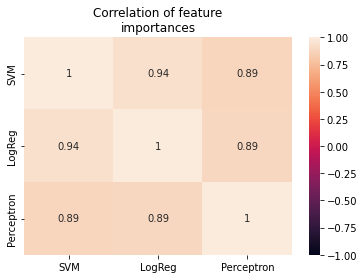

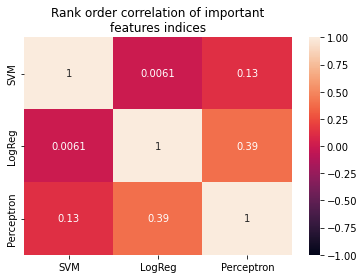

In [ ]:
plot_problem_statement(
    df_trainval_cc,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
)

## Recursive feature elimination

RFE: train model on all features, obtain their importances (Gini index for tree-based models or coefficients for others), eliminate the least important one and repeat.

Each time we do a cross-validation grid search for best hyperparameters.

In [106]:
cc_rfe_ranking, cc_rfe_train_scores, cc_rfe_val_scores = do_rfe(
    X_train=df_train_cc.iloc[:,:-1], y_train=df_train_cc.iloc[:,-1], 
    X_val=df_validation_cc.iloc[:,:-1], y_val=df_validation_cc.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train_cc.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


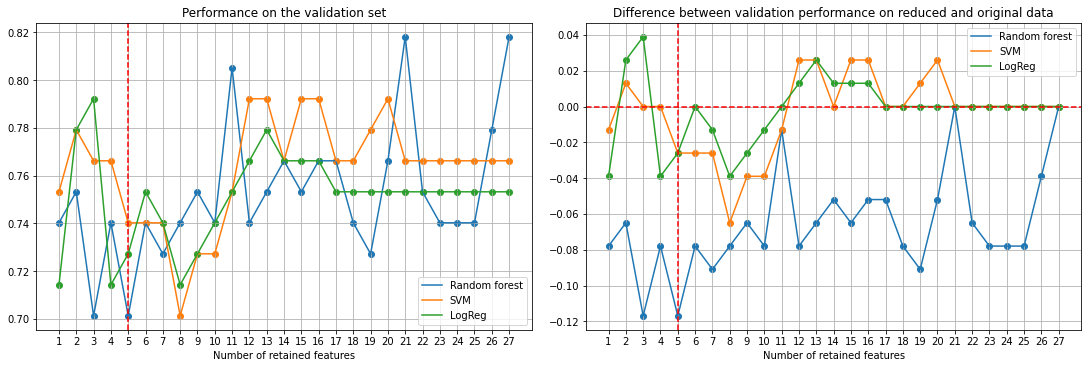

In [107]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(cc_rfe_val_scores.loc[models_to_plot],models_to_plot)

[Text(0.5, 0, 'SVM'),
 Text(1.5, 0, 'LogReg'),
 Text(2.5, 0, 'Perceptron'),
 Text(3.5, 0, 'DecisionTree'),
 Text(4.5, 0, 'GradientBoosting'),
 Text(5.5, 0, 'AdaptiveBoosting'),
 Text(6.5, 0, 'Random forest')]

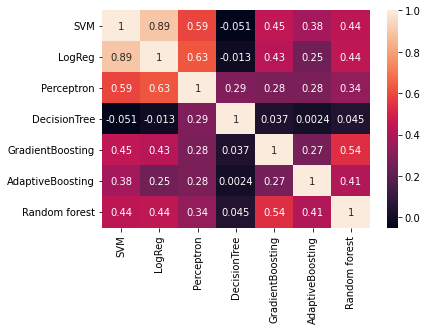

In [108]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(cc_rfe_ranking.loc[m1], cc_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

### Chi squared, Mutual information, ANOVA testing

In [ ]:
GRID_SEARCH_MODELS.keys()

dict_keys(['Random forest', 'SVM', 'LogReg', 'Perceptron', 'DecisionTree', 'GradientBoosting', 'AdaptiveBoosting'])

====== VVV RUNNING chi2 VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


====== VVV RUNNING mutual information VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


====== VVV RUNNING ANOVA VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting


<ipython-input-27-027683246eed>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


Fitting AdaptiveBoosting


<ipython-input-27-027683246eed>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

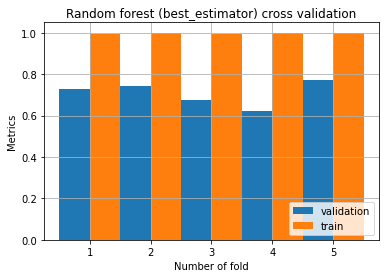

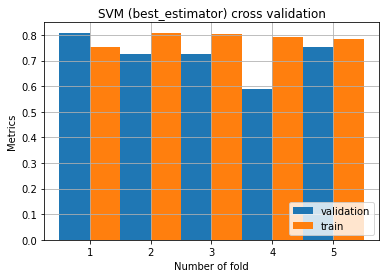

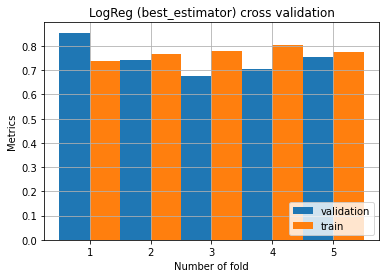

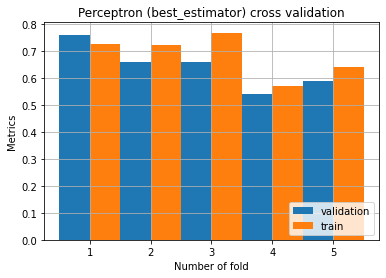

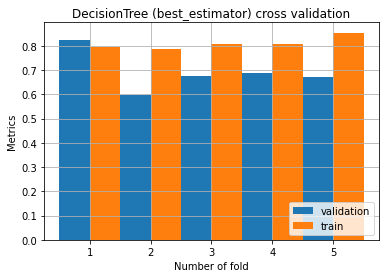

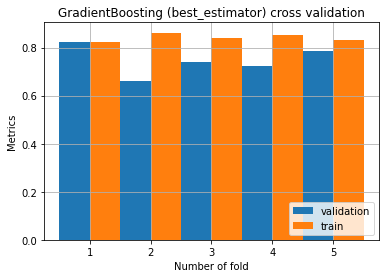

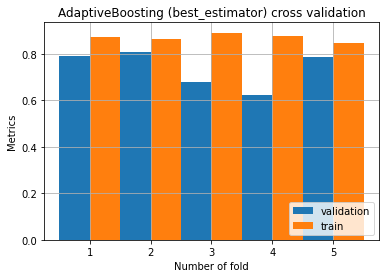

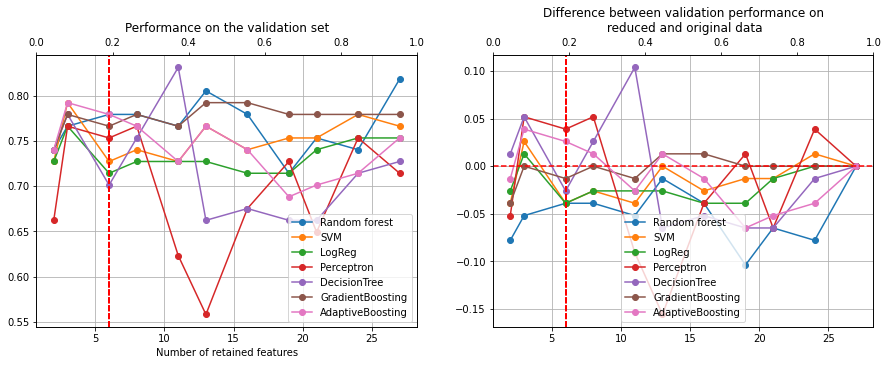

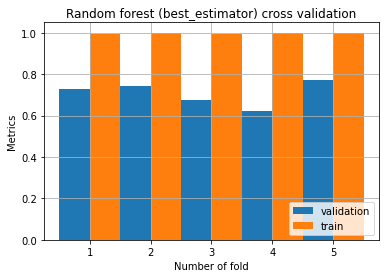

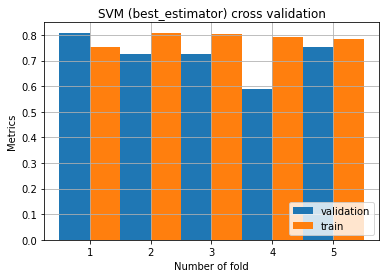

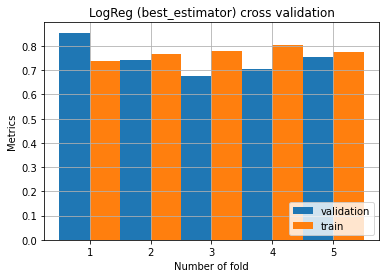

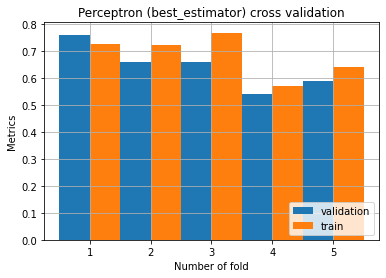

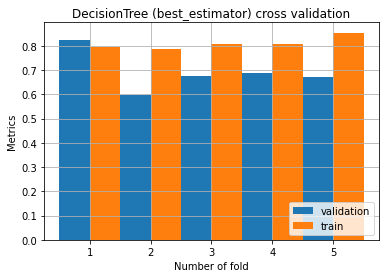

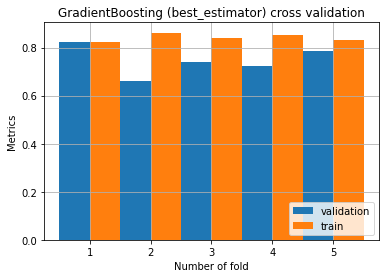

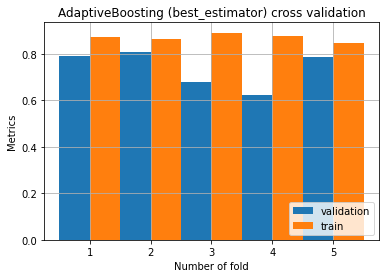

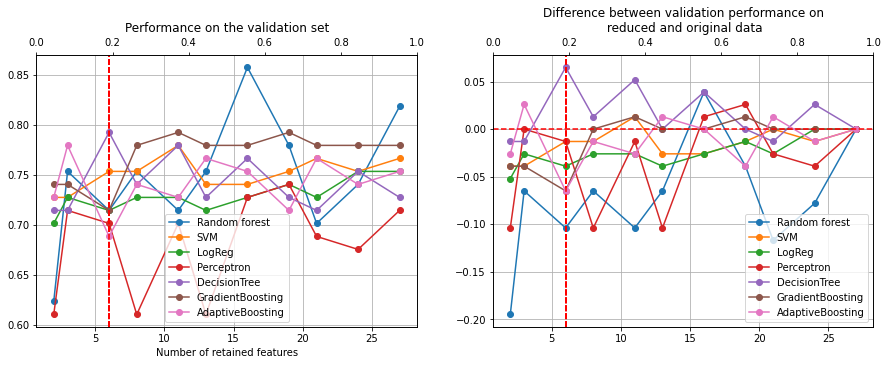

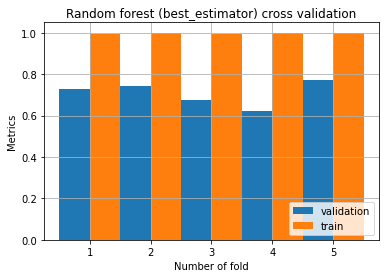

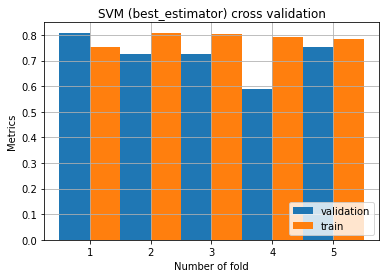

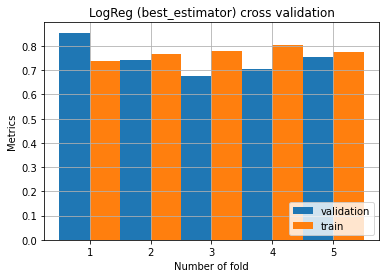

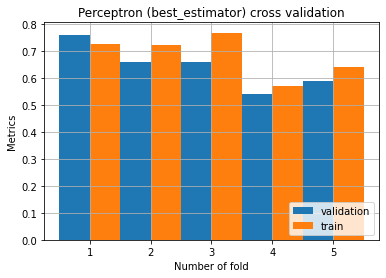

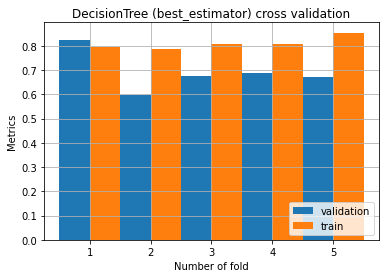

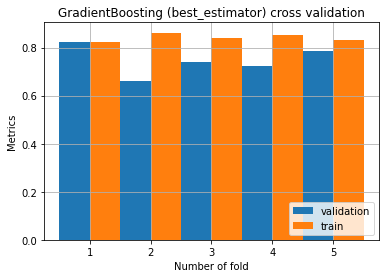

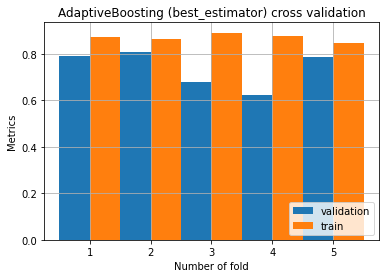

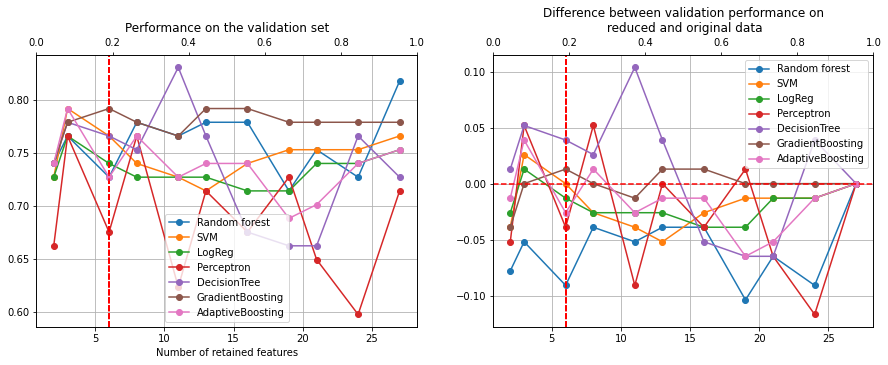

In [ ]:
experiment_results_cc = run_feature_selection_experiments(
    df_trainval_cc,
    df_train_cc,
    df_validation_cc,
    df_test_cc,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    metrics_function_=accuracy_score,
    percentiles_=[5] + [i*10 for i in range(1, 11)]
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=np.linspace(0.1, 1, int(1/0.1)),
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results_cc['chi2']['trainval_processed'][0],
        experiment_results_cc['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_cc['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval_cc,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results_cc['chi2']['trainval_processed'][0],
    Y_=experiment_results_cc['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results_cc['chi2'][
        'grid_search_results']['LogReg'].best_estimator_,
    df_=df_trainval_cc
)

In [ ]:
report_outliers(
    df_trainval_cc,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval_cc,
    main_features['chi2'][:3],
    figsize=(9, 6),
    elev=30,
    azim=60
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset_cc)

### Training models based on 100% features selected using PCA

In [91]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_1.2'] = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval_cc.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

NameError: name 'df_trainval_cc' is not defined

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_1.2'] = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval_cc.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset_cc.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset_cc)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset_cc,no_factors,fa_loadings)


### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_1.2'] = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval_cc.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)


### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_1.2'] = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval_cc.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_1.2'],
                           'fa': names_fa_fea_20['Dataset_1.2']
    },
    df_trainval_ = df_trainval_cc,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_cc['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[1]

# 2 PRMQ

## Download the data

In [70]:
dataset = read_data(
    datasets_folder_path,
    '2. PRMQ'
)

## Quick look and check the data

### Data clean check

In [71]:
check_data(dataset)

### Class balance

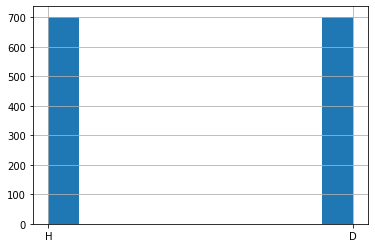

In [72]:
dataset['CONDITION'].hist()

assert len(dataset.loc[dataset['CONDITION'] == 'H', :]) \
    == len(dataset.loc[dataset['CONDITION'] == 'D', :])

## Create trainval + test + psychological sets

### Data sampling for the model

In [73]:
df_trainval, df_test = train_test_split(
    dataset,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION', eps_=0.001)
check_split_correctness(df_test, 'CONDITION', eps_=0.01)

df_trainval.shape, df_test.shape

((1123, 17), (281, 17))

In [74]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)


check_split_correctness(df_train, 'CONDITION')
check_split_correctness(df_validation, 'CONDITION')

df_train.shape, df_validation.shape

((898, 17), (225, 17))

### Data sampling for psychological insights

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)

## Data exploration (on train set only)

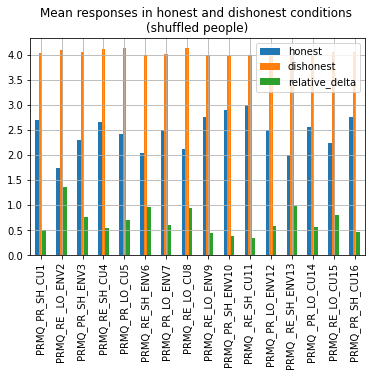

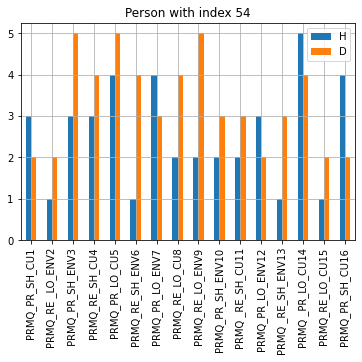

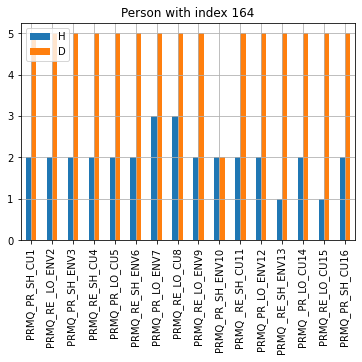

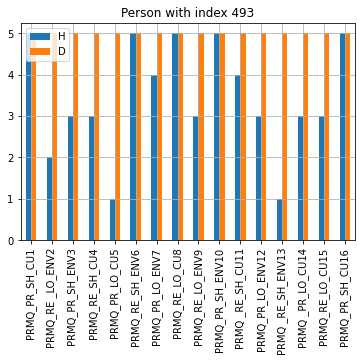

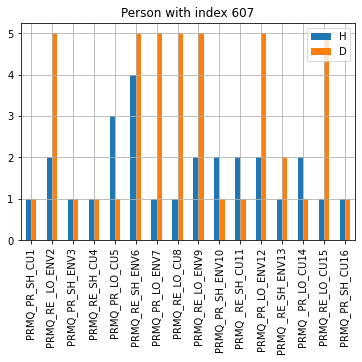

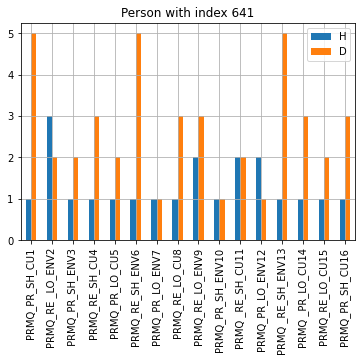

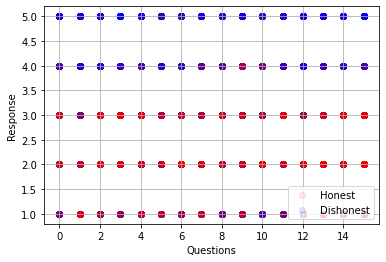

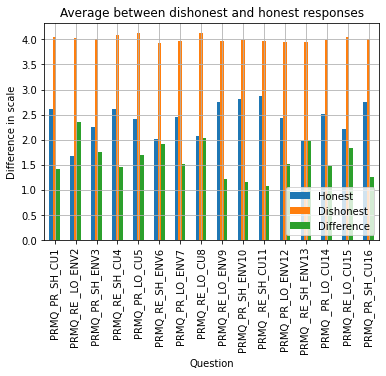

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
PROBLEM_STATEMENT_MODELS.keys()

dict_keys(['SVM', 'LogReg', 'Perceptron', 'Random forest', 'DecisionTree', 'GradientBoosting', 'AdaptiveBoosting'])

Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
Fitting Random forest
False
   SVM  LogReg  Perceptron  DecisionTree  GradientBoosting  AdaptiveBoosting  \
0    1       1           1             1                 1                10   
1    2      12          12             7                 7                 9   
2   12       2           9            11                12                 4   
3   10      10          10             0                 4                 1   
4    4       9           7            10                 0                14   
5    9       7           8             2                14                13   

   Random forest  
0              1  
1              7  
2             12  
3              2  
4              5  
5             14  


{'SVM': [[0.9053452115812918,
   0.9120267260579065,
   0.9042316258351893,
   0.9087875417130145,
   0.9098998887652948],
  [0.8977777777777778,
   0.8755555555555555,
   0.9288888888888889,
   0.8883928571428571,
   0.8928571428571429]],
 'LogReg': [[0.9064587973273942,
   0.9042316258351893,
   0.8986636971046771,
   0.9054505005561735,
   0.9043381535038932],
  [0.9022222222222223,
   0.88,
   0.9244444444444444,
   0.8794642857142857,
   0.8839285714285714]],
 'Perceptron': [[0.8919821826280624,
   0.8819599109131403,
   0.7939866369710468,
   0.7764182424916574,
   0.8720800889877642],
  [0.9111111111111111,
   0.8711111111111111,
   0.8177777777777778,
   0.7857142857142857,
   0.8348214285714286]],
 'DecisionTree': [[0.9988864142538976,
   1.0,
   0.9988864142538976,
   0.9988876529477196,
   0.9988876529477196],
  [0.9066666666666666,
   0.8622222222222222,
   0.9022222222222223,
   0.8883928571428571,
   0.8928571428571429]],
 'GradientBoosting': [[0.9799554565701559,
   0.98

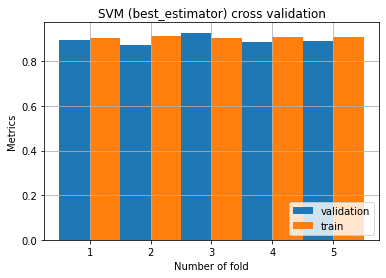

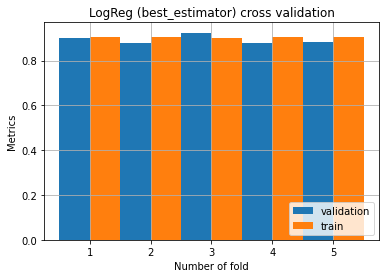

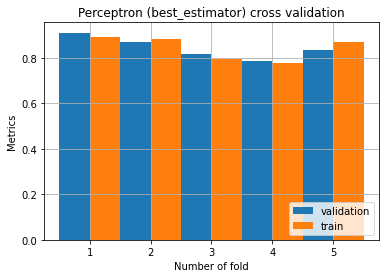

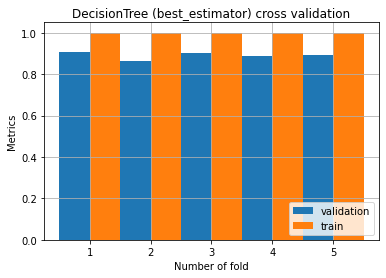

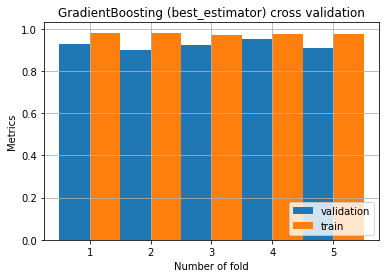

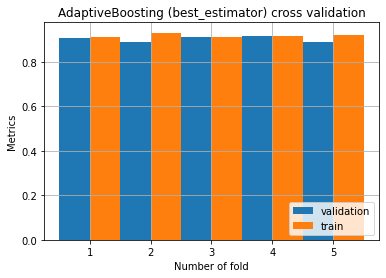

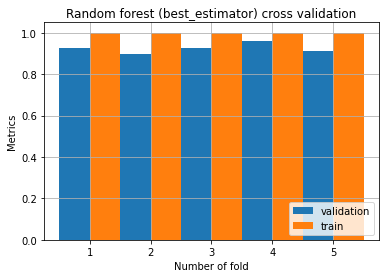

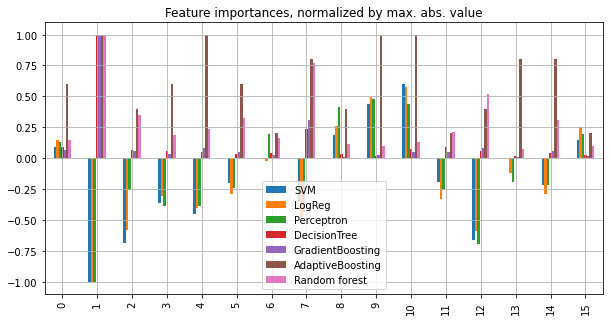

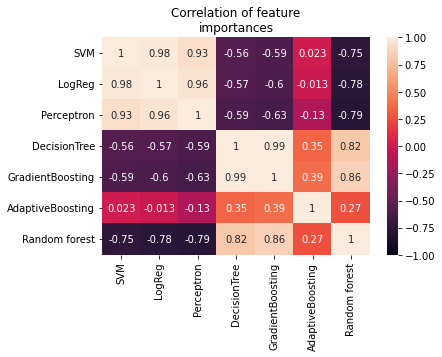

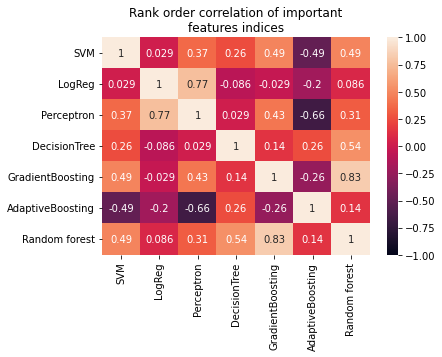

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron',

            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    figsize_=(10, 5),
    take_abs_=False,
    rank_order_correlation_percentage_=0.4
)

Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
Fitting Random forest
None
   DecisionTree  GradientBoosting  AdaptiveBoosting  Random forest
0             1                 1                10              1
1             7                 7                 9              7
2            11                12                 4             12
3             0                 4                 1              2
4            10                 0                14              5
5             2                14                13             14


{'DecisionTree': [[0.9988864142538976,
   1.0,
   0.9988864142538976,
   0.9988876529477196,
   0.9988876529477196],
  [0.9066666666666666,
   0.8622222222222222,
   0.9022222222222223,
   0.8883928571428571,
   0.8928571428571429]],
 'GradientBoosting': [[0.9799554565701559,
   0.9821826280623608,
   0.9721603563474388,
   0.9766407119021134,
   0.9766407119021134],
  [0.9288888888888889,
   0.9022222222222223,
   0.9244444444444444,
   0.9508928571428571,
   0.9107142857142857]],
 'AdaptiveBoosting': [[0.9097995545657016,
   0.9309576837416481,
   0.910913140311804,
   0.9165739710789766,
   0.9221357063403782],
  [0.9066666666666666,
   0.8888888888888888,
   0.9111111111111111,
   0.9151785714285714,
   0.8883928571428571]],
 'Random forest': [[0.9988864142538976,
   1.0,
   0.9988864142538976,
   0.9988876529477196,
   0.9988876529477196],
  [0.9244444444444444,
   0.8977777777777778,
   0.9244444444444444,
   0.9598214285714286,
   0.9107142857142857]]}

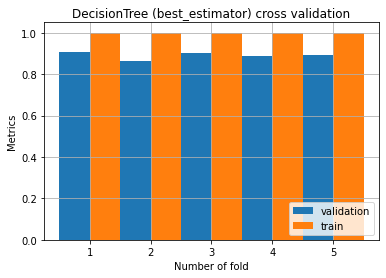

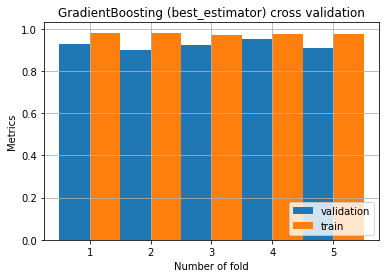

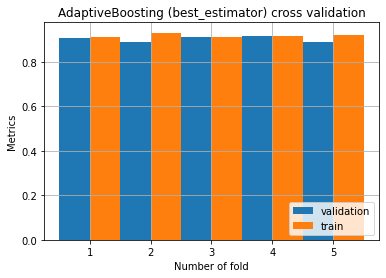

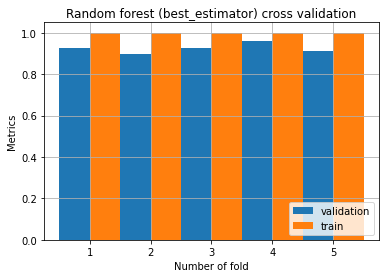

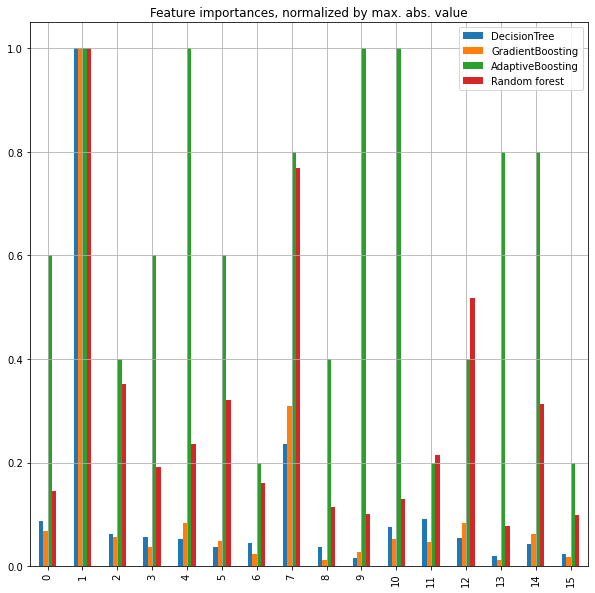

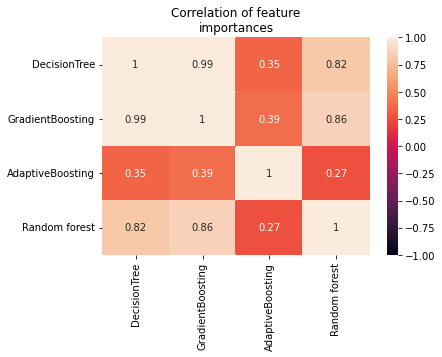

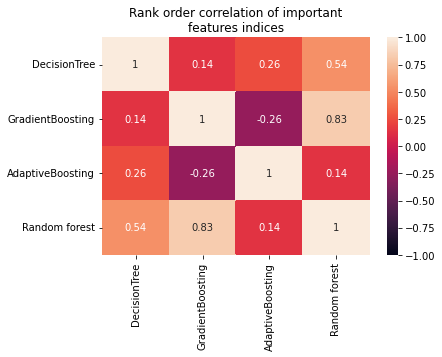

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    )
)

## Recursive feature elimination

RFE: train model on all features, obtain their importances (Gini index for tree-based models or coefficients for others), eliminate the least important one and repeat.

Each time we do a cross-validation grid search for best hyperparameters.

In [75]:
prmq_rfe_ranking, prmq_rfe_train_scores, prmq_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done
LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


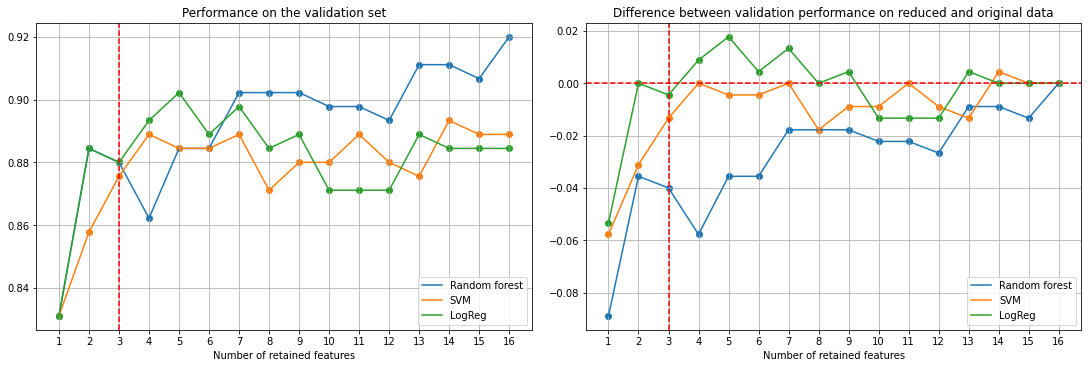

In [76]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(prmq_rfe_val_scores.loc[models_to_plot],models_to_plot)

[Text(0.5, 0, 'SVM'),
 Text(1.5, 0, 'LogReg'),
 Text(2.5, 0, 'Perceptron'),
 Text(3.5, 0, 'DecisionTree'),
 Text(4.5, 0, 'GradientBoosting'),
 Text(5.5, 0, 'AdaptiveBoosting'),
 Text(6.5, 0, 'Random forest')]

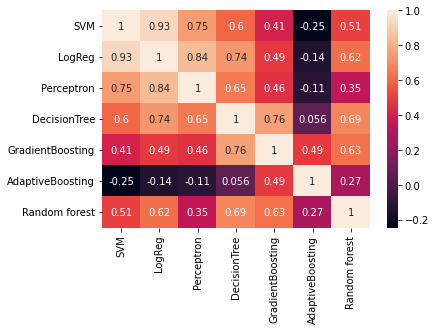

In [94]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(prmq_rfe_ranking.loc[m1], prmq_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

====== VVV RUNNING chi2 VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
====== VVV RUNNING mutual information VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree
Fitting GradientBoosting
Fitting AdaptiveBoosting
====== VVV RUNNING ANOVA VVV ======
Fitting Random forest
Fitting SVM
Fitting LogReg
Fitting Perceptron
Fitting DecisionTree


<ipython-input-27-027683246eed>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


Fitting GradientBoosting


<ipython-input-27-027683246eed>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()


Fitting AdaptiveBoosting


<ipython-input-27-027683246eed>:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots()
<ipython-input-30-28c56f7ccab9>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2, figsize=kwargs.get('figsize') or (15, 5))


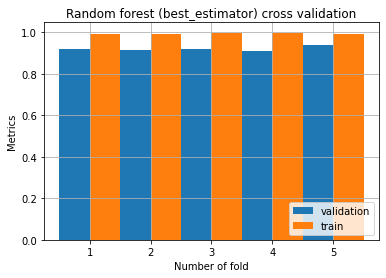

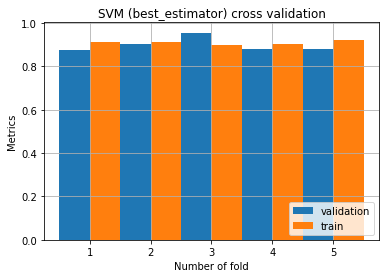

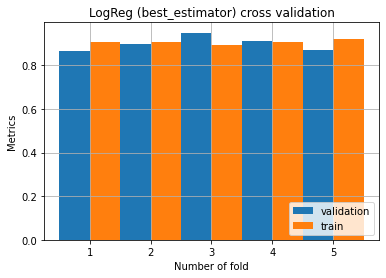

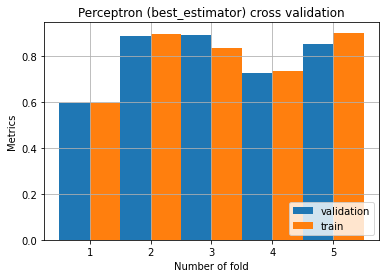

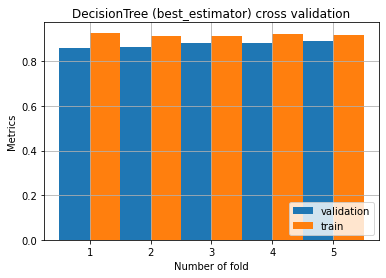

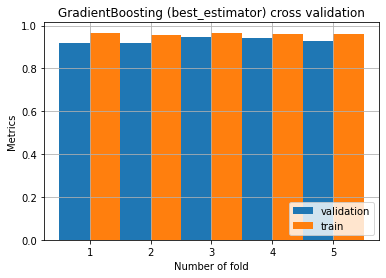

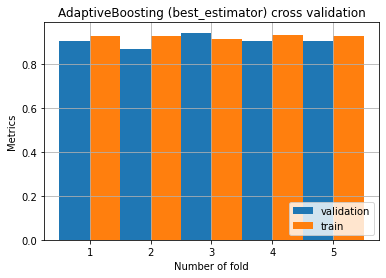

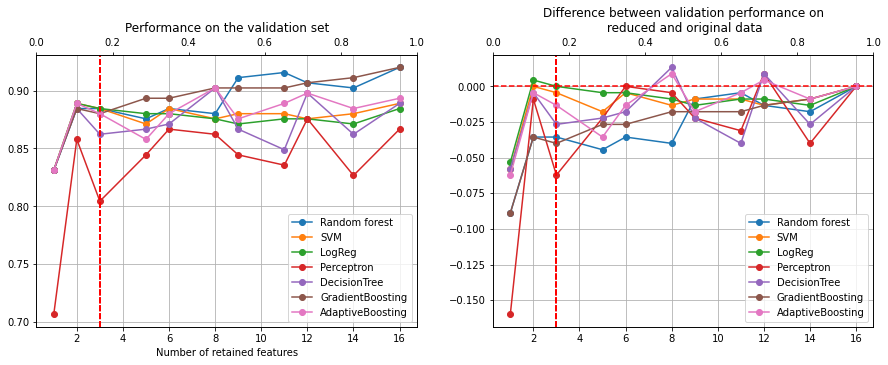

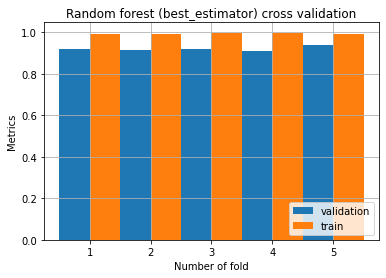

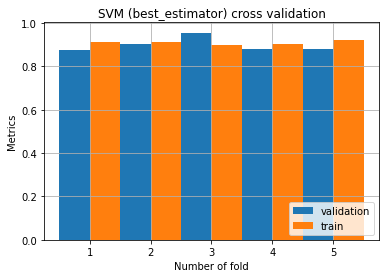

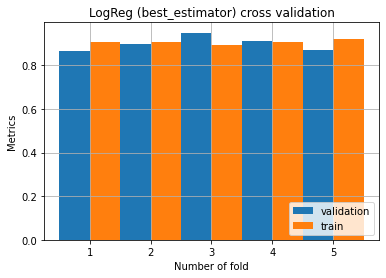

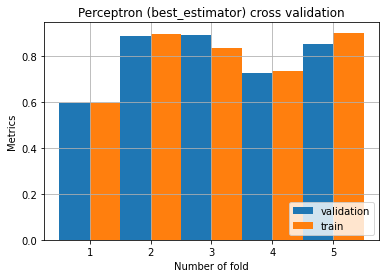

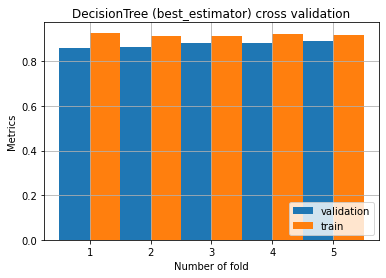

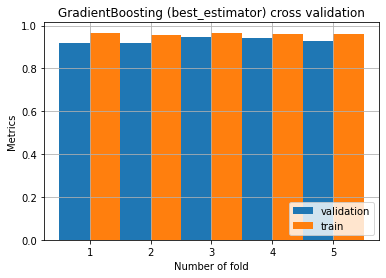

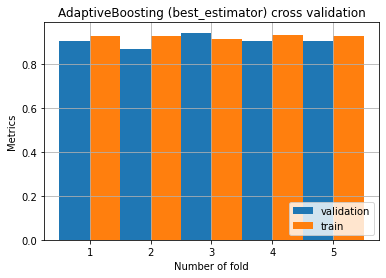

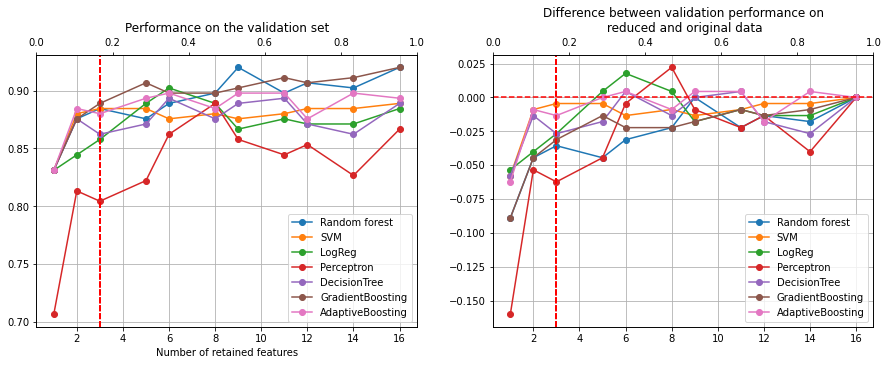

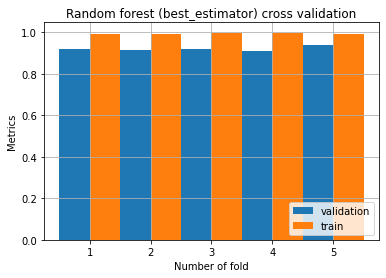

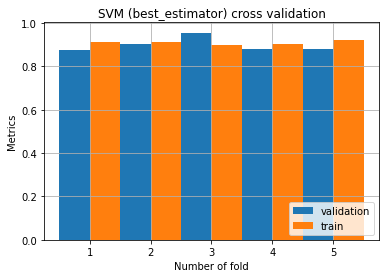

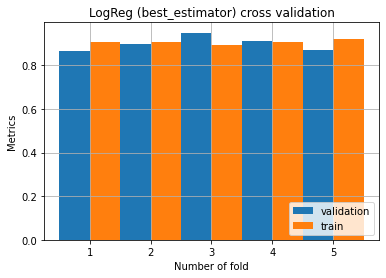

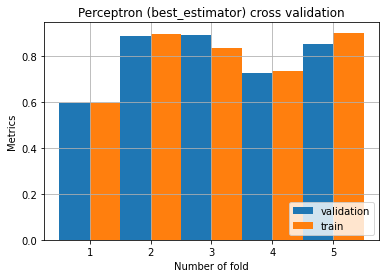

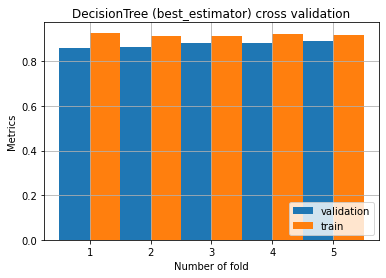

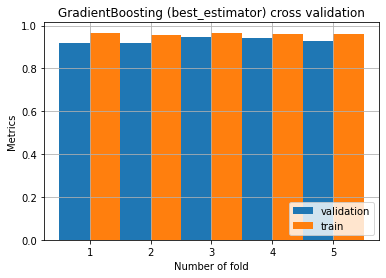

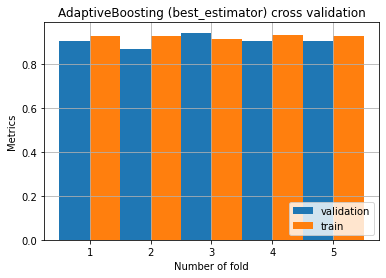

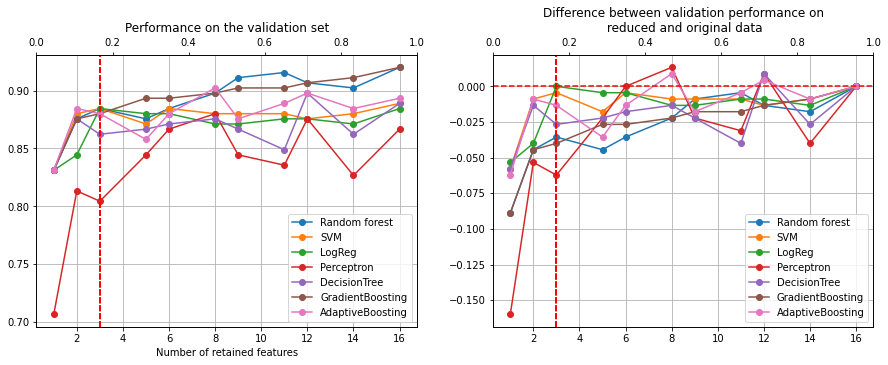

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=dict_subset(
        GRID_SEARCH_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron'
        ]
    )
)

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=dict_subset(
        GRID_SEARCH_MODELS,
        [
            'Random forest',
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting'
        ]
    )
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=np.linspace(0.1, 1, int(1/0.1)),
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=False
)

In [ ]:
concordance_report(
    percentiles_=np.linspace(0.1, 1, int(1/0.1)), # [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['Random forest'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    elev=30,
    azim=60
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_2'] = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_2'] = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_2'] = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_2'] = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_2'],
                           'fa': names_fa_fea_20['Dataset_2']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[2]



# 3 PCL

## Download the data

In [ ]:
dataset = read_data(
    datasets_folder_path,
    '3. PCL'
)

AssertionError: ignored

## Quick look and check the data

In [ ]:
check_data(dataset)

In [ ]:
dataset.CONDITION.value_counts().plot(kind='bar')

In [ ]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [ ]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset.CONDITION
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

In [ ]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

[
    check_split_correctness(df_, 'CONDITION')
    for df_ in [df_train, df_validation]
]

df_train.shape, df_validation.shape

### Data sampling for psychological insights

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head(2)

## Data exploration (on train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron'
        ]
    )
)

## Recursive feature elimination

RFE: train model on all features, obtain their importances (Gini index for tree-based models or coefficients for others), eliminate the least important one and repeat.

Each time we do a cross-validation grid search for best hyperparameters.

In [ ]:
pcl_rfe_ranking, pcl_rfe_train_scores, pcl_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(pcl_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(pcl_rfe_ranking.loc[m1], pcl_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=dict_subset(
        GRID_SEARCH_MODELS,
        ['LogReg', 'AdaptiveBoosting']
    )
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret feature

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['LogReg'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(7, 5)
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_3']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_3']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_3']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_3']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_3'],
                           'fa': names_fa_fea_20['Dataset_3']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[3]

# 4 NAQ_R

## Download the data

In [109]:
dataset = read_data(
    datasets_folder_path,
    '4. NAQ_R'
)

## Quick look and check the data

### Data clean check

In [ ]:
check_data(dataset)

### Class balance

In [ ]:
dataset.CONDITION.value_counts()

H    356
D    356
Name: CONDITION, dtype: int64

In [ ]:
dataset.shape

(712, 23)

In [ ]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [110]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

((569, 23), (143, 23))

In [111]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

check_split_correctness(df_train, 'CONDITION')
check_split_correctness(df_validation, 'CONDITION')

df_train.shape, df_validation.shape

((455, 23), (114, 23))

### Data sampling for psychological insights

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

## Data exploration (on train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=PROBLEM_STATEMENT_MODELS,
)

## Recursive feature elimination

In [112]:
naq_rfe_ranking, naq_rfe_train_scores, naq_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


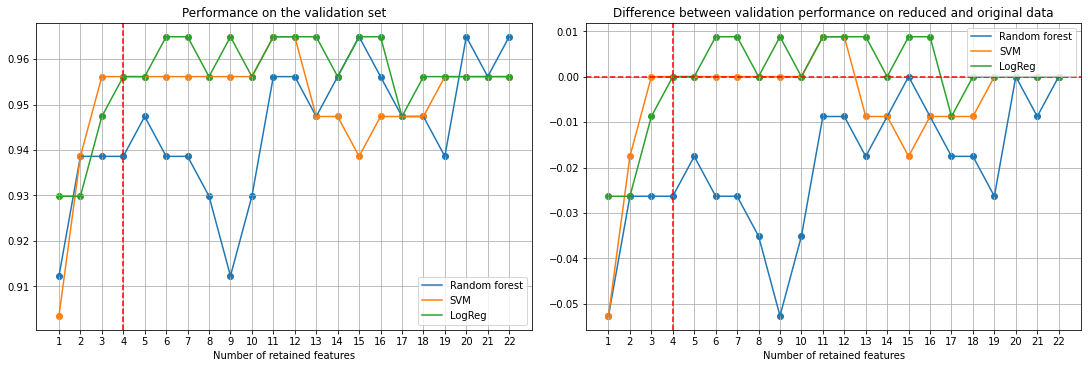

In [113]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(naq_rfe_val_scores.loc[models_to_plot],models_to_plot)

[Text(0.5, 0, 'SVM'),
 Text(1.5, 0, 'LogReg'),
 Text(2.5, 0, 'Perceptron'),
 Text(3.5, 0, 'DecisionTree'),
 Text(4.5, 0, 'GradientBoosting'),
 Text(5.5, 0, 'AdaptiveBoosting'),
 Text(6.5, 0, 'Random forest')]

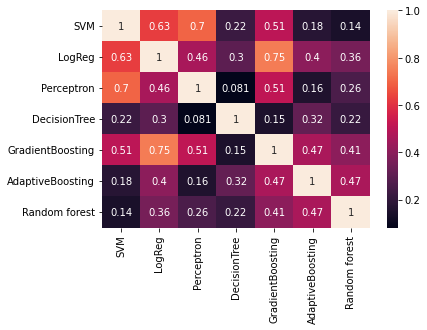

In [114]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(naq_rfe_ranking.loc[m1], naq_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    
    models_dict_=dict_subset(
        GRID_SEARCH_MODELS,
        ['LogReg', 'AdaptiveBoosting']
    )
)

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret feature

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['LogReg'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(7, 5)
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_4']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_4']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_4']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_4']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_4'],
                           'fa': names_fa_fea_20['Dataset_4']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[4]

# 5 PHQ9_GAD7

## Download the data

In [ ]:
dataset = read_data(
    datasets_folder_path,
    '5. PHQ9_GAD7'
)

_pep8(_ih)

## Quick look & check the data

In [ ]:
check_data(dataset)

### Data clean check

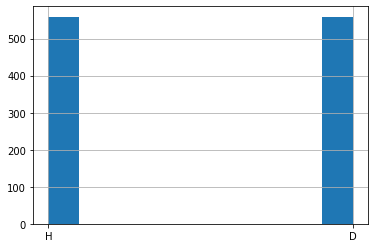

In [ ]:
dataset['CONDITION'].hist()

assert len(dataset.loc[dataset['CONDITION'] == 'H', :]) \
    == len(dataset.loc[dataset['CONDITION'] == 'D', :])

## Create trainval + test + psychological sets

### Data sampling for the model

In [ ]:
df_trainval, df_test = train_test_split(
    dataset,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION', eps_=0.001)
check_split_correctness(df_test, 'CONDITION', eps_=0.01)

df_trainval.shape, df_test.shape

((894, 17), (224, 17))

In [ ]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)


check_split_correctness(df_train, 'CONDITION')
check_split_correctness(df_validation, 'CONDITION')

df_train.shape, df_validation.shape

((715, 17), (179, 17))

### Data sampling for psychological insights

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)

## Data exploration (on train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron',

            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    figsize_=(10, 5),
    take_abs_=False,
    rank_order_correlation_percentage_=0.4
)

## Recursive feature elimination

In [ ]:
phq9_rfe_ranking, phq9_rfe_train_scores, phq9_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


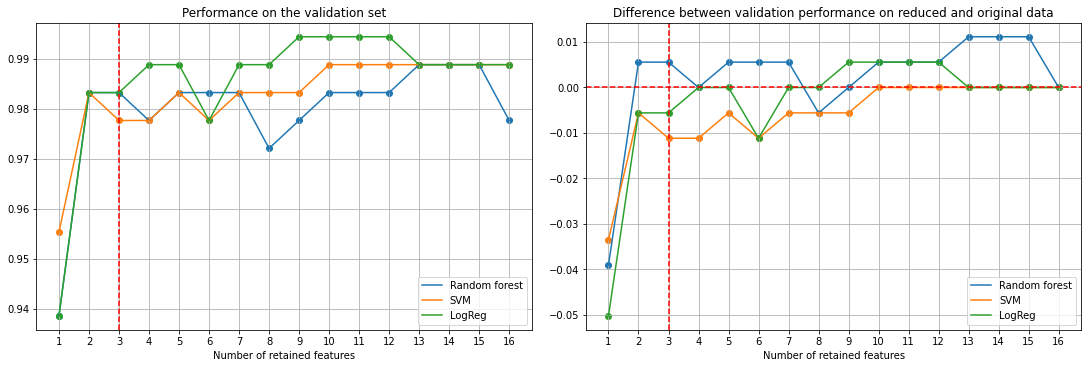

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(phq9_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(rfe_mnames), len(rfe_mnames)))
for i,m1 in enumerate(rfe_mnames):
  for j,m2 in enumerate(rfe_mnames):
    corrs_rfe[i][j] = spearmanrho(phq9_rfe_ranking.loc[m1], phq9_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=rfe_mnames)
ax.set_xticklabels(rfe_mnames, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=np.linspace(0.1, 1, int(1/0.1)),
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=False
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.4,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['LogReg'].best_estimator_,
    df_=df_trainval
)



In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    elev=30,
    azim=60
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_5']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_5']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_5']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_5']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_5'],
                           'fa': names_fa_fea_20['Dataset_5']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[5]

# 6 PID5

## Download the data

In [ ]:
dataset = read_data(datasets_folder_path, '6. PID5')

AssertionError: ignored

## Quick look and check the data

In [ ]:
check_data(dataset)

In [ ]:
dataset.CONDITION.value_counts().plot(kind='bar')
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [ ]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset.CONDITION
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

In [ ]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

[
    check_split_correctness(df_, 'CONDITION')
    for df_ in [df_train, df_validation]
]

df_train.shape, df_validation.shape

### Data sampling for psychological insights

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head(2)

## Data exploration (on train set only)

In [ ]:
df_train.iloc[:, :5]

In [ ]:
N_FEATURES = 15

plot_insights(
    df_train.iloc[:, -N_FEATURES:],
    df_sample.iloc[:, -N_FEATURES:]
)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval.iloc[:, -N_FEATURES:],
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

In [ ]:
plot_problem_statement(
    df_trainval.iloc[:, -N_FEATURES:],
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'SVM',
            'LogReg',
            'Perceptron'
        ]
    )
)

## Recursive feature elimination

In [ ]:
pid_rfe_ranking, pid_rfe_train_scores, pid_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(pid_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(pid_rfe_ranking.loc[m1], pid_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature_selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=dict_subset(
        GRID_SEARCH_MODELS,
        [
            'SVM',
            'Random forest',
            
        ]
    )
)



In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=np.linspace(0.1, 1, int(1/0.1)),
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=False
)

## Finding secret feature

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['LogReg'].best_estimator_,
    df_=df_trainval.iloc[:, -N_FEATURES:]
)


In [ ]:
report_outliers(
    df_trainval.iloc[:, -N_FEATURES:],
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval.iloc[:, -N_FEATURES:],
    main_features['chi2'][:3],
    figsize=(7, 5)
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_6']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_6']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_6']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_6']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_6'],
                           'fa': names_fa_fea_20['Dataset_6']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[6]

# 7 Short PID 5

## Download the data

In [ ]:
dataset = read_data(
    datasets_folder_path,
    '7. shortPID5'
)

AssertionError: ignored

## Quick look and check the data

### Data clean check

In [ ]:
check_data(dataset)

### Class balance

In [ ]:
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

### Data sampling for the model

In [ ]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

In [ ]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

[check_split_correctness(df_, 'CONDITION') for df_ in [df_train, df_validation]]

### Data sampling for psychological insights

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

## Data exploration (with train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

## Recursive feature elimination

In [ ]:
spid_rfe_ranking, spid_rfe_train_scores, spid_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

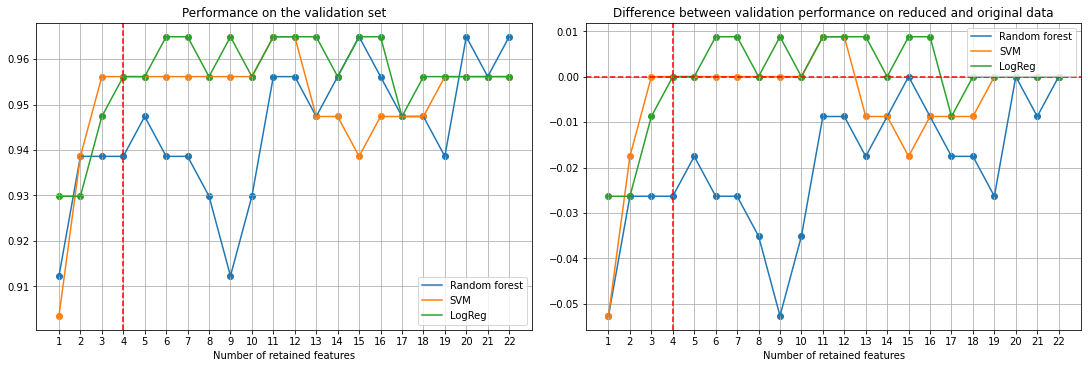

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(spid_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(spid_rfe_ranking.loc[m1], spid_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=dict_subset(
        GRID_SEARCH_MODELS,
        ['LogReg', 'AdaptiveBoosting']
    )
)

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    azim=30,
    elev=30
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_7']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_7']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_7']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_7']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_7'],
                           'fa': names_fa_fea_20['Dataset_7']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[7]

# 8 PRFQ

## Download the data

In [115]:
dataset = read_data(
    datasets_folder_path,
    '8. PRFQ'
)
dataset.shape

(678, 19)

## Quick look and check the data

In [116]:
check_data(dataset)
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + pspychological sets

In [117]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

check_split_correctness(df_trainval, 'CONDITION')
check_split_correctness(df_test, 'CONDITION')

df_trainval.shape, df_test.shape

((542, 19), (136, 19))

In [118]:
df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval['CONDITION']
)

[check_split_correctness(df, 'CONDITION') for df in [df_train, df_validation]]

[None, None]

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

## Data exploration (with train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
)

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    )
)

## Recursive feature elimination

In [ ]:
prfq_rfe_ranking, prfq_rfe_train_scores, prfq_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


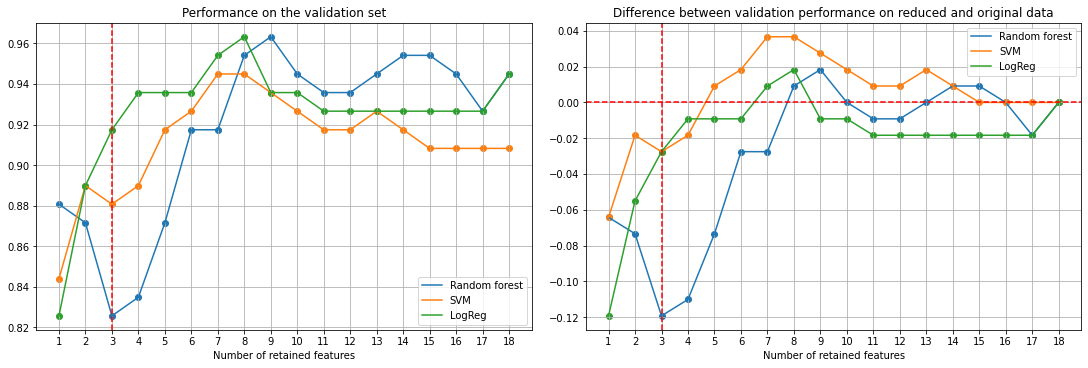

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(prfq_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(prfq_rfe_ranking.loc[m1], prfq_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval
)

In [ ]:
main_features

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    azim=150,
    elev=30
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_8']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_8']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_8']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_8']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_8'],
                           'fa': names_fa_fea_20['Dataset_8']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[8]

# 9 IESR

## Download the data

In [87]:
dataset = read_data(
    datasets_folder_path,
    '9. IESR'
)

## Quick look and check the data

In [88]:
check_data(dataset)
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

In [89]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset['CONDITION']
)

[check_split_correctness(df, 'CONDITION') for df in (df_trainval, df_test)]

df_trainval.shape, df_test.shape

((286, 23), (72, 23))

In [90]:
df_train, df_validation = train_test_split(
    df_trainval,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval['CONDITION']
)

[check_split_correctness(df, 'CONDITION') for df in (df_train, df_validation)]
df_train.shape, df_validation.shape

((228, 23), (58, 23))

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

## Data exploration (on train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

## Recursive feature elimination

In [91]:
iesr_rfe_ranking, iesr_rfe_train_scores, iesr_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


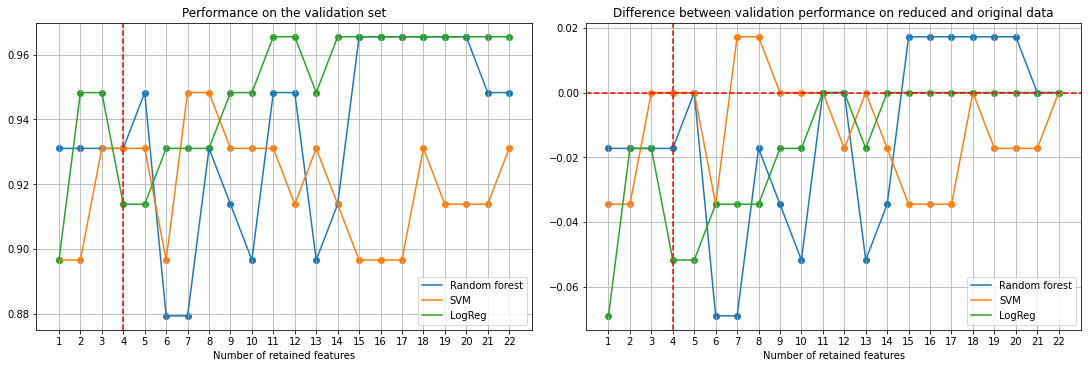

In [92]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(iesr_rfe_val_scores.loc[models_to_plot],models_to_plot)

[Text(0.5, 0, 'SVM'),
 Text(1.5, 0, 'LogReg'),
 Text(2.5, 0, 'Perceptron'),
 Text(3.5, 0, 'DecisionTree'),
 Text(4.5, 0, 'GradientBoosting'),
 Text(5.5, 0, 'AdaptiveBoosting'),
 Text(6.5, 0, 'Random forest')]

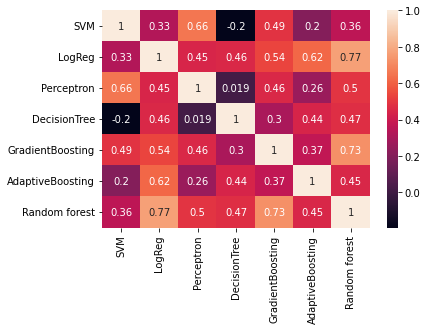

In [93]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(iesr_rfe_ranking.loc[m1], iesr_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.2,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    azim=150,
    elev=30
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_9']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_9']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_9']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_9']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_9'],
                           'fa': names_fa_fea_20['Dataset_9']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[9]

# 11 DDDT

## Read the data

In [119]:
dataset = read_data(
    datasets_folder_path,
    '11. DDDT'
)
dataset.head()

P1  N2  P3  M4  P5  M6  N7  N8  M9  P10  M11  N12 CONDITION
0   2   4   1   1   1   1   1   4   2    3    1    1         H
1   2   3   2   1   1   1   2   4   1    1    1    3         H
2   1   3   1   2   1   1   2   3   3    1    2    2         H
3   2   4   2   3   2   2   3   4   2    4    3    4         H
4   1   2   1   1   2   2   3   1   1    1    1    2         H

## Quick look and check the data

In [120]:
check_data(dataset)
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

In [121]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset.CONDITION
)

df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_trainval,
        df_test,
        df_train,
        df_validation
    ]
]

print(df_trainval.shape, df_test.shape, df_train.shape, df_validation.shape)

(788, 13) (198, 13) (630, 13) (158, 13)


In [122]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

P1  N2  P3  M4  P5  M6  N7  N8  M9  P10  M11  N12 CONDITION
454   3   4   1   1   1   1   4   4   1    1    1    2         H
73    2   4   2   1   2   1   2   4   1    2    1    2         H
310   2   2   2   2   3   2   3   4   4    4    4    2         H
175   2   3   2   4   2   2   4   4   2    2    2    3         H
332   3   2   2   2   2   2   2   2   1    3    1    1         H

## Data exploration (on train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

## Recursive feature elimination

In [ ]:
dddt_rfe_ranking, dddt_rfe_train_scores, dddt_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done
LogReg done
Perceptron done
DecisionTree done


In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(dddt_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(dddt_rfe_ranking.loc[m1], dddt_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.4,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    azim=0,
    elev=10
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_11']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_11']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_11']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_11']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_11'],
                           'fa': names_fa_fea_20['Dataset_11']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[10]

# 12 IADQ

## Download the data

In [ ]:
dataset = read_data(
    datasets_folder_path,
    '12. IADQ'
)

## Quick look and check the data

In [ ]:
check_data(dataset)
check_split_correctness(dataset, 'CONDITION')

## Create trainval + test + psychological sets

In [ ]:
df_trainval, df_test = train_test_split(
    dataset,
    train_size=TRAINVAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=dataset.CONDITION
)

df_train, df_validation = train_test_split(
    df_trainval,
    train_size=TRAIN_SIZE,
    random_state=RANDOM_STATE,
    stratify=df_trainval.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_trainval,
        df_test,
        df_train,
        df_validation
    ]
]

df_trainval.shape, df_test.shape, df_train.shape, df_validation.shape

((360, 10), (90, 10), (288, 10), (72, 10))

In [ ]:
df_sample = prepare_sample(
    dataset,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(dataset, df_sample)
df_sample.head()

## Data exploration (on train set only)

In [ ]:
plot_insights(df_train, df_sample)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval,
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
)

## Recursive feature elimination

In [ ]:
iadq_rfe_ranking, iadq_rfe_train_scores, iadq_rfe_val_scores = do_rfe(
    X_train=df_train.iloc[:,:-1], y_train=df_train.iloc[:,-1], 
    X_val=df_validation.iloc[:,:-1], y_val=df_validation.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


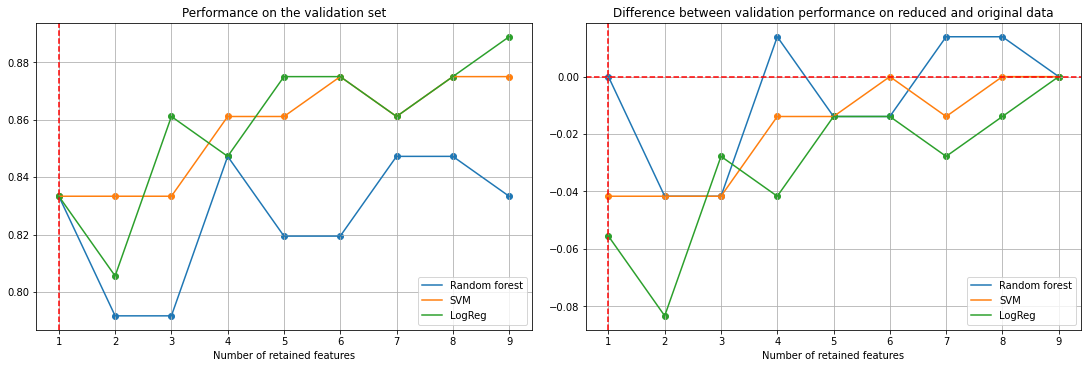

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(iadq_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(iadq_rfe_ranking.loc[m1], iadq_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Feature selection

In [ ]:
experiment_results = run_feature_selection_experiments(
    df_trainval,
    df_train,
    df_validation,
    df_test,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results['chi2']['trainval_processed'][0],
        experiment_results['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features = find_main_features(
    percentage_=0.4,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results['chi2']['trainval_processed'][0],
    Y_=experiment_results['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval
)

In [ ]:
report_outliers(
    df_trainval,
    main_features['chi2'][0]
)

visualize_clusters(
    df_trainval,
    main_features['chi2'][:3],
    figsize=(9, 6),
    azim=0,
    elev=10
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(dataset)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_12']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_12']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = dataset.shape[1]- 1
fa_loadings = df_factor(no_factors,dataset)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(dataset,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_12']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_12']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_12'],
                           'fa': names_fa_fea_20['Dataset_12']
    },
    df_trainval_ = df_trainval,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[11]

# 13 BF (3) (ctu)

## Download the data

In [ ]:
df_ctu = read_data(
    datasets_folder_path,
    '13. BF (3) (ctu)'
)

## Quick look and check the data

In [ ]:
check_data(df_ctu)
check_split_correctness(df_ctu, 'CONDITION')

## Create trainval + test + psychological sets

In [ ]:

df_trainval_ctu, df_test_ctu = train_test_split(
    df_ctu,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=df_ctu.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_trainval_ctu, df_test_ctu
    ]
]

[None, None]

In [ ]:
df_train_ctu, df_validation_ctu = train_test_split(
    df_trainval_ctu,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval_ctu.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_train_ctu, df_validation_ctu,
    ]
]

[None, None]

In [ ]:
df_sample_ctu = prepare_sample(
    df_ctu,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(df_ctu, df_sample_ctu)
df_sample_ctu.head()

## Recursive feature elimination

In [ ]:
ctu_rfe_ranking, ctu_rfe_train_scores, ctu_rfe_val_scores = do_rfe(
    X_train=df_train_ctu.iloc[:,:-1], y_train=df_train_ctu.iloc[:,-1], 
    X_val=df_validation_ctu.iloc[:,:-1], y_val=df_validation_ctu.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train_ctu.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


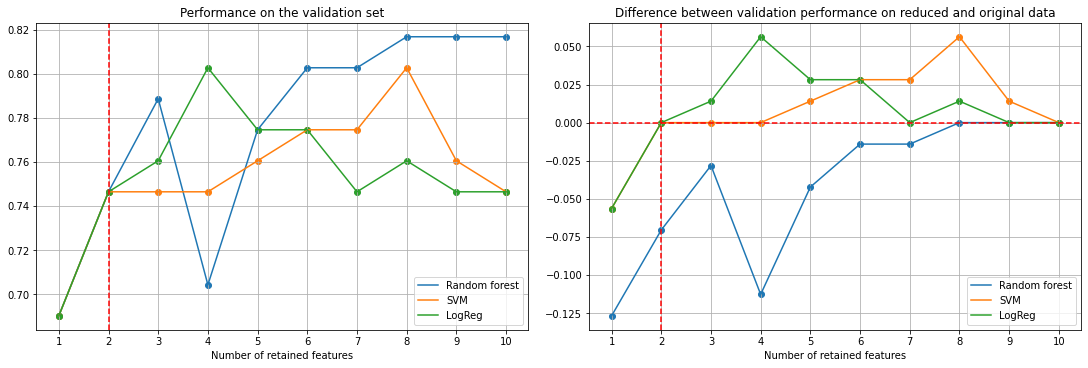

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(ctu_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(ctu_rfe_ranking.loc[m1], ctu_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Data exploration

In [ ]:
plot_insights(df_ctu, df_sample_ctu)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval_ctu,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

## Robust feature selection

In [ ]:
experiment_results_ctu = run_feature_selection_experiments(
    df_trainval_ctu,
    df_train_ctu,
    df_validation_ctu,
    df_test_ctu,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results_ctu['chi2']['trainval_processed'][0],
        experiment_results_ctu['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_ctu['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval_ctu,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features_ctu = find_main_features(
    percentage_=0.4,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results_ctu['chi2']['trainval_processed'][0],
    Y_=experiment_results_ctu['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results_ctu['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval_ctu
)

In [ ]:
report_outliers(
    df_trainval_ctu,
    main_features_ctu['chi2'][0]
)

visualize_clusters(
    df_trainval_ctu,
    main_features_ctu['chi2'][:3],
    figsize=(9, 6),
    azim=0,
    elev=10
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(df_ctu)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_13.1']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval_ctu.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_13.1']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval_ctu.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = df_ctu.shape[1]- 1
fa_loadings = df_factor(no_factors,df_ctu)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(df_ctu,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_13.1']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval_ctu.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_13.1']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval_ctu.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_13.1'],
                           'fa': names_fa_fea_20['Dataset_13.1']
    },
    df_trainval_ = df_trainval_ctu,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_ctu['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[12]

# 13 BF (3) (ou)

## Download the data

In [ ]:
df_ou = read_data(
    datasets_folder_path,
    '13. BF (3) (ou)'
)

## Quick look and check the data

In [ ]:
check_data(df_ou)
check_split_correctness(df_ou, 'CONDITION')

## Create trainval + test + psychological sets

In [ ]:
df_trainval_ou, df_test_ou = train_test_split(
    df_ou,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=df_ou.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_trainval_ou, df_test_ou
    ]
]

[None, None]

In [ ]:
df_train_ou, df_validation_ou = train_test_split(
    df_trainval_ou,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval_ou.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [
        df_train_ou, df_validation_ou,
    ]
]

[None, None]

In [ ]:
df_sample_ou = prepare_sample(
    df_ou,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(df_ou, df_sample_ou)
df_sample_ou.head()

## Data exploration

In [ ]:
plot_insights(df_ou, df_sample_ou)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval_ou,
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
)

In [ ]:
plot_problem_statement(
    df_trainval_ou,
    models_dict_=dict_subset(
        PROBLEM_STATEMENT_MODELS,
        [
            'DecisionTree',
            'GradientBoosting',
            'AdaptiveBoosting',
            'Random forest'
        ]
    ),
    rank_order_correlation_percentage_=0.4,
)

## Recursive feature elimination

In [ ]:
ou_rfe_ranking, ou_rfe_train_scores, ou_rfe_val_scores = do_rfe(
    X_train=df_train_ou.iloc[:,:-1], y_train=df_train_ou.iloc[:,-1], 
    X_val=df_validation_ou.iloc[:,:-1], y_val=df_validation_ou.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train_ou.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


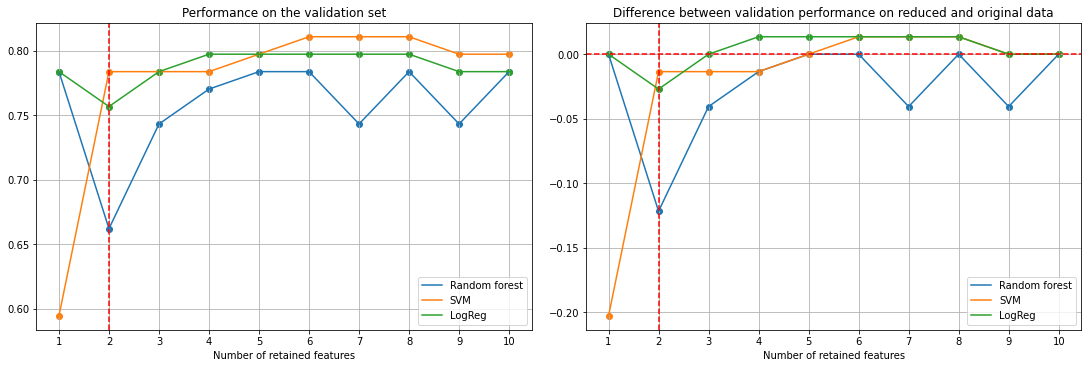

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(ou_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(ou_rfe_ranking.loc[m1], ou_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results_ou = run_feature_selection_experiments(
    df_trainval_ou,
    df_train_ou,
    df_validation_ou,
    df_test_ou,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_= GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results_ou['chi2']['trainval_processed'][0],
        experiment_results_ou['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_ou['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval_ou,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features_ou = find_main_features(
    percentage_=0.4,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results_ou['chi2']['trainval_processed'][0],
    Y_=experiment_results_ou['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results_ou['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval_ou
)

In [ ]:
report_outliers(
    df_trainval_ou,
    main_features_ou['chi2'][0]
)

visualize_clusters(
    df_trainval_ou,
    main_features_ou['chi2'][:3],
    figsize=(9, 6),
    azim=0,
    elev=10
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(df_ou)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_13.2']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval_ou.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_13.2']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval_ou.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = df_ou.shape[1]- 1
fa_loadings = df_factor(no_factors,df_ou)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(df_ou,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_13.2']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval_ou.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_13.2']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval_ou.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_13.2'],
                           'fa': names_fa_fea_20['Dataset_13.2']
    },
    df_trainval_ = df_trainval_ou,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_ou['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[13]

# 13 BF (3) (v)

## Download the data

In [ ]:
df_v = read_data(
    datasets_folder_path,
    '13. BF (3) (v)'
)

## Quick look and check the data

In [ ]:
check_data(df_v)
[
    check_split_correctness(df, 'CONDITION')
    for df in [df_v]
]

[None]

## Create trainval + test + psychological sets

In [ ]:
df_trainval_v, df_test_v = train_test_split(
    df_v,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE,
    stratify=df_v.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_trainval_v, df_test_v]
]

print(df_trainval_v.shape, df_test_v.shape)

(388, 11) (98, 11)


In [ ]:
df_train_v, df_validation_v = train_test_split(
    df_trainval_v,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE,
    stratify=df_trainval_v.CONDITION
)

[
    check_split_correctness(df, 'CONDITION')
    for df in [df_train_v, df_validation_v]
]

print(df_train_v.shape, df_validation_v.shape)

(310, 11) (78, 11)


In [ ]:
df_sample_v = prepare_sample(
    df_v,
    sample_size_=PSYCHOLOGIC_SAMPLE_SIZE,
    random_state_=RANDOM_STATE
)

verify_sample_correctness(df_v, df_sample_v)

## Data exploration (on train set only)

In [ ]:
plot_insights(df_v, df_sample_v)

## Problem statement

In [ ]:
plot_problem_statement(
    df_trainval_v,
    models_dict_=PROBLEM_STATEMENT_MODELS
)

## Recursive feature elimination

In [ ]:
v_rfe_ranking, v_rfe_train_scores, v_rfe_val_scores = do_rfe(
    X_train=df_train_v.iloc[:,:-1], y_train=df_train_v.iloc[:,-1], 
    X_val=df_validation_v.iloc[:,:-1], y_val=df_validation_v.iloc[:,-1],
    models=rfe_gridsearch, model_names=rfe_mnames, col_names=df_train_v.columns[:-1]
)

Random forest done
SVM done


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means 

LogReg done
Perceptron done
DecisionTree done
GradientBoosting done
AdaptiveBoosting done


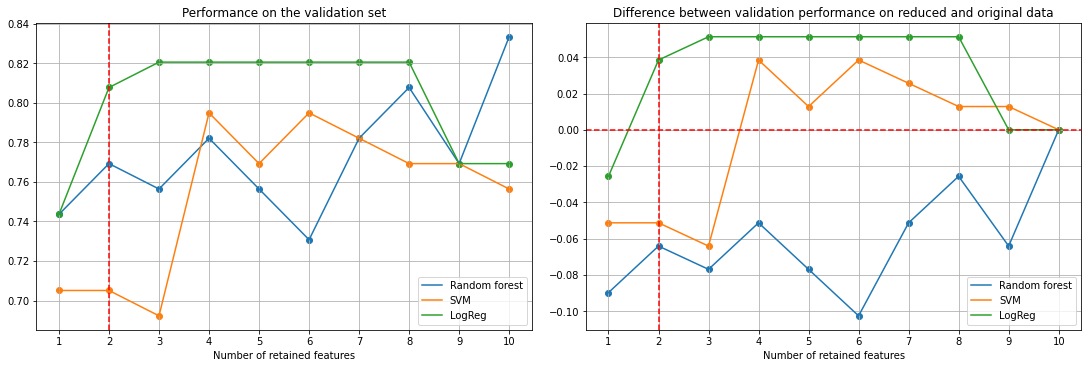

In [ ]:
models_to_plot = ['Random forest','SVM','LogReg']
%matplotlib inline
f, axes = draw_scores_plot(v_rfe_val_scores.loc[models_to_plot],models_to_plot)

In [ ]:
corrs_rfe = np.ndarray(shape = (len(models_sorted), len(models_sorted)))
for i,m1 in enumerate(models_sorted):
  for j,m2 in enumerate(models_sorted):
    corrs_rfe[i][j] = spearmanrho(v_rfe_ranking.loc[m1], v_rfe_ranking.loc[m2])

fig, ax = plt.subplots()
ax = sns.heatmap(corrs_rfe,annot=True,yticklabels=models_sorted)
ax.set_xticklabels(models_sorted, rotation = 90)

## Robust feature selection

In [ ]:
experiment_results_v = run_feature_selection_experiments(
    df_trainval_v,
    df_train_v,
    df_validation_v,
    df_test_v,
    {
        'chi2': chi2,
        'mutual information': mutual_info_classif,
        'ANOVA': f_classif
    },
    models_dict_=GRID_SEARCH_MODELS
)

## Concordance report

In [ ]:
concordance_report(
    percentiles_=[0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0],
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    train_data_tuple_=(
        experiment_results_v['chi2']['trainval_processed'][0],
        experiment_results_v['chi2']['trainval_processed'][1],
    ),
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_v['chi2']['grid_search_results'].items()
    },
    df_train_=df_trainval_v,
    plot_jaccard_=True
)

## Finding secret features

In [ ]:
main_features_v = find_main_features(
    percentage_=0.4,
    feature_selectors_dict_={
        'chi2': chi2,
        'ANOVA': f_classif,
        'mutual information': mutual_info_classif
    },
    X_=experiment_results_v['chi2']['trainval_processed'][0],
    Y_=experiment_results_v['chi2']['trainval_processed'][1],
    sklearn_model_=experiment_results_v['chi2'][
        'grid_search_results']['AdaptiveBoosting'].best_estimator_,
    df_=df_trainval_v
)

In [ ]:
report_outliers(
    df_trainval_v,
    main_features_v['chi2'][0]
)

visualize_clusters(
    df_trainval_v,
    main_features_v['chi2'][:3],
    figsize=(9, 6),
    azim=0,
    elev=10
)

## PCA feaure selection Done only using Honest Reviews

In [ ]:
selected_features,selected_features_20,df = perform_pca_feature_selection(df_v)

### Training models based on 100% features selected using PCA

In [ ]:
lst = [selected_features[i][0] for i in range(len(selected_features))]
lst = list(set(lst))
names_pca_fea_full['Dataset_13.3']  = copy.copy(lst)
lst.append('CONDITION')
pca_full = plot_problem_statement(
    df_trainval_v.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(pca_full)
print(final_full)

### Training models based on 20% features selected using PCA

In [ ]:
lst = [selected_features_20[i][0] for i in range(len(selected_features_20))]
lst = list(set(lst))
names_pca_fea_20['Dataset_13.3']  = copy.copy(lst)
lst.append('CONDITION')
pca_20 = plot_problem_statement(
    df_trainval_v.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(pca_20)
print(final_20)

## Factor Analysis

In [ ]:
no_factors = df_v.shape[1]- 1
fa_loadings = df_factor(no_factors,df_v)

In [ ]:
fa_selected_features, fa_selected_features_20 = fa_feature_selection(df_v,no_factors,fa_loadings)

### Training models based on 100% features selected using FA

In [ ]:
lst = [fa_selected_features[i] for i in range(len(fa_selected_features))]
lst = list(set(lst))
names_fa_fea_full['Dataset_13.3']  = copy.copy(lst)
lst.append('CONDITION')
fa_full = plot_problem_statement(
    df_trainval_v.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_full = results(fa_full)
print(final_full)

### Training models based on 20% features selected using FA

In [ ]:
lst = [fa_selected_features_20[i] for i in range(len(fa_selected_features_20))]
lst = list(set(lst))
names_fa_fea_20['Dataset_13.3']  = copy.copy(lst)
lst.append('CONDITION')
fa_20 = plot_problem_statement(
    df_trainval_v.loc[:,lst],
    models_dict_=PROBLEM_STATEMENT_MODELS,
    rank_order_correlation_percentage_=0.4,
    figsize_=(10, 5),
    take_abs_=False
)

In [ ]:
final_20 = results(fa_20)
print(final_20)

In [ ]:
lst_conc_pca_and_fa.append(concordance_pca_and_fa(percentile = 0.20,
                       feature_selectors_dict={
                           'pca':names_pca_fea_20['Dataset_13.3'],
                           'fa': names_fa_fea_20['Dataset_13.3']
    },
    df_trainval_ = df_trainval_v,
    sklearn_models_dict_ = {
        model_name: model.best_estimator_
        for model_name, model in experiment_results_v['chi2']['grid_search_results'].items()
    }
))
lst_conc_pca_and_fa[14]

# Summarized feature selection

This code is for assembling total dataset with experimental results across all datasets. It does not contain any visual results. We refer to the final dataset, that was already calculated, and is stored in the Data/ subfolder.

For each of the model independent methods, we build a histrogram of delta between the validation performance on full dimensionality, and of reduced dimensionality

In [93]:
df_total_model_independent = pd.read_csv(
    './Data/results_model_independent_chi2_ANOVA_mutual_information.csv',
    index_col='Unnamed: 0'
)
df_total_model_independent.head(5)

Dataset          Model Feature_selector  Validation_metrics_100  \
0  2. PRMQ  Random forest             chi2                0.920000   
1  2. PRMQ            SVM             chi2                0.888889   
2  2. PRMQ         LogReg             chi2                0.884444   
3  2. PRMQ     Perceptron             chi2                0.866667   
4  2. PRMQ   DecisionTree             chi2                0.888889   

   Validation_metrics_20  Delta_metrics_20_-_metrics_100  
0               0.884444                       -0.035556  
1               0.884444                       -0.004444  
2               0.884444                        0.000000  
3               0.804444                       -0.062222  
4               0.862222                       -0.026667

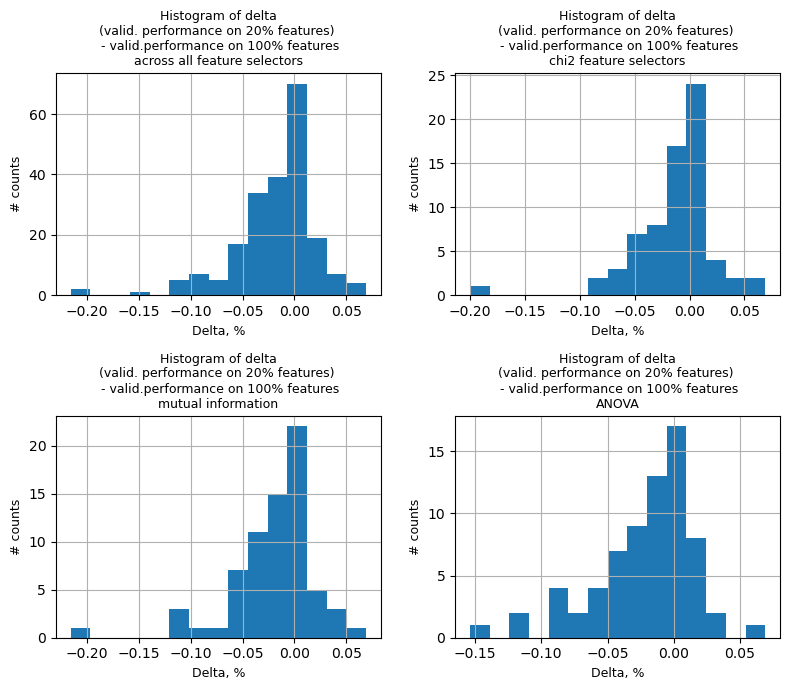

In [94]:
_, ax = plt.subplots(2, 2, figsize=(8, 7))
ax = ax.flatten()
fontsize = 9

df_total_model_independent['Delta_metrics_20_-_metrics_100'].hist(ax=ax[0], bins=15)
ax[0].set_title(
    'Histogram of delta\n(valid. performance on 20% features) \n - valid.performance on 100% features' + \
        '\nacross all feature selectors',
    fontsize=fontsize)
ax[0].set_ylabel('# counts', fontsize=fontsize)
ax[0].set_xlabel('Delta, %', fontsize=fontsize)

df_total_model_independent.loc[
    df_total_model_independent['Feature_selector'] == 'chi2',
    'Delta_metrics_20_-_metrics_100'
].hist(
    ax=ax[1], bins=15
)
ax[1].set_title('Histogram of delta\n(valid. performance on 20% features) \n - valid.performance on 100% features' + \
        '\nchi2 feature selectors', fontsize=fontsize)
ax[1].set_ylabel('# counts', fontsize=fontsize)
ax[1].set_xlabel('Delta, %', fontsize=fontsize)


df_total_model_independent.loc[
    df_total_model_independent['Feature_selector'] == 'mutual information',
    'Delta_metrics_20_-_metrics_100'
].hist(
    ax=ax[2], bins=15
)
ax[2].set_title('Histogram of delta\n(valid. performance on 20% features) \n - valid.performance on 100% features' + \
        '\nmutual information', fontsize=fontsize)
ax[2].set_ylabel('# counts', fontsize=fontsize)
ax[2].set_xlabel('Delta, %', fontsize=fontsize)


df_total_model_independent.loc[
    df_total_model_independent['Feature_selector'] == 'ANOVA',
    'Delta_metrics_20_-_metrics_100'
].hist(
    ax=ax[3], bins=15
)
ax[3].set_title('Histogram of delta\n(valid. performance on 20% features) \n - valid.performance on 100% features' + \
        '\nANOVA', fontsize=fontsize)
ax[3].set_ylabel('# counts', fontsize=fontsize)
ax[3].set_xlabel('Delta, %', fontsize=fontsize)

plt.tight_layout()



### Delta Performance of Validation Performance on all datasets using PCA and FA

In [95]:
pca_delta = [-0.02,-0.07,-0.05,-0.06,-0.02,-0.05,-0.05,-0.09,-0.06,-0.06,-0.22,-0.04,-0.06,-0.07,-0.09,-0.06,-0.07,-0.22,-0.04,-0.06,-0.07,-0.03,0.02,-0.04,-0.15,-0.01,-0.01,-0.03,-0.04,-0.04,-0.04,-0.04,0.01,-0.03,-0.01,-0.04,-0.04,-0.04,-0.04,0.01,-0.03,-0.01,-0.06,-0.04,-0.05,-0.07,-0.08,-0.05,-0.06,-0.11,-0.07,-0.08,-0.11,-0.08,-0.09,-0.08,-0.12,-0.1,-0.12,-0.18,-0.06,-0.11,-0.11,-0.04,-0.02,-0.02,0.01,0.04,0,0.02,-0.02,-0.05,-0.04,-0.06,0.02,-0.05,-0.07,-0.01,0,0.02,-0.01,-0.02,-0.01,-0.01,0,-0.02,-0.03,-0.1,0.04,-0.02,-0.02,-0.09,-0.05,-0.03,-0.01,-0.03,-0.07,-0.05,-0.18,-0.16,-0.16,-0.16,-0.14,-0.18,-0.18]
fa_delta = [-0.01,-0.02,-0.03,-0.03,0.02,-0.01,0,-0.03,-0.04,-0.05,-0.03,-0.01,-0.03,-0.01,-0.03,-0.04,-0.05,-0.03,-0.01,-0.03,-0.01,-0.05,0.01,0.02,-0.06,-0.01,0.01,0.04,-0.01,0,0,0.01,0.05,0,-0.01,-0.01,0,0,0.01,0.03,0,-0.01,-0.01,-0.02,-0.03,-0.05,0.04,0,-0.03,-0.06,-0.03,-0.02,-0.03,-0.04,-0.03,-0.01,-0.05,-0.04,-0.04,-0.05,0.02,-0.01,-0.01,0,0.04,0.03,-0.01,0.03,-0.02,0.01,-0.05,-0.03,-0.03,-0.01,-0.03,-0.05,-0.05,-0.01,-0.03,-0.03,-0.02,0.04,-0.01,0,0,0,0,0,0,0,0,-0.07,-0.06,-0.08,-0.12,-0.05,-0.1,-0.08,-0.02,-0.03,-0.03,0.06,0.03,-0.02,-0.02]

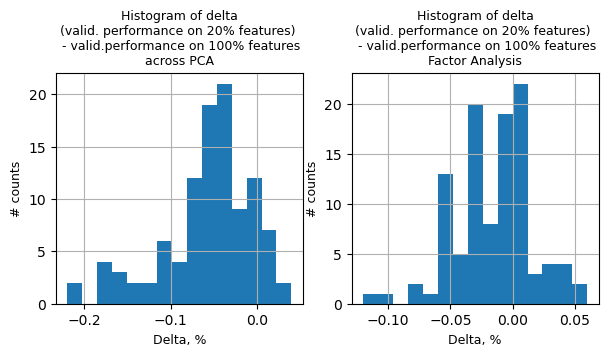

In [96]:
%matplotlib inline

fontsize = 9
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))


ax1.hist(pca_delta, bins=15)


ax1.set_title(
    'Histogram of delta\n(valid. performance on 20% features) \n - valid.performance on 100% features' + \
        '\nacross PCA',
    fontsize=fontsize)
ax1.set_ylabel('# counts', fontsize=fontsize)
ax1.set_xlabel('Delta, %', fontsize=fontsize)
ax1.grid()

ax2.hist(fa_delta,bins =15)
ax2.set_title('Histogram of delta\n(valid. performance on 20% features) \n - valid.performance on 100% features' + \
        '\nFactor Analysis', fontsize=fontsize)
ax2.set_ylabel('# counts', fontsize=fontsize)
ax2.set_xlabel('Delta, %', fontsize=fontsize)
ax2.grid()

plt.show()

### Jaccard Similarity of PCA and FA of all datasets

In [89]:
sim = []
for i,j in zip(list(names_pca_fea_full.values()), list(names_fa_fea_full.values())):
    sim.append(compute_jaccard(i,j))

ZeroDivisionError: division by zero

In [ ]:
sim_20 =[]
for i,j in zip(list(names_fa_fea_20.values()),list(names_pca_fea_20.values())):
    sim_20.append(compute_jaccard(i,j))

In [ ]:
print(f'Jaccard similarity between PCA and FA for full features selection: {Counter(sim)}')
print(f'Jaccard similarity between PCA and FA for 20 % features selection: {Counter(sim_20)}')

In [ ]:
# Create a figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot the line chart
ax1.plot(range(1,16),sim, linestyle='dashed', color='red', label='Jaccard similarity')
ax2.plot(range(1,16),sim_20, linestyle='dashed', color='black', label='Jaccard similarity')

# Add a legend and set the title and labels
ax1.legend(loc='best')
ax1.set_title('Jaccard similarity of full features between PCA and FA')
ax1.set_xlabel('Dataset')
ax1.set_ylabel('Similarity')
ax2.legend(loc='best')
ax2.set_title('Jaccard similarity of 20% features between PCA anf FA')
ax2.set_xlabel('Dataset')
ax2.set_ylabel('Similarity')


# Show the plot
plt.show()

### Concordance between PCA,FA 20% feature selection and features selected by Models 

In [ ]:
# Use the 'seaborn-darkgrid' style
plt.style.use('seaborn-darkgrid')

# Create a figure and axis
fig, ax = plt.subplots()

x = range(0,len(lst_conc_pca_and_fa))
y1 = [lst_conc_pca_and_fa[i]['pca']['Random forest']for i in range(0,len(lst_conc_pca_and_fa))]
y2 = [lst_conc_pca_and_fa[i]['pca']['SVM']for i in range(0,len(lst_conc_pca_and_fa))]
y3 = [lst_conc_pca_and_fa[i]['pca']['LogReg']for i in range(0,len(lst_conc_pca_and_fa))]
y4 = [lst_conc_pca_and_fa[i]['pca']['Perceptron']for i in range(0,len(lst_conc_pca_and_fa))]
y5 = [lst_conc_pca_and_fa[i]['pca']['DecisionTree']for i in range(0,len(lst_conc_pca_and_fa))]
y6 = [lst_conc_pca_and_fa[i]['pca']['GradientBoosting']for i in range(0,len(lst_conc_pca_and_fa))]
y7 = [lst_conc_pca_and_fa[i]['pca']['AdaptiveBoosting']for i in range(0,len(lst_conc_pca_and_fa))]

# Plot the line chart
ax.plot(x, y1, linestyle='dashed', color='red', label='Random Forest')
ax.plot(x, y2, linestyle='dashed', color='green', label='SVM')
ax.plot(x, y3, linestyle='dashed', color='blue', label='LogReg')
ax.plot(x, y4, linestyle='dashed', color='orange', label='Perceptron')
ax.plot(x, y5, linestyle='dashed', color='violet', label='DecisionTree')
ax.plot(x, y6, linestyle='dashed', color='black', label='GradientBoosting')
ax.plot(x, y7, linestyle='dashed', color='brown', label='AdaptiveBoosting')

# Add a legend and set the title and labels
ax.legend()
ax.set_title('Concordance between 20% feature selection of PCA \n features and Model Based feature selection ')
ax.set_xlabel('Dataset')
ax.set_ylabel('Jaccard similarity with PCA feature selection')

# Add a background with boxes
#ax.fill_between(x, y1, facecolor='lightgray', alpha=0.5, edgecolor='blue')
# Show the plot
plt.show()

In [ ]:
# Use the 'seaborn-darkgrid' style
plt.style.use('seaborn-darkgrid')

# Create a figure and axis
fig, ax = plt.subplots()

x = range(0,len(lst_conc_pca_and_fa))
y1 = [lst_conc_pca_and_fa[i]['fa']['Random forest']for i in range(0,len(lst_conc_pca_and_fa))]
y2 = [lst_conc_pca_and_fa[i]['fa']['SVM']for i in range(0,len(lst_conc_pca_and_fa))]
y3 = [lst_conc_pca_and_fa[i]['fa']['LogReg']for i in range(0,len(lst_conc_pca_and_fa))]
y4 = [lst_conc_pca_and_fa[i]['fa']['Perceptron']for i in range(0,len(lst_conc_pca_and_fa))]
y5 = [lst_conc_pca_and_fa[i]['fa']['DecisionTree']for i in range(0,len(lst_conc_pca_and_fa))]
y6 = [lst_conc_pca_and_fa[i]['fa']['GradientBoosting']for i in range(0,len(lst_conc_pca_and_fa))]
y7 = [lst_conc_pca_and_fa[i]['fa']['AdaptiveBoosting']for i in range(0,len(lst_conc_pca_and_fa))]

# Plot the line chart
ax.plot(x, y1, linestyle='dashed', color='red', label='Random Forest')
ax.plot(x, y2, linestyle='dashed', color='green', label='SVM')
ax.plot(x, y3, linestyle='dashed', color='blue', label='LogReg')
ax.plot(x, y4, linestyle='dashed', color='orange', label='Perceptron')
ax.plot(x, y5, linestyle='dashed', color='violet', label='DecisionTree')
ax.plot(x, y6, linestyle='dashed', color='black', label='GradientBoosting')
ax.plot(x, y7, linestyle='dashed', color='brown', label='AdaptiveBoosting')

# Add a legend and set the title and labels
ax.legend()
ax.set_title('Concordance between 20% feature selection of FA \n features and Model Based feature selection ')
ax.set_xlabel('Dataset')
ax.set_ylabel('Jaccard similarity with FA feature selection')

# Add a background with boxes
#ax.fill_between(x, y1, facecolor='lightgray', alpha=0.5, edgecolor='blue')
# Show the plot
plt.show()

In [ ]:
# def summarize_feature_selection(
#     dataset_names_list_,
#     feature_selectors_dict_,
#     models_dict_
# ):
#     final_df_data = []
#     for dataset_name in dataset_names_list_:
#         print(f'Processing {dataset_name}')

#         # Download the data
#         dataset = read_data(
#             datasets_folder_path,
#             dataset_name
#         )

#         df_trainval, df_test = train_test_split(
#             dataset,
#             random_state=RANDOM_STATE,
#             train_size=TRAINVAL_SIZE,
#             stratify=dataset['CONDITION']
#         )
#         df_train, df_validation = train_test_split(
#             df_trainval,
#             train_size=TRAIN_SIZE,
#             random_state=RANDOM_STATE,
#             stratify=df_trainval['CONDITION']
#         )

#         # check_split_correctness(df_train, 'CONDITION')
#         # check_split_correctness(df_validation, 'CONDITION')
#         # check_split_correctness(df_trainval, 'CONDITION', eps_=0.001)
#         # check_split_correctness(df_test, 'CONDITION', eps_=0.01)

#         # Run experiment, according to the scheme
#         experiment_results = run_feature_selection_experiments(
#             df_trainval,
#             df_train,
#             df_validation,
#             df_test,
#             feature_selectors_dict_,
#             models_dict_=models_dict_
#         )

#         for feature_selector_name, feature_selection_results in \
#                 experiment_results.items():

#                 results_across_models = feature_selection_results['results_across_models']
                
#                 for model_name, model_results in results_across_models.items():

#                     percentiles = model_results['percentiles']
#                     assert (20 in percentiles) and (100 in percentiles)

#                     index_20 = percentiles.index(20)
#                     index_100 = percentiles.index(100)

#                     validation_metrics_20 = model_results['metrics'][index_20]
#                     validation_metrics_100 = model_results['metrics'][index_100]
#                     delta = validation_metrics_20 - validation_metrics_100

#                     data = [
#                         dataset_name,
#                         model_name,
#                         feature_selector_name,
#                         validation_metrics_100,
#                         validation_metrics_20,
#                         delta
#                     ]
#                     final_df_data.append(data)
#     return pd.DataFrame(
#         final_df_data,
#         columns=[
#             'Dataset',
#             'Model',
#             'Feature_selector',
#             'Validation_metrics_100',
#             'Validation_metrics_20',
#             'Delta_metrics_20_-_metrics_100'
#         ]
#     )

In [ ]:
# from functools import partial

# summary = partial(
#     summarize_feature_selection,
#     feature_selectors_dict_={
#         'chi2': chi2,
#         'mutual information': mutual_info_classif,
#         'ANOVA': f_classif
#     },
#     models_dict_=GRID_SEARCH_MODELS
# )

In [ ]:
# df_PRMQ = summary(
#     dataset_names_list_=[
#         '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_PCL = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_NAQ_R = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_PHQ9_GAD7 = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_PID5 = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_short_PID5 = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_PRFQ = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_IESR = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         '9. IESR',
#         # '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_DDDT = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         '11. DDDT',
#         # '12. IADQ',
#     ]
# )

In [ ]:
# df_IADQ = summary(
#     dataset_names_list_=[
#         # '2. PRMQ',
#         # '3. PCL',
#         # '4. NAQ_R',
#         # '5. PHQ9_GAD7',
#         # '6. PID5',
#         # '7. shortPID5',
#         # '8. PRFQ',
#         # '9. IESR',
#         # '11. DDDT',
#         '12. IADQ',
#     ]
# )

In [ ]:
# dfs = [
#     df_PRMQ,
#     df_PCL,
#     df_NAQ_R,
#     df_PHQ9_GAD7,
#     df_PID5,
#     df_short_PID5,
#     df_PRFQ,
#     df_IESR,
#     df_DDDT,
#     df_IADQ
# ]

# total_df = pd.concat(dfs)
# total_df.head()